This lecture follows the Fast.ai course about Deep Learning. I highly recommend this resource.

In [1]:
from fastai.collab import *
from fastai.tabular.all import *
from IPython.display import Image
from IPython.core.display import HTML

path = untar_data(URLs.ML_100k)

C:\ProgramData\Anaconda3\lib\site-packages\torch\cuda\__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


First look at the data

In [4]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=['user','movie','rating','timestamp'])
ratings.head()

,user,movie,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


Change to more readable form:

In [71]:
Image(url= "https://raw.githubusercontent.com/fastai/fastbook/780b76bef3127ce5b64f8230fce60e915a7e0735/images/att_00040.png", width = 600)

A movie and user is represented by a number of factors. So we could describe someone with some factors like "likes action", "likes holywood", "dislikes romance" -> (0.9, 0.8, 0.1).

In collaborative filtering we use Latent Factors, that means we the factors are not pre-determined.

In [15]:
user1 = np.array([0.9,0.8,-0.6])
james_bond = np.array([0.8, 0.5,-0.2])

# DOt product
(user1*james_bond).sum()

1.2400000000000002

In [16]:
Image(url= "http://media5.datahacker.rs/2020/04/Picture27-768x290.jpg")

In [18]:
user1 = np.array([0.9,0.8,-0.6])
lalaland = np.array([0.1, -0.7,0.4])

# DOt product
(user1*lalaland).sum()

-0.71

##### rating = user_vec * item_vec + user_bias + item_bias

Add titles:

In [20]:
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1',
                     usecols=(0,1), names=('movie','title'), header=None)
ratings = ratings.merge(movies)
ratings.head()

,user,movie,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [21]:
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)
dls.show_batch()

,user,title,rating
0,18,Nell (1994),3
1,860,Fargo (1996),4
2,449,Faust (1994),4
3,385,"Sting, The (1973)",3
4,13,"Body Snatcher, The (1945)",4
5,529,Lost Highway (1997),2
6,293,Unforgiven (1992),3
7,43,Evita (1996),4
8,924,Sophie's Choice (1982),4
9,121,Twister (1996),2


### Embedding Matrix

To determine the rating for a user we lookup the row in the User matrix, multiply it with the Item matrix and we're done. Except: deep learning frameworks don't 'lookup a row'. They love matrix multiplications, so we do a trick. We one-hot encode our inputs.

In [22]:
n_users  = len(dls.classes['user'])
n_movies = len(dls.classes['title'])
n_factors = 5

user_factors = torch.randn(n_users, n_factors)
movie_factors = torch.randn(n_movies, n_factors)

In [30]:
user_factors

tensor([[ 1.0032e+00,  6.4137e-01,  8.3786e-02,  2.0695e+00,  5.9333e-03],
        [-1.3059e+00, -1.5123e+00, -4.6544e-01, -3.0798e-01,  8.7394e-02],
        [-9.8387e-01, -3.8239e-01,  2.8612e-04,  7.5974e-01, -1.5350e+00],
        ...,
        [-9.4114e-01,  2.1598e+00, -6.7764e-01,  9.7417e-01,  2.4484e+00],
        [-2.2173e+00, -1.6903e-01,  1.5687e+00,  2.1017e+00, -1.9805e-01],
        [ 1.7468e-01, -3.2154e-01, -1.5282e+00,  8.3691e-01, -5.5508e-01]])

In [32]:
user_factors[3]

tensor([-1.5671,  0.8123, -0.1339, -0.1700,  1.5049])

In [24]:
one_hot_3 = one_hot(3, n_users).float()

In [27]:
one_hot_3

tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 

In [28]:
user_factors.t() @ one_hot_3

tensor([-1.5671,  0.8123, -0.1339, -0.1700,  1.5049])

In deep learning frameworks: embedding matrices are objects that do perform matrix mulitplications and not look-ups but have an optimised performance for learning.

In normal talk, embedding matrices are a representation of an variable by a number of latent factors.

### Now let's rock and roll: Collaborative filtering with Fastai / PyTorch

In [37]:
class DotProduct(Module):
    def __init__(self, n_users, n_movies, n_factors):
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        return (users * movies).sum(dim=1)

Note that the input of the model is a tensor of shape batch_size x 2, where the first column (x[:, 0]) contains the user IDs and the second column (x[:, 1]) contains the movie IDs. As explained before, we use the embedding layers to represent our matrices of user and movie latent factors:

In [35]:
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64) 
# contains the input data for a model, set different parameters like batch size
dls.show_batch()

,user,title,rating
0,184,"Walk in the Clouds, A (1995)",3
1,445,"Rainmaker, The (1997)",1
2,271,"Madness of King George, The (1994)",4
3,82,Young Frankenstein (1974),3
4,25,Star Trek: The Wrath of Khan (1982),4
5,851,Unforgettable (1996),3
6,660,Terminator 2: Judgment Day (1991),3
7,222,"Game, The (1997)",5
8,701,Amistad (1997),5
9,196,Up in Smoke (1978),4


In [44]:
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(10, 5e-3)

epoch,train_loss,valid_loss,time
0,3.937727,3.145604,00:08
1,1.109701,1.112037,00:07
2,1.068830,1.093917,00:08
3,0.990789,1.043267,00:08
4,0.935663,0.986556,00:08
5,0.815203,0.923231,00:08
6,0.714773,0.882806,00:07
7,0.619599,0.860316,00:07
8,0.563151,0.848109,00:08
9,0.526796,0.847979,00:08


Now we did only do vec_user * vec_item and all movies are treated the same. So any sci-fi, holiwood, romance movie would be the same, by adding a bias we account for movies that are simply better/worse and users that are more or less prone to like movies.


##### rating = user_vec * item_vec + user_bias + item_bias

We also know that the rating should be in a specific range, let's say 0 to 5.5 (in case someone will really really like it)

In [42]:
class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.user_bias = Embedding(n_users, 1)
        self.movie_bias = Embedding(n_movies, 1)
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        res = (users * movies).sum(dim=1, keepdim=True)
        res += self.user_bias(x[:,0]) + self.movie_bias(x[:,1])
        return sigmoid_range(res, *self.y_range)

In [43]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(7, 5e-3)

epoch,train_loss,valid_loss,time
0,0.933970,0.931880,00:08
1,0.879766,0.860294,00:09
2,0.674906,0.870436,00:09
3,0.464631,0.932181,00:09
4,0.319497,0.971595,00:09
5,0.219689,0.992776,00:09
6,0.158922,0.996584,00:09


### Reguralisation

A penalty for adding more or larger weights. So make the weights smaller and only increase if they really add something.

In [51]:
Image(url= "https://upload.wikimedia.org/wikipedia/commons/thumb/0/02/Regularization.svg/1200px-Regularization.svg.png", width = 400, height = 200)

Weight decay, or L2 regularization, consists in adding to your loss function the sum of all the weights squared. Thus: Cost Function = RMSE + Lambda * Sum of weights ^ 2, Lambda determines the strength of the regularization

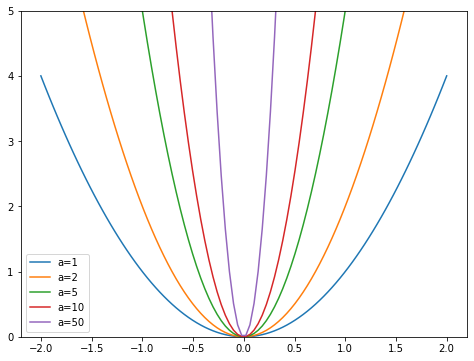

In [3]:
#Parabolic example of increased lambda values
x = np.linspace(-2,2,100)
a_s = [1,2,5,10,50] 
ys = [a * x**2 for a in a_s]
_,ax = plt.subplots(figsize=(8,6))
for a,y in zip(a_s,ys): ax.plot(x,y, label=f'a={a}')
ax.set_ylim([0,5])
ax.legend();

By making the cost function less smooth, the final version becomes more smooth

In [69]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.8)

epoch,train_loss,valid_loss,time
0,1.042457,1.037790,00:09
1,1.048735,1.023053,00:09
2,1.020412,1.002054,00:09
3,1.009814,0.972611,00:09
4,0.965641,0.964212,00:08


# Interpretation

What are the best and worst movies, the biases hold the answer!

In [61]:
movie_bias = learn.model.movie_bias.squeeze()
idxs = movie_bias.argsort()[:5]
[dls.classes['title'][i] for i in idxs]

['Children of the Corn: The Gathering (1996)',
 'Lawnmower Man 2: Beyond Cyberspace (1996)',
 'Beautician and the Beast, The (1997)',
 'Crow: City of Angels, The (1996)',
 'Home Alone 3 (1997)']

The best movies:

In [62]:
idxs = movie_bias.argsort(descending=True)[:5]
[dls.classes['title'][i] for i in idxs]

['L.A. Confidential (1997)',
 'Titanic (1997)',
 'Silence of the Lambs, The (1991)',
 'Shawshank Redemption, The (1994)',
 'Star Wars (1977)']

### PCA


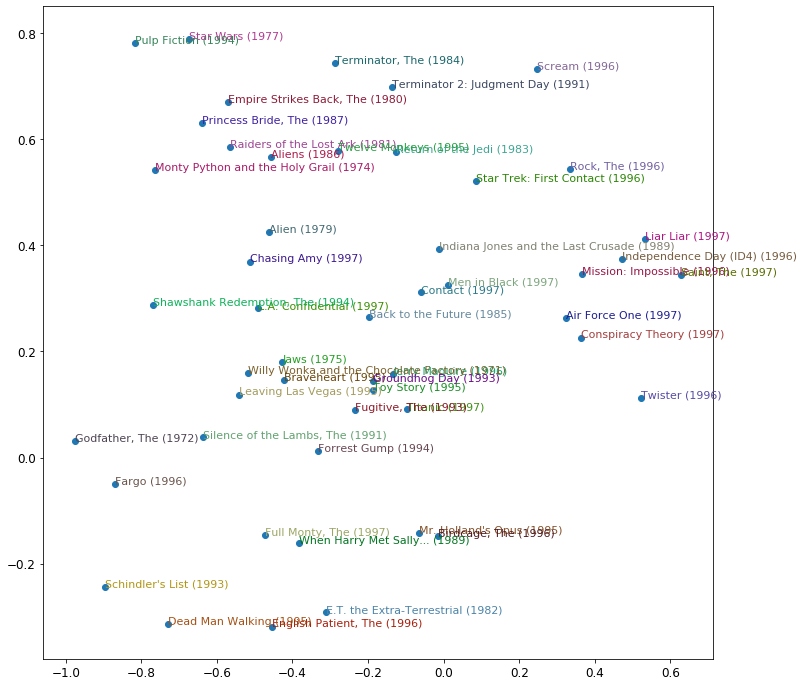

In [67]:
#hide_input
#id img_pca_movie
#caption Representation of movies based on two strongest PCA components
#alt Representation of movies based on two strongest PCA components
g = ratings.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_idxs = tensor([learn.dls.classes['title'].o2i[m] for m in top_movies])
movie_w = learn.model.movie_factors[top_idxs].cpu().detach()
movie_pca = movie_w.pca(3)
fac0,fac1,fac2 = movie_pca.t()
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(12,12))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

Euclinian distance (Pythagoras, in 2D: sqrt(x^2 + y^2) between points show the similarity of the movie.

In [ ]:
Image(url= "data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAyQAAAKuCAYAAABQVtgOAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4xLjEsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy8QZhcZAAAgAElEQVR4nOzddXhV9R/A8fe5d9vdXfdYMdgGo3N0SwqCCCIiiCgmFiBpYiAoISqgoIgIoiJId0h3p6NjyYJ13Dq/PwZXxoIBk/mTz+t5eB7u+eY5l7HzOd84iqqqCCGEEEIIIURZ0JR1B4QQQgghhBAPLglIhBBCCCGEEGVGAhIhhBBCCCFEmZGARAghhBBCCFFmJCARQgghhBBClBmbsu7AnfDy8lIrVKhQ1t0QQgghhBD/cQcOHEhUVdW7rPvxIPi/CkgqVKjA/v37y7obQgghhBDiP05RlEtl3YcHhUzZEkIIIYQQQpQZCUiEEEIIIYQQZUYCEiGEEEIIIUSZkYBECCGEEEIIUWYkIBFCCCGEEEKUGQlIhBBCCCGEEGVGAhIhhBBCCCFEmZGARAghhBBCCFFmJCARQgghhBBClBkJSIQQQgghhBBlRgISIYQQQgghRJmRgEQIIYQQQghRZiQgEUIIIYQQQpQZCUiEEEIIIYQQZUYCEiGEEEIIIUSZkYBECCGEEEIIUWYkIBFCCCGEEEKUGQlIhBBCCCGEEGVGAhIhhBBCCCFEmZGARAghhBBCCFFmJCARQgghhBBClBkJSIQQQgghhBBlplQDEkVRPBRFWawoSqaiKJcURXmqiHw6RVG+VRQlXlGUZEVRliuKElCafRFCCCGEEEL8+5X2CMk0wAD4An2BbxRFqV5IvjeBJkAtwB9IAb4u5b4IIYQQQggh/uVsSqsiRVEcgZ5ADVVVM4DtiqIsA54GRt2SvSKwVlXV+OtlfwUml1ZfhLidmE1nOP3TPlDBYjDjGu5N/TGdAPhr1m4q92+AxlZ7T20k7LvMsS+28ND8pwEwZuSypvNMarzZkoo9awNwdv5B0s4mUO/9jvd2QkUw5RjZMWgRzab1xEZvy9n5B7m07DiZUSk0/Kwr5ZpVtOZNPh7Lia+2YcoxorXVUmvEQ7iF+2Axmtn6/G/WfOZcE1kxqXRc8QI2etsi0+xc7Nnx2iLqvN0OR3/Xf+T8hBBCCPH/r9QCEqAyYFZV9fRNx44ArQrJOwv4UlGUG6MjfYHVhVWqKMqLwIsA5cuXL8XuigdVTmImRyf9Sasf+qD3dUZVVdLOJFrTT/+wl7A+9e44ILGYLGhs/h509KjlT1ZMKjnJWdh7OJB8NAa3cB8SD0VbA5KkQ1H4tQq9p3aKc2HhEfxbh2KjtwXAs24A5VqGcGT8xnz5VFVl/zurqP9hJzzrBJB0JIaDH66lzc/90NhqaT3n79mX5347ROL+K9i52AMUmxbyRB0iZ+2h3nsd7ugchRBCCPHgKM2AxAlIveVYKuBcSN7TwGUgGjADx4DXCqtUVdWZwEyAiIgItbQ6Kx5cucmZKFottq55N82KouBa2RuAo5P+BGDby7+jKArNpvYkftdFzv9+GIvRDED111rgHREEwPqesyn/SHUSD1zBMcCVOqPbWdvR6mxwq1qOpINRBLSrnBeIPF6byNl7AVDNFpKOxlBjcF7MfmLqNpIORWMxWbBztafO2+1wKOdCVmwaWwf+SoWetUjcf4XADlXQeTnw18zdKBoF1Wyh5tDWeNULLHCul5Yep+nXPayf3av6FnpNDCnZGDNy8ayTt5TLs7Y/OQkZpEYm4FbFJ1/eK6tOUfnZhoXWc2uab9MKHPlsE6ZMAzaOdoWWEUIIIcSDrTQDkgzA5ZZjLkB6IXm/AewBTyATGEHeCEmjUuyPEIVyCfPGvZovG3rMxrNuAB61/AnqVAU7Vz213mrDxT+O0eLbXtg45N1A+zQqT0D7yiiKQsala+x88w86LBlorS83KZNmU3sW2pZX3QASD0UT0K4ySYejCe1dl6j1p0k7n4Ql14Stow7HgLzpTGH9Iqj+WgsALi07zsnpO4j46GEADKk5OAd7UGVgYwA2PzOfWm+1xrNOAKrZginHWKDt7Ph0zDkmHMrd+mNZkM7dATtXPbHbzuHXIpS47ecxZRnJikvLF5CknIonJzGTcs0rFqijsDSNjRaXEE+Sj8Xg07jCbfshhBBCiAdPaQYkpwEbRVEqqap65vqx2sCJQvLWBt5RVTUZQFGUr4GPFEXxUlU1sZD8oox0n/YmdlpbbG1ssVgsPNusOx2qNym2zHdbF5FlzOHNtn3vqK1X5n1CXFoijnZ6AII9/Rj72Bv8cXADuSYjfRo+XGTZmJQE9lw4xmN1H7IeG/zb5wzr8AyB7nmjAksORTNhbSQxKdn4uzkw/NXmeOUYid16nnPzD9J6bl/rVKObZUan8tcHa8hJyCTWMZ3VwSdomZSJvacjCyocJ0rZS/Kn3/PnsFk42P1dfvmRLczLWUZWegaVftlH21wv7L0c8awbwKLNq1mZtA9TfSNrFiTxfteXSdt9hYuLjmLKNqKaVRYGHOPVT+exqt8XaOy0ZNeyZ/BvnzOl9wi86gVyYup2/NuE4dOkAi4hngX6nZ2Qgc7DocTXv8G4LpycvoPTP+zFvXo5nCt4FJgadnnlSQI7hqOxKTidrag0nacD2VczStwPIYQQQjxYSi0gUVU1U1GUP8gLLJ4H6gCPAk0Lyb4P6K8oymYgCxgExEgw8u80rsebhPoEERl3kRd+GkPDijVwcyhsJt69e6t9f5pXqpfvWI967YrI/bfY1ASWHNqULyCZ0nuE9e9LDkUz+o9jZF+fdhWdks3o3ZcZ16Mm3XvWZlPfuSQejMK/dViBug98sIbqr7fAr2Uob/76Gc1+DcRiyKunfpI/7w7syRNL3slX5kJiNDO2/M6PT3/E7h6/cKaCLZurRtEFyAzR8svGzYxI60DlVjXY4BrJ16vmETFLQ4vve+Po78qq9RtQVx+11mejtyXMpzy2Whv2XzxBxJstSTuXSOKBKPa/u4rQJ+sS3K1Gvj5o7Www55pue+1ucAv3oemXjwFgMZpZ2/V7nCp4WNPNuSaiN5ym2fTHC5QtPs2MVleazz6EEEII8V9S2ncJg4AfgKtAEvCKqqonFEVpAaxWVdXper5hwFfAGcAOOA48Vsp9EaUsvFwFHOz0xKRc5ff96/KNghQ1KrLi6BbWHt+Jg05P1LV4XPVOjOn2Cj7OHoU1Uahb6/5x51LWndiJomjQ2+qY2f99Jqz9kZiUBPp9P5pAd1/G9xxM92lvMqnXMEJ9gvh8zT50tlvR2+WitYB9SjWuUIEJayMZt3oEbZ0qMPvUCTJO5tAs2JP2mQbrlC1jhgEHPxfiUhM5f+UybRPCrX0LTffA3b5gcHY+IYpKvsF4uXvgXs0Xz21xLAm/AECCcza+6Y4YjiTjNSSQpoqel3d+TAObZth7OpKSmcbsvcvof6UmB71i8tXboVoTlh3ZTBXFH5dQL1xCvTBlG0k5FV8gIHEKdic3KROzwYTW7vY/6jnXR30Azszdj2edAJwC3azpsVvO4RjoVuhoTHFpGZeScanU+LbtCyGEEOLBVKoByfUpWN0LOb6NvEXvNz4nkbezlvg/sv/iCXJNBoI8yt1RuSNRkcwd+CnBnv58v20Rk9f9xPiegwvNO2n9T3y75XcAejfoRNfa+TdpW3l0K9vOHGRm/w9w0jmQmpWORtEwvOMAvto4nznPfVJovTmmTeQYw8gxhuJuTAK3jQzdbcbGbMec1lC+USU+fW4AR65EMjJtEnVf/wOtzoZmU3tS480W7Bu9kuPBSVTw88LOteC0rltV8inPqdjzxKRcxaNuAL/t3kWOxUBqdgbhfhWIcUon3cOCvpwzazctJ9uUi0ubQP7sN4/fq5yiZ7km2FtyCtRbM6ASk9fP5eTuHWReSUHRarB11lFnVNsCebU6G7zqBZJ0KBqfRsEAnP35AOd/P4whJZvDY9ejsdPS5ud+2DrquLT0OFHrIlEtKm5VfKjzdv6RqcsrT1K+S7VCz7eotKy4NIBCAxUhhBBCCCj9ERLxH3DzWgsflxxe+2USno56HHV6xvccjLO94x3VVzswnGBPfwC61WlD3+9ufS3N3wqbsnWz7WcP0bNeO5x0eWsjXEswdSwzNxtb7TVyjCEAXLP1RFU8mVpfh7dTJbBs48kn8xal1wioxDVLJs3nPYnOJm+EJKhTVYI6VSVq51IqZKTSaVh/a93tFz1baJvlPf0Y2r4/7yz+GsVGoeVzLdmzeQFajYbynn6M7PECvwSuYu2cD2hZuT4ANQe1YE+nY/idyebJbn3gVXj30w3oy7nQadWLAHg6uZGcmUq9Tzpho739j29YvwjO/nzAGpCE9a1PWN/6heYNf64R4c8Vva/Ejelcd5J2cfExQvsU/X0KIYQQQkhAIvK5da2F2aJyOakRL7VsSfe6AdZ8Wo0GVf17F2aDueAuT4VRVRUU5a77d3ObJS6DilZR0NtqyTZarMd1Wi3DO4YzbjXY2eS9p0OryVvEbbZYCtSjs7HDYCrZeQJ0qN7EugHAiZhzLHRebw2kiko7cOkk+y+doPu0N6319Jk5gi96jyDEO5BckwEbjbZEwQiAR00/fJtWwJRttL6L5H6y93IqclRFCCGEEAKgZG9XEw+MCWsjrcHIDTkmCxPWRuY7FuDuy1+xF7CoFjJzs9l+5lCRdR6JOs3l5Dggb8pV/fJV77p/LSrVY9HBDWTmZgOQmpW3q7SjTk9GblahZZx0DlTxq0CfhrkEuOmx0aSis0ll9MMt8gVZtxPmHcTl5NgS50/KSAEg12Tgu60L6duoy23TRnR6lhWvT2XJq1+y5NUvAfjlxc8J8c57x8jFxBjCfO7sBaHB3WqUSTACENKrNorm7gNQIYQQQvz3yQiJyCcmJbtExx+q0pCNp/bQZ+ZIAt19qeJX8L0UN9QrX4Xvti7kfGK0dVH73epcswUJ6dcYOOcDtBotDnb2zHj6PcJ8yhPs6UefmSMJ9vQrsEblw26DGL/6Byp4phHqreWV1m/QJDS8iFYKVzsonJiUq2TkZOFknzfSMXLhF5yIPQfAE98OI8Q7kK/65E1J+3jFDGJTEzFZzLSv2pjeDTpa6yourTi7zx+lTZUGd9RvIYQQQoh/M+VupsCUlYiICHX//v1l3Y3/tGbjNxFdSFAS4KZnx6iHCilRvBVHt7D9zKEiF7H/v/lx51J0NnbFvhPln2I0m3h29ntMfertf2zbZSGEEELkURTlgKqqEWXdjweBTNkS+QzvGI7eNv+L7fS2eWstBDzVsDM6m7KZ/hSbmsgrrXtLMCKEEEKI/xQZIREF5H+juZ7hHcPvaK2FEEIIIcT/OxkhuX9kDYkooHvdAAlAhBBCCCHEfSFTtoQQQgghhBBlRgISIYQQQgghRJmRgEQIIYQQQghRZiQgEUIIIYQQQpQZCUiEEEIIIYQQZUYCEiGEEEIIIUSZkYBECCGEEEIIUWYkIBFCCCGEEEKUGXkxohBC3IVHxk/EYDJhNJk5f/Uq4f5+ANQICmTyM/3+kTbNFgsPf/o5K0YNw87m7v77vpaZyW87dvNyh7al2reNx07w2dLlACSkpaGq4OPqAsCwrl1YfuAgDcNCebpl83tqJzMnl16Tv2TRsMHo7eyYtnY9v+7YxcWERH567WXaVK9mzbv/3Hk+XLiYbIMBnY0NE57uQ7XAQGvaBwsWYTSbMZnNDHyoNX1bNMvX1i87djF87nzmvv4KbapXI8dopMeEL1gw9A2c7O3v6TyEEEL8TQISIYS4CytGDQPgSmISncdNYN27o+64DlVVsagqWk3JBqu1Gs1dtXOzlMwsZmzYeFcBiclsxkarLTStbc3qtK1ZHYDPl67AZDHz9mOPWtOXHzh4dx2+xaxNm+kaUQ+9nR0AzcIr06VeHYb8OC9fPovFwoszZjHzpYFEhIawM/IMr//wExvffxuAkT//yrs9u9OmejXiUlJp/t6HdK5bB3cnRwCik5P5bccuageXt9Zpb2tLt4j6fL9xM4O7dCqV8xFCCCEBiRBC/CN+3bGLuVu3Y7ZYcHVwYNxTvQnx9WH+9p2sOXwEF70DZ+PimDLgaUbP/416IRU5eP4CUcnJvNi2DR7OzszZvJWrqWm83+sxOtetg8lspsKrgzn79WTsbW2JGPUeTzZrzJaTf5GQmsagju3o36oFAGMWLGLfufMYTCa8nJ2Z1L8v/h7uvPvrAq5lZNLhk/E42ev4Y9gQzsdfZdT8X0nOyMRWq2V09260rFbF2t67Pbqz/thxmoVXYugjne/6mpyKiqbX5K+IuXaNRmGhTOrfF0VRSMvOZsyCRUTGxJJrMtGiSjjv9eyOppBAbf72nSwePsT6uU6F4ELbSkhPJ9tgICI0BICm4ZW4lJDIyago6yhJenY2AJk5Obg66LG3swXyAsUR837hw96PM2bBonz1PtqgPt0nTJaARAghSpEEJEIIUcp2Rp5h7ZGjLB4+BDsbG9YfPcbweb+w6K03Adh79jzr3x1FkJentUx8SiqL3nqTuNRUWr7/MS+1b8uykW+x/9x5Xps1h8516xTalsFkYvnIt7iUkEj7T8bRq0kj9HZ2vNG5Ix5OTgDM3bqdcUuW8fVzz/DJk0/QY+IX+UZaXp31I8+1aUWvJo04FR1D7y++ZsuYd3HW501LUhSsfb8XkbFxzH9jEAAdPhnPztNnaBZemQ9+W0ir6lWZ/Ew/LBYLg77/kd9376V308b5yl9OTMRkseDn7nbbtnxcXHC0t2fjseO0rVmD1YeOkGM0EpV0jWqBgUwZ8DQDv/mOTxYtJSUrk2kDB1hHXWZv3kqNoKB8oyM3+Lm7oapw4WoCFX287/maCCGEkIBECCHuyJJD0UxYG0lMSjb+bnqea+pbIM/6o8c4djmKR8ZPBPKeuGfm5lrTG1UKzReMADxSvw4ajQZ/d3dc9Ho6160NQM3yQUQlJ2M0m1EK6c+jEfUBCPb2wklnT1xKKhV9vNl47ARztmwj22DAaDZjW8RUq5TMLE7HxvF444YAVA3wp7JfOQ5dvEjLqlUA6NWk0Z1dpCI8XKcWOtu8UYgaQYFcSkikWXhl1h87zrErUUxfuwGAbIOBYG+vAuVjr6Xg7eJcorYURWHWKy/w6R9LmbBsJRGhIYT6+mCjzRt1mb52PWOe6EHnunU4ExvHk1OmUj0okFyjiYW79uQbhbmVt4szsddSJCARQohSIgGJEEKU0JJD0Yz+4xjZRjMA0SnZfL4mEsyWfPlUVaVvi6YM6fJwofU46nQFjt24UQfQaDTobPP+e76xvsRssWBTyBSmG/lulDNbzFxKSOTjRUtYOWoYQV6e7D5zlrd++rnI8yos0FGUv486FNLfu3HrOZoteddNVVXmvPoSAR4exZa3t7Mj12gscXu1g8vz25DXAcgxGqk7/G3CyvlyNTWNP0+c4psXngOgkl85KvuV48jFy2Tm5hKbkkKrDz4B8hboD/lxHu/2fJTHG+cFZrkmk3V6lxBCiHsnAYkQQpTQhLWR1mDkhhyjGdWQ/1j72jUZMfcX+jRrSjk3V8wWCyeuRFGrkClA/4T07Gx0tjb4uLpgsViYt3WHNc3Z3p6sXANmiwWtRoObowOV/MqxaM8+Hm/ckMiYWE7HxlEnuPC1GdHJyfSf+q11cXhpaF+rJtPWrOfjJ3uh1WhISk8nMzeX8l75R0kqlfMl5lpKsSM+N7uammbd6evr1WtpUbUK5b28rKNN+86ep0FYCHEpqZyKjqGyXzlCy/laR4sAHpvwBW907mjdvctkNhOdlEy4n1+pnf9/3akD59ix5iCqqmI2milX3ovuA9uXdbduKz0lk0Uz1/LMsMdQNAobFu7kr0PnSU1K54X3nsAn4O9RzjPHLrFl2V4sZgt6Rx1dn3kINy+X26aZjCbW/76DC6eisbHVEhDiS5d+rTEZzcyZsJi+Q7piry+dBwJC/JtJQCKEECUUk5Jd6HGLqub73Cy8MkMe6cQz077FYrFgMlvoGlH3vgUkNcoH0aFWTdp8OBZ/d3caVQrj0MWLAHi5ONOlXh3afvQpHk6O/DFsCNMGDmDU/F+ZsX4jWo2Gqc89g7uTIyazuUDdcSmpJd4VrKQ+7v04n/yxlA6fjAfydrP68ImeBQISB52OhmEh7DlzluZVwgGYumYdP27eRnJGBm/OnoudjQ3bPnoPvZ0dc7ZsZfmBQ5jNFupUDObzfn0AsNVqmfb8AN797XcsFgsWVWVk966Elis4/e5We86cpUFYCI72cpNYEumpmaz5ZSsD3+6Fi4cTqqoSH5V0R3VYzBY02vv/2rTtq/bToE1NFE3eaGF4nYo0fKgWP01cki9fdmYuy3/cxDMjHsPT141je06zev5W+rzxSLFpABv/2I2NjQ2vfNQHRVHISMsCwMZWS81Gldiz4QitujZEiP86Rb3lF+m/WUREhLp///6y7oYQ4gHVbPwmogsJSgLc9OwY9VAZ9Oj+m752AwEe7jzaoH6ZtL/nzFm+37SZ7156vkzaf3nmD/Rv1YKm4ZXKpP3/N3GXE/ht2ioGffwUtoVMc4s6H8fGRbsw5ORNxWvbswkh1YKY+vY8ajerwqXIaNy8XHikfxuO7vqLA1tOYLFY0OnteLhPSzzLuXM1Ook1v2zFkGvCbDRTt0VVGrbNW4O1/MdNaG21JF9N4VpCGlXqhFCpVjBbV+wjLTmThm1r0bBtrQL9MhlNfDVqLm+Mfxob2/zPbqe+PY8nXn3YOkISc/Eqy+ds4qUPngQgOzOHyW/NZsjEAaQkpheZZmNjw1ejf+KNcf2xsy94bTLSsvjh04W8Mb7/PXwD4l4oinJAVdWIsu7Hg0BGSIQQooSGdwzPt4YEQG+rZXjH8DLs1f01qGO7Mm2/UaUwzsbFk20wWHfFul9yjEaaV6kswcgd8A30wr+CD1+PnkdwZX+CwspRo1E4Dk72ZGfmsPDbNTz+UicCQ8thsVjIzf57jVBGahb9hua9y+bymRhOHjjH0291x8ZWy9njl1jx02aeGfEYrp7OPPVmN2xstRhyjMwev4iQauXx8nMHICEmmb6Du6GqFqa+M4+cHANPD+1Oemom3475hTrNqhYICGIuXsXdx6VAMFIYD19XMtOyiLl4Ff8KPhzfewaA1OSMYtM0GgW9oz3bVu7jYmQMdjpbWj/akKCwvOmATi4OaG00JMZdw6uc+71/GUL8i0lAIoQQJdS9bgBAvl22hncMtx4X98etb1S/X+xtbel3j2+af1Dcuhvd650bE6w1c/rwBXatO8KL7z9B1Pl4vPzcCQwtB+RtdKB3/HsqXK3Gla1/P3P0Elejkpj92fX3wqiQk5W3c53RYGLNwq3ERyWhKArpqZnERyVaA5Lw2hWxsdUCWjx93QirXh5Fo+Di7oS9g460lIwCN/zpKZk4OjuU6Fzt9Toee74D63/fgcloJrRGeewd7NBqNcWmmU0WUhLT8A3yom3PpkRfiGfB9FUM+qgvOn1esO3o4kD6tUwJSMR/ngQkQghxB7rXDZAARIhiFLYb3YebLzGuR02eGlyDGWN+5dLpGLS3WRdiq7t51EKldtMqtOpWcD3F5iV7cHRx4Pl3HkKj1TD/y+WYbhrF1Nr+vQGComiuByd5NIoGyy275AHY2NpgNhVcQ1WUilUDqVg174WbGWlZ7F532Lpwvag0k9GERqOheoO8EbeAir44OOpJupqCf7APACajOV9/hfivuv+rxIQQQgjxn3XzbnQOFhM+plyyjWYmrI0k7VoGWRnZuHk6ExhajsTYa0SdjwPAYrGQnZlbaJ2ValXg2O7TpF3LsOaNvZQAQE52Li7uTmi0Gq5GJ3HlbOw9n4NPgAdJcSklzp+RmrcYXbWobF6yh3otq2F3PaAqKs3BSU9wuD8XTkUBkBSfQmZ6Nh7ertZzTElMwzug+O2whfgvkBESIYQQQpSam3ej0wD1c1Jxspgwpyn8NjWBVt0aUq583kslH3+pExt+34nRYARFoV3PptbRhJuVr+RP60cbsmD6alSLitlspmq9UPyCvWn+cH2W/biR43tP4+7tSvlK/vd8Du7erugc7EiKu4bn9elSa3/bTuSh82SkZTH/y+XoHe2ti9U3L9tD1Lk4zCYLIdUCeeixxta6ikt7+KlWrPjpTzYs3IlGq6Hbsw9h75A3bS3qXBwBFX1l21/xQJBdtoQQQghRav4ru9Gd2HeG6PPxdOhdNuuGlsxaT+2mVQsN0MT9Ibts3T8yZUsIIYQQpWZ4x3D0t6x7+H/cja56g0q4+7iiWu7/g1uT0UxQJX8JRsQDQ6ZsCSGEEKLU/Jd2o2vQpmaZtGtjq6V+y+pl0rYQZUECEiGEEEKUKtmNTghxJ2TKlhBCCCGEEKLMSEAihBBCCCGEKDMSkAghhBBCCCHKjAQkQgghhBBCiDIjAYkQQgghhBCizEhAIoQQQgghhCgzsu2vEEKIQr345scYjUaMJjNRUXFUrJC3jWul0GDefmvgP9Km2Wzh+dfHMPPL97G1vbtfUWnpGaxcu40+jz98z/0xmc18MHY6Fy7FYGdni4e7C8Ne74+/n89tyw4a+inPPNWVRhF39i6Luy1X2m53HaNi4un3wjtUDPbHYrFgMpmpXTOcZ/s+ireXe6n2ZfSYL3m2X3cqhwWze99Rvv9pMecuXKF3j468/Fwva77EpGtM+GoO8VeTMZnNDOjTlXZtGt82rbg6v57xCzWqhtGmZYNSPSchxN8kIBFCCFGomV++B0BsXCIvvPEhs6d/dMd1qKqKxaKi1ZZsQF6r1dxVOzdLS8/k10Vr7iogMZnN2Gjzv2W8c8cWNG1YG0VRWLB4HRO//onJnw67pz7+PyjJdXR1cbR+XwaDkR/nL2PQ0LHM+fZjHBz0pdKPoyfOYDJbqBwWDECAvw8jBz/Lxi17CuT96tu84OGzDx8h+VoqL7z+IXVqhePl6V5sWnF1PtWrM2+O/IzWLSJQFKVUzkkIkZ8EJEIIIe7KyrVbWbpyMyazGWdnR4a93p+ggHIsX72FrTsP4uzkwMXLMbw7/AUmfvG3cd4AACAASURBVPUT1auGcuLUOeKvJvJEj464uTqzePkmkpJTeO3FJ2nVPAKT2UybLs+zYdlMdHa29Og3lC4dW7D3wHGSk1N56onOPPbIQwB8NeMXjh0/jdFkxt3NmVFDn8PX25PJU+eSmpbJs4Pex0Fvz7RJb3M5Ko5JX88hJTUDGxstLz/Xiwb1qlvbG/T8E+zYc4T6tavwbL/u1nO00Wpp1qiO9XP1qqEsXfnnHV+rW0c9bv58/mIU4yf/gNlioWJwAEaj0Vru/MUoxk2ahcFopFJoMJevxDKw/2M0iqjJoKGfluiaAhw/eZYZsxeSnZMLwPP9H6Nxg1pExcTz6luf8nD75uw9cJzcXAOjhj5HzWqVCr2OxbGzs+XFAT3Zd+A46//czaNd2vDz76vYvHUfJrMZnZ0dw954hrCQIH76dQUpKWm88fJTQN7oxcDXxrBgzkR0drb56l2+ejPtr49kAAQFlANg87Z9mC2WfHnPnr9Cv95dAPBwdyWkYiB/bttHr+4dik0rrk5PD1e8vdw5dPQv6tWueruvWghxFyQgEUIIcccOHfmLbTsPMW3S29ja2rBj92E+m/IjUyeMAuDoidP8OP1j/Mp5WcskJacwdeIoEpNSeOr50TzZsxPfTnmXYyfP8NH4Gdab51sZjSZmTHmPmNirDHjlfTq3b45OZ0f/Jx/BzdUZgCUr/2TGDwt5f+RLDH3taV5969N8Iy0fjv+Wxx9tx8Ptm3PuwhXeHPU5P383DkfHvKf4iqJY+16cxcs30axxXevnTyfNok2LCJo0rH3nF/G6jz6byVO9HqbDQ004evw0rw0fny+tX+8utGvdiBN/nWPQ0LH5ypbkmqalZzB52lwmfjIUD3dXEhKv8dLgj5k7I6+u5Gtp1K1VhZef68Xq9duZMXsRUyeMKvQ6lkTV8BAuXIoBoEuHFvTt1RmAPfuPMXnqXKZPfptuD7fimZff48UBPbG317F01WY6PNS0QDACcOhoJM881a1EbYdXCmbD5j1UCi1PTGwCJ06dp3yg323Tbqd61TAOHDopAYkQ/xAJSIQQQuSz5FA0E9ZGEpOSjb+bnhcbFlwvsX33IU6fu8SLb+bdrKoqZGXnWNNr1wjPF4wAtG7RAI1Gg4+3B44Oelo1qw9AeFgF4q4mYTKZoJApMW1bNQLA388Hvd6ehKRrBPr7smvvERav+JOcnFxMJjM2NtoCZQHS0zO5eDmGTu2aARBaMYiK5QM4FXmeiHrVAaxpxfnp1xVEx8Qz/I1nrMfudS1NWnoGUTHx1hGAWjUqU6G8f760dq3zzr96lVBr2g0luaZHj58hNi6Bt96ZZC2nADFxCej1Opwc9daRm+pVQvluzh/3dE4qqvXvJ/86z88LVpKekYWi5E3/A3BzdaZxg5qs+3M3nds3Y+XabUUGhImJ1/BwcylR22+8/BRffTufZwd9gJ+vJ/XqVLX+uygu7XY83V05GXm+RHmFEHdOAhIhhBBWSw5FM/qPY2QbzQBEp2Tz+ZpI/E35p7GoQNeHW/Fs30cLrUev1xU4dvPTb61Wg931z5rr60vMFhWttmBAYndLObPZQkzsVaZ9/xvfffkBfuW8OHwskvGTfyjyvAqb+3/zMb3evsiyAAsWr2PL9v1MGT8Cnc6u2LyF0Wo1WG6aCmS4Pi1LVYvun6rmBQ7FKck1VVGpHBbMl5+NLFA+KiY+3/XVaDWYzeYSnVNRIk9f5JFOLcnNNTBm3DdMm/Q2lULLE381id4DRljzPf5oe8ZNnoWjgz2hFYOK3CjAzs6WXIOxRGtS3N1c+GDUy9bPQ9+eSHCQ/23TbifXYLyr710IUTKy7a8QQgirCWsjrcHIDTlGM9mG/MeaN67Dmg07SEy6BuTtjhV55uL96iYZmdnobG3x9HDFYrGwbNVma5qjg57sHANmc14A4OzsSHCQH2s37gLgwsVoLlyOpkrliiVqa/HyTaxev53Jnw7D2cnhrvob4OfDX6cvAHDuwhXOX4wCwNXFiaAAXzZszltMffzkWS5ejrGm+fv5sGnrXgBORZ63pt2JmtUqcfFyDIePRVqPleRp/63X8XYMBiPf/7SYaylptGvdiFyDAbPFgo+3BwCLV2zKl79SaHn09jqmf/cbPbo+VGS9IRUCuRIVV6I+pKZlYLoeUO09cJxLV2Jpe32Eqbi027l0JYawkKAS5RVC3DkZIRFCCGEVk5Jd6HGLqub7XK92VZ7t+ygj3p+CxaJiMptp27IB4ZUq3IdeQuWwYJo3qUu/F9/B19uD2jXDOflX3k22u5sLrZtH8MzL7+Lq4sS0SW/zwaiXmfT1HH5dtAaNRuGDkS/j6uJkvUEtSnp6Jl9Mn0c5Xy8Gj/ocAHudHd988S5Q/BoSs8WMnW3e6EO/J7vw/tjp7NxzhNCQIMIq/n1z+96IFxk3aRa/LFxN1coV8wVK7414kfFf/MDPC1ZRtXJFQioE4niHu1e5uTrz6Qdv8M2s38nIyMJkNuNfzpvPPxpcbLnCruOtbix6N5stmM152/5On/yOdTRjwFPdeP61Mfj6etGwfo0C5R/p1JLZPy8rdovjls3qs/fAcWrVqAzkrV/6eMJMMrPy/q2u27SLt996noi61Th+6ixTZ/yCRqPB3c2Fzz4cbB1FKi6tuDpVVeXQkb8Y+HT3QnonhCgNinrLL5l/s4iICHX//v1l3Q0hhPjPajZ+E9GFBCUBbnp2jCr6KbbILzsnl17PDGPW1DH4envedT1Z2Tno7XUoisK5C1cYMnoi82eNw8nx7kZq/m3GTvyesJAgevfoWGSe9IwsXhs2jplfvV/oovd/2s49R9i8ff8/9u4d8e+lKMoBVVUL321DlCoZIRFCCGE1vGN4vjUkAHpbLcM7hpdhr/6/bNyyhx/mLqHXo+3vKRgBOHIskhmzF6GqKoqiMHLIs/+JYCQ+IYnBoybg7enOsNf7F5vX2cmBQc8/QVx8IsFBJdsVqzRl5+Tw0rOP3/d2hXiQyAiJEEKIfG7dZWt4x3C61w0o624JIcR9JSMk94+MkAghhMine90ACUCEEELcN7LLlhBCCCGEEKLMSEAihBBCCCGEKDMSkAghhBBCCCHKjKwhEeJf5vvGj6HV2WGj+/tN191mfYZrKe0uE3fkFAe/+5XOUz+857oOz1nEkZ/+QNFoMBsMhLRrRqv33iAnNZ1jPy+lwaB+RZbNiEtg1etjeOL3aQBMDmzCa5EbsSvlHYROLFjJ5jFTcAnMu36KRqHle69TvtndrVNMvRLLz52fZdCxNSUus/GdCcTsOwZA0pkLuJb3t36/fVfPZkpw81I597Nrt3Jp617ajh2GKdfA0udGEH/0L4AC/d07dQ6nFq/DYjLhV7c67T4bhc31N1HvnTqHU3+sRdFqsXNyoN34kXiFhwBwbv02tn4yFYvJjG+tKnSc/C62ensS/zrH1rHT6DF38j2dgxBCiAeQqqr/N3/q16+vCvFf912j7mrCqbNl0rbZaCxx3thDJ9RZzR5Xs1PS8sqaTOrVE2dUVVXVlMsx6rQaHe+onUkBjdXcjMw77PHtHf9thbrshdHWz+c27FBnt+p91/Xd7txup7Dvt7TO/ceHnlLTouNVVc27xhe37lHjj0cW6O+FzbvVOW37qobMLNVisahrh32q7vl6jqqqqhp/PFKd2bC7asjMUlVVVQ98/5u6qN8QVVVVNTcjU/2mTmc1+dxlVVVVde1bY9Wdk7+31rvkuRHqpe377/k8hBDi3wDYr/4L7n8fhD8yQiLE/5HJgU1oNuIlzq7dSs61VNp/PopL2/ZxcfNuLCYzj3w7Fs9KFbiy8yB/fvAFvjXDSTh5BkWrpdMX7+FZuSJXdh5k6ydf03fVbOvT/joDHufy9n1U7dGRGr27sv2zb4nafQiL0YRXlVDajhte4Ol9euxVdC5O2DnmvZFZo9XiXS0MgE3vTCQ3LYO5Hfpjo9fRZ+l3LHh8EP4RNYk9dAIbnY6Hxg4rdKRBtVjY8tFXZCYk03Hyu5gNRrZ8+CUJp85izjUQ1LQ+rT54A41Wy67Js/hr6bq80QYFei2Yhr2rc7HX0JCege6mPKte+4Br5y9jyjXgViGQjpPewd7NBYDjvy7n4KwFAGjtbOn+48R8dZlyDax580Oc/Hxo9f4bKIpyF99qnkM/LODsmrzvtcU7r1G5SxsAYg+eYNu46RgyMgFoOuwFQto2K1A+as9h9B5uOPv7AKCxsSG4RUNSr8QWyJtw8gwBjWpje/1t2hXbNGHnpO9o+Fp/FEXBYjJhzM7B1kGPIT0DZ7+8Oi/+uQvfWlVwD8l7y3itpx9j7ZCPaTIk74VxVR5tz/FfllG+Wf27vg5CCCEePBKQCPEvtPylt61TejQ2Wvqumm1N07k40XflD5xesZGlz42kyzcf02L0IPZNn8eer36k89djAEg8dZY2Hw0hqEk9Tvy+kjWDP8pXzw0511LxrFSBpm89D8DuL2db2wDYOnYae6f+RPORL+crV6FVI/ZNn8d3jR4jsHFdgprUo2rPTtjq7a3BxtPrfspXJjHyPD1/noLGxqbQG2VzroG1Qz7BJagcnad+iKIobHpnIoGN69Jh4tuoFgurXh/D8V9XULlLG/bPmM/Lh1diq7fHkJGJjb2uQJ0Al7fvY26H/hgys8hOTuGxOZOsaW0+GoLeww2AHZ/PYN/0ebR4exBXdh5kz9dzeHLxDBx9PDFkZqHRajHl5AKQfS2V5S+MJqxTK+o937voL7OE7Jwc6bvyB6L3HWHFy+9SuUsbclLT2TD6Mx77aTJOvl5kxCcyv8tz9N/4c4HAK2rXQfzqVi9RW761qnBs/jKyk1PQuThxesVG0qPjAPCuVon6LzzJ9417oHNxwt7VmScWfQNAWnQ8LoHlrPW4BPiSHhNv/exXvwZ/fvDFvV4KIYQQDxgJSIT4F7j5RXTPpeYQPm4ET3RvUmje8G7tAPCpEQ6KYn1a7lsrnDOrN1vzuVUIJKhJPQCq9XyYDSM/Izc9s0B9Wp0dlbu2tX4+t24bhoxMzqz8EwCzwYB3tUoFytk66Omz7Dvij5wieu8Rjv2yjMNzFlkDmcJU6d4BjU3R/+380W8I4d3aEfFy37/7s347cYdPcmDmLwAYs3NwKueNnbMjHqHlWf3Gh1Ro3ZiQds2wc3IstN7yzRvQdeanAFzZeZCVg97j2W0LsNXbc3Lhak4tXovZYMSUnYNbxbyn/+c37qDa4w/j6JP3pu2bR4jMuQZ+6/EyTd96nsqPtC3Y4F2o8mh7APzq1SAzPhFTTi4x+4+RdiWWxU8P/TujopByMYpytavmK58eexWPsOAStVW+WQR1nunJoqfeRKuzo3zzCOv3khYVy7l12xi4YyGOPp7s+2YeawZ/lC+IK4qjtydZCcmYjSa0tvLrRQghRMnIbwwhytiSQ9GM/uMY2UYzAGaLypQNZ7ALLl/oy+m01xceK1otWjtb63FFo0U1m++4fVsHfYGpRm0/HV6iRd+KolCuTjXK1alGnQGP822dziRGnrdOebrVjeldRQlsUo+Lm3dTu38P63QiVJVusz7DLbjgteiz7Dui9x3lyo4D/Nz5WXrM/cI6bawoQU3rYTGZSIo8jynXwJGf/uDJpTNx8HTn1OK1HPt56fWcapF1aGxt8KtXnXPrthP2cGs0Wm2xbZbEje/1Rl0WsxlQ8aoaRu/rIxTFsbHXYc41lLi9es/3to7sRC7fgEelCgCcXrEJryqh1kCs2uOd2TV5FpA3InJl5wFrHWnR8Tj7+1o/m3INaGxtJBgRQghxR2TbXyHK2IS1kdZg5IYck5kJayPvqd6Ui1FE7TkMwKnF6/CqEorOufARhJuFtm/OgZm/YMzOAcCQkUnSmYsF8iWfvUjiX+f+/nzuEmaDEWc/b+ycHDBl52Axme6oz02GDqR8i4b80W+IdTQnpH1z9k2be/0GHbKTU0i9HIMhI5OspBSCmtSj6bAX8AoPITHyXHHVA5Bw6iyGjCxcgvzITUtH5+KE3t0VU66BE7+tsOYLadeckwtXk5mQnHcdMrMwXb/hVzQaOkx8BztnB1a+8h5mY955Hpr9O9vGTb+jcy6Of/2apFy4wuUdfwcBcYdPkrfWMj+vKqEkn7tc4rozryYBkJOSxr5pc4l46SkAXIL8id57BGNWNgAXNu207rBVoXVj4o+c4tr5KwAcnbs43whR8pmLeFctPiAUQgghbiWPsYQoYzEp2QWOdd66CPMOG+Zu+hGA9hNGF5iiczve1SsRuXQ9m8dMQdFo6DTl/RKVa/Bqf3ZN/p75jwzMGzlRFJoMGYjn9SfoNxizc9k8ZgpZicnY6HQoWg0PfzUGBy8PAKo81pGf2vVD5+pMn6XflbjfDV99Ght7HQuffJ0e876gzYeD2Tp2GnM79AfARmdH6zGD0djYsPzF0ZhyclFVFZ8alan0cOtC67yxhkRVVVBVOn7xLg6e7lRs04RTf6xldqsncfbzwbdWFeIOnwQgqEk9Gr7Wn4VPvo6i0RRY1K4oCm3HDmfLx1+xbOBIus78lOSzF3EN8i/xud6OvZsLj/7wOVs/mcrmMVOwGI24lg+g+48T4JZRrZB2zdn79RxUiwVFk/es6ecuz5ERe5Xc1HRmRnSjQuvGdJj4NgAL+7wBqorZaKLOgMcJ69QKgEqdWxN36ATzHh6A1s4OnYsTHSe/C+Stc2n32SiWDBiGxWzGp0Zl2rw8xNqHi1t2U6lz61I7fyGEEA8GpbAnbf9WERER6v79+8u6G0KUqmbjNxFdSFAS4KZnx6iH7qrOm3fSEvfPbz1f4bE5E4tcy/JPWz9yPBVaNy4yMPsnmQ1G5j8ykMd//cq6SYAQQvw/UxTlgKqqd/fSKnFHZMqWEGVseMdw9Lb51yDobbUM7xheRj0Sd6v3om/KLBgBaDbiJesuYPdbWlQczUa+LMGIEEKIOyYjJEL8C9y8y5a/m57hHcMLXdAuhBBCiPtDRkjuH1lDIsS/QPe6ARKACCGEEOKBJFO2hBBCCCGEEGVGAhIhhBBCCCFEmZGARAghhBBCCFFmJCARQgghhBBClBkJSIQQQgghhBBlRgISIYQQQgghRJmRgEQIIYQQQghRZiQgEUIIIYQQQpQZCUiEEEIIIYQQZUbe1C5ECfVu/gd2Oi22dlosFgtPv1aTtl0rFpr385G76NgzhNoNfe9zL4s3e8oRlsyLxMvHAVUFnV7LW580IqyaR6H5l/58mtwcE08MrFYgbfXCc+zaGMVH37S6q76s+v0si2b/BUB8TCb2ehtc3XUAvDW2ETM+O0TvF6rRtG3gXdV/Q2J8Fu8P2srU3zui0ShMH3uALWsuEReVyew1jxAS7m7Nu2tTFLMmH8FksuDiasfoiU3xC3IGYOfGKGZNPgwqWCwqzw6uTctO5YmNyuDdFzdb68hIM5CZYWTF4d4Ycs281msNk+e1x8nF7p7OQwghhPivkoBEiDvw4fSWhIS7c/pEMq/2XEP9Zn64edjny2M2WxjxWZMy6uHtdXwslEHv1Adg8dxIZnx+iAk/ti2Qz2Sy8Gjfyv9YPzr3CqNzrzAAxg3bQXhNT3o8U6XU25nz9TF6PBOORqMA0LxDEI8/W4XXn1ibL196ai7jhu1k2sJOBIW4sG7xeSa/u5cJc9qiqipjh+7g6wUdCAl359ypa7zaaw3NOwThF+jErFWPWOv5+qN9mE0qAHY6Le27h7Bg1imeG1K71M9NCCGE+C+QgESIu1C5ugcOTjbEXslg16ZoNi2/iKuHjktnUxnxWROmfrTf+nR/3LAd2Om0XLmQxtXYLKrX9ebtSU1RFIWMNANTP9nPX0eT0CgKtRr4MPijhhgNZr6feJjDe+IxGS1UDHdj6CeNcHC0Zdn80/z+wyns7LRYLCpjprUkqKILUz7Yy6GdcdjaadE72jBtYafbnkdmugFn17wn97FRGbzUbRWP9Q/nwI5Y2ncPITkhm+xME4PeqY/RYObLMfs4vDser3J6yoe65qtr/rcn2LL6EmazipevnuHjm+Dprb+n63xkTzzzvz1OYnw2bboE89LIegAkXc3iyw/2ER+TSW6umbZdK/D0qzULlM/NNbNl1SVeey/CeqxWA59C24q6mI67lz1BIS4ANG4TwNihO0hJzsHVXYdGA5npRiBvFMTTW28Ncm4wGsysX3qBiXP+DvDadq3Ai91WSUAihBBCFEECEiHuwsFdcRhyLQRWdOHimVSO7b/KrFWPEBDsXGj+C6dTmDSvPRoFnn9kJfu3x9KghT9ff7wfvYMNP6x6BI1GISU5B4BfZpzA0dmWGUs7A/Dt+IP8PP04Lwyvy7fjD/Ljmq74+DtiyDVjsaicPXWNA9tjmbvxUTQahfTU3CL7vnbxOQ7siCUtNReTUeWrXztY01Kv5RIc5sqzg/NunmdPOWJNWzb/DLFXMvhxbVdMJgtv9F5LuQAnANYtPk/0pTS+WfwwGo3CknmRTB+7n/emtLin6xwfk8lXv3UkK8PIU62X0OWJMAIrujB26A6eeb0WtRv5YjSYGdJ3A1VqedKghX++8n8dSSQg2BmdTnvbtoIqupCckM2pI4lUre3F+iUXALgak4mbhz1jprbknRc3Y6+3ISvTyPgfHipQx44NUXj7OlC5hqf1mIe3HhtbDZfOpRJ8SxAnhBBCCAlIhCjWkkPRTFgbSUxKNkGpOQwduAlPFx0OTrZ8NL0lztfXBdSM8CkyGAFo3j7IelNcqboHMZczgLw1C98t62J90n5j+teODVFkZRjZsvoyAAaDmbCqeWsd6jYpx/gRO2nWLogmDwXgX94Z/yAnLBaVz0buol6TcjRtG1BkX26esrVm0TnGvL6VWSvzphzZ6bS06RJcaLlDu+Po1DMEG1sNNrYa2ncP4di+q9b+Rh5L4oVHVgJ509Ycne99zUTrzsFoNApOLnaUD3Ul+nI6nr56Du+JJzV5nzVfVqaRS2dTCwQkCXFZuHvZ31ptoZxc7Pjg65ZM+2Q/hlwzjVoF4ORih9ZGg8lk4edvjjN2ZmtqRvhwbP9VPnx9K3PWdcPB0dZax6rfz/Jwr9ACdXt460mIzZKARAghhCiEBCRCFGHJoWhG/3GMbKMZALNF5WxdHQOeq0v3uvlv+PUOxf8o2d30hF6rVTCbLMXmV4EhHzekXlO/AmmffNuKv44kcXBXHIP7rGfo2EY0bh3Aj+u6cXh3HAd3xDHjs4N8t6LLbadMtekSzLhhO0lJyrGeh6IoheZV1WL6q6o8/VpNujwRVmx7d6rgdVNRLaAoCjOWdsbGtviNAnX2Wgy55hK3F9Hcj4jmedc8OSGbX2eewL+8E2dPXiMxPpuaEXnTvWpG+GCvt+HS2VSq1vYC8hbPH9kTzzuTmxeo15BrRmd/+1EaIYQQ4kEk2/4KUYQJayOtwcgNuUYzE9ZGllobTR4K5JeZJ1Cv3+3fmLLVrG0gC2adIjfHBEBWhpGLZ1MxmSzEXM6gah0v+r5Sg4gWfpw5kUxKUg6GHBONWgXw4si6ODrbEns5/bbtH9oVj6u7Dpfru1sVp37TcqxbfAGTyUJujokNSy9Y05q1C2LpvEjrVDFDrpmzJ5MBOHU4kSF919/ZhSmGg5MttRr48PM3x63HrsZkkpSQXSBvSLg7V86nlbjuG3VYLCrfTTxEt76V0TvY4u3nQEJcFpfPpQJw8WwqyQk5+UbFVi88R+M2gdadwm4wmy3EXk6nYmW3OzpPIYQQ4kEhIyRCFCEmpeANbnHH78Zr70Uw9aN9DOi4HK1WQ+1GPrw5piF9X6nB7ClHeOnRVSiKgqIoDHizFv5BTowbtpOMdAMaRcHH34GXRtYjPjqDCaN3YzapmM0WGrUOoFpd70LbvLGGRFXBxlZhzLSWBRZnF6Zrn0qc++saAzosx9vPgTqNfIm9kjf1rGOPEFKv5fBG73VA3ojJo/3CCavmQVx0ZqmPDrw7pTlTP97PgE7LAXBwtGXk5wUX0QcEO+PkYsflc6nWRfhfjtnLtrVXSE7I5q1+G3Bx1zFnXTcAZk08zLEDVzEZLUS08OfF64voPb31DP24Ie+/uhXN9RGkUROa4OL2d/CxZuE53hjToEBfj+9PoGodL9n2VwghhCiCohY3D+NfJiIiQt2/f39Zd0M8IJqN30R0IcFHgJv+f+zdd3RUxdvA8e/dzW6y6b13CCH0hAAh9Bp6FyygiIj1Z0OsqFhRUSyIWLErvdfQe4fQCSWkkEp622Tbff9YWBITQkCK+M7nHM9x752dmbsJ2fvcmXmGHa/UXNAs1O6LKXvp1j/4qtmtbrX1y85z4lAuz7xVM1i4Hd55dhv97mlomQomCIIg3B0kSTogy3L0tUsK/5SYsiUIVzEpLhyNqvqTfY1KyaS48DvUo7vTs1Pa3rFgBKDnoBD8gx0wmW7/wxddpZGWbb1EMCIIgiAIdRAjJIJQh6pZtnydNUyKC6+xoF0QBEEQhP8eMUJy+4g1JIJQhyGRfiIAEQRBEARBuIXElC1BEARBEARBEO4YEZAIgiAIgiAIgnDHiIBEEARBEARBEIQ7RgQkgiAIgiAIgiDcMSIgEQRBEARBEAThjhEBiSAIgiAIgiAId4wISARBEARBEARBuGNEQCIIgiAIgiAIwh1zUwMSSZJcJUlaLElSmSRJKZIk3V9H2ShJkrZKklQqSVK2JEnP3sy+CIIgCIIgCILw73ezd2qfCegAL6AVsFKSpMOyLB+vWkiSJHdgDfA8sABQA/43uS+CIAiCIAiCIPzL3bQREkmS7IDhwBuyLJfKsrwdWAaMqaX4C8BaWZb/kGW5UpblElmWT96svgiCIAiCIAiCcHe4mVO2GgFGWZZPVzl2GGhaS9kYIF+SpJ2SJOVIkrRckqTA2iqVJGmCJEn7JUnaf/HixZvYXUEQBEEQBEEQ7rSbGZDYA0V/O1YEONRS1h94CHgWhoxh3QAAIABJREFUCATOA3/VVqksy9/Jshwty3K0h4fHTeyuIPy7zXvwZxY+8huLH/+TheN/J3H18Wu/CTj4y26SNp+u/dxve9j73fab2c16S9l5joXjf2fJk39RlFZQ7Vzm4QukH0i1vC7JKuaPe77/x21u/WQdJ5Ye/sf1VJZWcmTegWuWS9ubzOy4GaTsPFdnueu5PkOFnqVPz0VfoQfg6PyDLHjkN2b3mUHq7vPVyuaczGL5c/NZ/PifLPvfXHLP5FQ7t+yZeSx58i8WPfoHp1YctZyrq85VkxZRkvX3P+2CIAiCcPPczDUkpYDj3445AiW1lNUCi2VZ3gcgSdLbQK4kSU6yLItvPkG4pPsb/XAJdqMgOY+lT80hoG0Qtm72db4n6qGYm9oHk9GEQvnPn12cWnmMqAfbEdI5rMa5zCPpGLR6/FrXOlB6x+lKKzk6/yAtRraus9yZtSfwaeXP6bUnCYptUGsZk9F0XW2fWHqE4I4NUNmoAPBu4UdQbCjbP99YrZwsy2x8dxVdX43Du7kfWccy2PJRPMO+fwBJktj55SaiHoohMCaE8rwyFoz7jaAODdC42F61ToCmQ1ty6Le9dJ7U67r6LQiCIAj1dTMDktOAlSRJYbIsn7l0rCVQ22PdI4Bc5fXl/5duYn8E4T/DJdgNtb01Zbll2LrZk38+l10zNmOoNGDUGQjv24ymw1oB5lEB9zBPmgxuia6sku3TN1CYmo+dhwM2zho0zrYAGPVGDvy8i6wj6ZgMJlxC3Ij9X1dUGjVbP1mHSqOmOL2QiiIt/T8dztZP1lOYkoekVODk70L3yX1r9LM4vZAdX26iokiLQqmg9dj2+LcJYs8328g+lknRhUJOLj9Kv2nDLO/JP59L4spjyCaZjENphHQNI7RLIwD2/7SLC/uSMVQa6Ph8D7yb+QLmkYjDf+3HqDOgUClp91gnPCO86/15agvK2fHlJkoyi0CGZiMiCesVgWyS2TVzC5kJaShUSlQaNQM+G8GumZvRlVay5Im/sLK2YsDn99Sos6JYS0bCBYb/MJpFj/5BeX4Ztq52gHmUwTPCm4uJ2SjVSto/1dXyPqPOyJaP47HzsKfthI5IUvU/g4mrj9H3o6GW1x7hXrVeU0VRBbrSSryb+wHg3cyX8rxS8s5exD3MEyTQl+sA0FfoUdmqsbKxqrNOgIC2wez4fBP6ch0qW3U9Pl1BEARBuD43LSCRZblMkqRFwDuSJI3HnGVrMBBbS/GfgIWSJH2JOWB5A9guy3LhzeqPIPyXZB/PwMZRg2uoOwAOXo70+XAoSrUSvVbH8mfm4RcdiHOga7X3Hfp9LypbNcO+H01FkZalT82xjFAcnX8QtZ01g2aMAmDfDzs4POcA0Q+3B8xTfPp9MgyVjYrkHeeoLKlg2PejAagsqai1n5s/iqdxv6Y06tOUgpR8Vr24kGHfj6bd453IO3eRZsMjCYwJqfYe1xB3wvs3w6DV03ZCR8A8pamyuALPCG+iH27PuY2J7P9xJwM+G0FxRhEJf+4j7v3BqO3UFCTnET95GaN+f7jen+fur7fgEuxGz7f6U55XxtKn5+Ae5onJYCLjUBrDfxiNpJAs19n+qa4s+99chsy6r9b6Rq36H8X5xVT2r+SjFYvw6efO7yu3ExnanA86vAhAQUo+cR8MRqFUUJJVbP4ciyvY8O4qgmJDaTq0VY16S3NK2OeeyO7EGXzq9Xqd16Rx1mDtpCFlZxJBsaGk7j6PvlxPaXYx7mGedJrYk/VTVjJvySJ+i97EyPviUGmuBBijVz/PwebHWWb6qlq9CislLsFuZB/PxL9NUJ19SClOZ/SaF9g2cm6d5W42k2xi9JoX+KLLG3jYurHkXDw/HV9AUlEqr7d9mnvDB1jKJhWl8s7uGRTpzIP3L0U/RnufyGuee2nbh+zPPoKTtXkiQL/grjza/F5kWWbM2ol81PFl/OyvHtgJgiAIV3ez0/4+CcwGcoA84AlZlo9LktQJWC3Lsj2ALMsbJUl6DVgJ2ALbgavuWSII/18sOZTOtLWJZBRqea6ogqWTl2FvbUVJRhE93uqPUqUEwFBpYO+MzeQn5YIE5Xll5Cfl1ghIso6kE/NkZwBsnDQEdbgyjSh1VxL6ch3J284C5hGTywEPQHCnK9OEXEPdKbpQwM6vNuPTwo+AtsE1+q4v15GfdJGw3k0AcAlyxTXUnYunsmoEIfVhpVFZ3ufR2Nuy9iX9QAolGUWsenGhpazJKKMtKEfjYluvujMOXaDthE4A2LrZEdA2mMzDF2jYszGyycT26RvwaeVPQLua11mbuf1msPjxPwkaF8HT59/nt6iP2T59A8PHXEky2KBbo2pT34w6IysnLiByTO3T2ADKc0uxslVjrFcvoMeb/dj3ww4S/tiLR2NvnANdUViZf2eOzj9Im/EdCAgrYdvO06xP38kL2eNx9HIiuTgdnUl/1Xo1LraU5ZbWsxe338rzm4hwbYCHrRsATVzDmN55Mt8c+aNG2Ve3T+PBJsPoH9KNpKJUxq97hdVDf8Zaqa7zHMCE5vdXC24AJEliTMQQZh35nfdiJ976ixUEQfgPuqkBiSzL+cCQWo5vw7zoveqxWcCsm9m+INzNlhxK59VFR9HqzbefRpPMj16uTBwdTdeScrZ8FM+I2WPQuNiy/6ddaFxsGfz1vSiUCta8ugSjruZtqyzLNY5V1f5/XfFtFVDrucvBCICjjxPDvx9NRkIaF/alcOCnXQz59n6s1Ff+hFyjqet2OfgCkBSSZe2FLINfdCBdXur9zxqoZYKo2s6aod89QNbhdDIS0tj3404Gzxx1zapyT2dTmFpAzg87qGxbyZaP4inPKyP7eCZTc3/Ax9GWZjaRfHv0L346voC1XX5EYaXgy/bLeXqfmqAODVicFM+80ysxyEYc1fa8FfMsDtZq5CprTh5cO5FHmo6ki387AHaUHOLtdd/wY6+PyC7P5YP0b8jqfJEKYyUDgrqj2VyGc4ALFUVaUnYm0fWVOLIyDuJo64Cr0ZZ1CVsYHjeIJefiGdygF8fyriRDOHzxJFP3zaLCUInerYJnpDGE05Qhi2eSVLoWT5swCnTp2Kut+LzLq0R6Vk+oWGnU8fK2D/F38GFi1Hg2ph7nl5O/U2kso8JYyaDQnjzSbCQrkjayJmULX3V72/K+ngvHsHDA16SVZPL+3pnIyBhlI0+0GE3f4C41Pv/5Z1bxXOQ4y+tGLuZA9u/T3wCO55/lz2PJ7MtYy5QOcdiqbNmevp8egbGczD9HMzfzdYQ6BaI3Sby+/Tc+6fJInT//bv7teWf3DLSGCjRWNjXOd/lrJqtHPIqt6vqmvFV93yOr5/B1rxFYW9X82s4tL+PNHWv4qucwFJLE14d2sCXtHFllJfzU915Cnd0sZXelJ/Pj0T0YTCYc1Ta8GtMDH3vzqM/O9GR+PLIHkDHJ8HDzNnQOMD/EeH3rKjLLipGQ0KhUPNu6E2EuHuiMRp5ev5Dp3QZjr7a+rusTBEG47Kbu1C4Iwo2btjbREoxcVmEwMW1tIiGdw/BrHciRueZMT7rSSuw87FEoFRQk55F9LKPWOn1bBXAm3rzFT0Wx+ab0ssCYEI4vTMBQaQDMIxyFqfm11lN2sRRJIREU24B2j3WiokiL7m/TttR2alxDPTizztxeYWo+Bedz8Wh87bUdals1urLKa5YD8GsdSPr+VAqS8yzHLiZm1+u9l/lG+pO46hgA5fllpO1NwaelP9pCLcZKA/5tgogeF4vaTk1JZjFqWzWGSsNVF6SfXnuSFiOjGDB9BNYO1oz8dSyRY9pxJv4EMd6RnLG/AMDuzEOEOgWQWJxEia0WlZMaX2tPvvv0ezak7uC3PtNZOOBrHowYypu7puPk74KurBLZZI72hjTozZJz6yztrivexdAGcQC8vO0j7vXvz9z+M5jffyYrDq+juI0RRz9n1PbWKFVKso6mA2AymGic6MtW0yFMsom1yVvpF9zVUm+lUcdzW97lhahHWDLoWzqdacLHRT+hN5l/VwxyBW/F3sv8/jPR6f35eH/1jGGFFcWMX/cKbb1b8WLrR5EkiY8PzCDIvpWlfxvSdrInK4G44M6cyDtDRqk5I9jK85to7dUMT1s3vj82h0eajWRB/69ZOvA7OvjWTCqgM+o4mptIM7faR5mqyteWo5Kc6BfmypQOcRzJPUVqSQYZZebfH7XCmaXnNgBwJPcUBZX5lOiu5Fn56fh8Bi+bwDOb3+Z8UZrluFqpItQpgEM5J67Zhxv1Y997aw1GAH45vo9hYc1RXArAOvqHMKPHULztqie5LNFVMHX3Bt6KjePnfvcxoEETpu/bApgfXry/az2vt+/Jj33vZXL7nnywewOmS08aXo3pwey+9/Jj31Hc27gVH+0xJ0BQK5X0CgpnXmLCrbp0QRD+H7jZU7YEQbhBGYXaOo9HP9yepU/PpfnIKFrd34YtH8dzbmMiDj5OloXMf9fqgTZs+3QDix79HXsvR/yiroyGtBjVmoO/7WXZ/+YiKcw3MpGj29aY9gWQn5zL/h93AiCbZFqMiq4121fXl3uz48tNHF+cgEKpoPOk3micNde89qAOoZzdcIolT/xVbVF7bZz8nOnycm+2f7bBHCQYTHg19bnqwuyDv+6plrK3w7PdiXmyCzu+2Mjix/8EGaLHtccl2I3cMzns+HwjJqMJ2Sjj3yYIzwhvJIVEg26NWPzYn1jbW1db1G7QGUjafJoBn42gDJ3leINujVj8+F/EjI5jlt2v6Ex68isKGRMxlL25R0n1yCbGJ5LY4V2ZP3sDh5KPMWrl/ywjN2X6cqysrXDydyGz0LymIS6oMx/tnMVPD32DtrScI41O0u2tMPJnRHEw5xhvZ3+BLr4SZDBoTDj0MX8mCqWCbq/1Yc832zhtf4HCgHyG9ZnAi5Wfsz51B77lbqwePx96w44vNpLvUoamtw1tvVtSml1MWIEf662OkVpsDnztrGzp5NcGABe1N2mluyzXXaIrp8fCRwi0j+ZItpK4oDIySvNJK00mu3wRq1OWXHqSbuC9XUtYPrQVI8L6MSNhDnll3hQYtjAkdBiPrJ6DSXLgrV3fsCP9BJV6R3ztA0grLiSnvJSm7t68FtODvIpCbJTWqJVXRh/WnD/FnJOHOFeSwoViiAvqjrXSiuc2LsFBGcXXCcv44dgi2nhFEOnRBJXCit+O78dOGclfp9bx64mltPNpgp9dAOV6Ay9tXk5KsSstXUfwTsc+rDy/gQkbXmdo8AQOX8zEYDJyUasnrSTrmr/rqcUFzDi4naLKCgwmIyPCW9IvNAKArWnn+P7wbhysbYjxqb5e52qjLJVGA1tSz/F0VEfLsRYevrW2faGkCBcbDQGOzgDE+Abx/u71FFZqcVLboJCgTG/+HS7V63DT2FqCnKqjH6V6neU4QI+gMCasnce45u2uef2CIAi1EQGJIPxL+DprSK8SlHzZ1JwC1+/SDb2jnzNjFj8GgK2rHcO+e6DWejq/eCU9q9rOmh5v9qu1nMJKSfTD7S2L2K9WB0BAm2AC2gRf8xoc/ZyrZYSqqmpmrb9z8HZiyNfVF4w/MP/RKucdq732ax1YrxTBf7+OqnpOGVDjmHuYJ4Nn3ltr+Y7P96hxzLLmJ8yPWX8mML7blakx9l6Olp+X0lXFUc9kIhVNae8TyZvJn+E21IV23uaF7F7NfRmjDufJlqNrtOHfJojTx83rZ+xUGrqHxqJp54fCqKN/UU/GPDqBYl0pkqRgxQM/YaVQ1qgDrnxmOzMOciAhlSb9WtDrYEem7P6Cj7q+TPv7onjv93nc++c4zhWmsGG7+Wn/qZXHaD4iEsrWcvkeVKU0T+c7ejETB7UNlwfLtl84j0JS0iuoDQpJItojgK8P7eDZ6FiUkoLxTf7H01HmtTuHstOZlbADgJGN+jN0+RP4amKpMOlo4tqYHw4nMqPnQzioR7Mr8xBfJczDscCPxYPfRYHE+DVz2Z91gYYujuhMVwLBpMI8vju8i+/jRvLR/hQq9HZ8cWAbUzrE8VGXATy2dj7Lhv9oKd9vyThCnQJp692SFedOMLXzOMsUpw5z70eNgq979sZepebFzctZl3ya4WF9eG/PTGQq+TbOHJz2X7ydfZnpjAqv9eMHwGAy8e7OdUyO7UWQowvleh0T1s6nqbs3jmprpu3dxMxewwl0dOHPEwevXlEVp/Jy8HNwwlp57a/zAAdn8ivKOZmXTYSbF+tSzFP0cspKcbbWMKVDHK9vXYWNlRXlBj0fdqn+b+TjPRvZl5WGDEzreuWcq8YWK4WSlOICghxd6tVvQRCEqsSULUH4l5gUF45GVf1mUqNSMimujjsc4Y65vOYnvVCLDKQXavl4zSl0hprTumJ8WjHz8G+094nEz96bi9p8dmUeop2POSDpFtCepefWkVNunoZmNBk5fmk9h6OvM7Zu9paNEYc07M3ic/EsObeOYQ3N07Uc1fa09GjM7OPzLG2ml2aTq62+AeXf3Rs+gEeajiTWJ6ra8QbOQZTptezPPoKtmx1LNRfIKqqgx9QELpZUUqKrZPSKP3h2w2LujYi0vO9gdhoGk4mc4gB2pacy/eBXZJQW4qi2x8cugIMXd1jKXtTmojOWA+CucaGxSziJRZu4P3wgAP72Ttip9AQ5+nFv+AAaO0dhpSzFWmmFSqkkzNWDjNIiXGycsFfZkVV2EYBDOenE+AThpjGnXG7u4cuBrCvTqwxyhWVt1YIzq7FTaWjj1cJ8zlT9nFqhpntAGxzU1uRo82ji5kVGaTFbLuzFhIJd6Rk8snoOj6yeQ0ZZJrJsV+fnfaGkkJTiAt7ZsZZHVs/hf+sXoTcZSSkq4ERuNmEuHgReuqEf2LBpnXVZPsfyUlxsrj0KCeZRjrc6xDHz4A4mrJ1HYYUWe5U1SoUCg8nEHycO8n7nfswb/BBTO/fn7R1rKddfCfZeated+YMf4tEWMcw6tLNa3a4aWy6W/3sTHwiC8O8mRkgE4V9iSKR52tXlLFu+zhomxYVbjv9b6QpLWNl6DKGj+9Hy7QmW4yc+/QNDuZYWb4wnI343uXuO0+KNuhcH3wyyycSW4S/TdubL2Pq6k7pwI4mzFlJyJpUWUybQ8OGBlrIl5y5w6NWZVOab0/C2eHM8Xp3NN9glSekcfGkG+uJSTDo9/gM702TilVGpdR//xTOHD2FUKDBJCqb3H0mFwcSo33TkhZ/ALbqJpWyMdyRLz62nnZc5AIn0aMLBnBN4aMzT49p5t+LJlqN5fMNkZGT0JgN9g7vQ1M08dc3Bx9GSZKCtV0sKKopQK1W09IiwtPFpp9eYuu8bBi+bgIyMg8qO9ztMwl1z9SfWPnaePNJsJAAG05X1S9ZKNZ93eYOp+2aRU1lK5ikjFZl9kVFilE0YjRIj/Lri5Kblg93LLTfxMmBjpWJ2v/uA+5i6bxYXSo6hMw5hYPAo1qWtsPRPgQo7xZVUxx19O7A7az+DGvTkdH4BGpWKX08uZn/2UVQKK3K15dzT8EqCAaWkwCibg7+egR3YkbGf4WF9kWWZc8XH6bbgB4p1JWy+sAetwcT5ojhslE6UGS7Qb8k4ZGSCHf35ostblsXvRfpUHtv4AlYKBcGO/gwJvR+Vwvw1+fK2j0gqykIGgrM8aOLcmxeiuxHl7U9qSQZPb9rAp93qThYpI+NkbcOPfWuOwm2/kFTLO67N2soKnbG+edgg2juAaG/z1M18bTlzTh7C196RswW55GrLaO7hA0BzDx9srFSkFBcQ4VZ9OmRcSDif7NtEUWUFTtbmRfw6o6FeozSCIAi1EX89BOFfZEik378+APm71MWbcYtqTNrSLTR//WEUalWNMr69Y/DtfXN3kL+aCyu249goEFtfcwpjp6ahtPv6ZRJnzq9Rdv8LnxE6pj9BI7pTkpTOtpGv0nvbd1hpbDj6/mz8+neg4cMDMZRpWdf9Cby7R+MaGU76qh0EJ57i874jqFSpcdCan/TLekfig+6h29Rf6LLwI0s7gxr0ZFCDnpbXb7d/vkZfBjfoxeAGNaeYjQjry4iwK5tQSpJE/LBfa5TzsHVjepe69yoBiPWNItY3qsZxK4WSEw/GW1639IhgTr8v6fDhRrRVphIqsUefMpZp2YnseKU7m1Ij8LQ1ryeJC46iVKekRFeBg9qGiVETSC0uQK1U42nrRkefQbzUthtgfrI/dtVflOgqsFdZs+r8TjxtGmGnsgXMIztvxTxjaXfq7g342XvUek0PNRnOK9s/ZnhYX1p7+/PXSQcW9P8eN40ds4/uIa24kBCnADJLi3FSNWTZ0Km11hNg14wX2jxluSn/6ehetAbzyNTPcdMsr5+M7MAvx/YxLzGBpu7ezE1cwejwYSQX5RPsVHMNlqV+BxdslFasPZ9IXIh55DOluAB3jR1N3b35eM8mLpQU4u/gzMpz9VsgH+rkRlpJ/bfwytOW4aaxwyTLfH9kN4MaNkVjpcLD1o6L5aWkFhcQ6OhCclE++dpy/OydKNfrKNVV4nlpkfyO9PM4qm1wvLSuxGgykVlaTEgd1y4IglAXEZAIgvCPpMxdR/PJ4zj11Twy4vfgP6BjjTLJ89aRtX4fMd+9Zn7P/PWc+2UlstGIysGOyKlP4dDAn+R560hbsgW1kz1FiSmoHe2I+e41bDxdydt/goTJ3yCbTJgMRiKeGUXAkK412jr/xxoinruyHsWpcTCAZeF+VUUnzuPdzZy5ySHUD5WzA9kbD+DXvwMSEoaSMgAM2kqQJKzdzYuBz3y3mAOxHam8tMC4RHNl/xMpJIDKxJ2UJKXjEHp3BZe1uVayhQktY5iwdj73RUQSFxJOUaWWZ9YvAcwjAoPDmtHQxZ3O/qFM3raaR1bPoXtQGA80ac3Ixq0Yv3ouSWWr0FhZE+pQc51OfQQ6+DKm8RAuavMJcXLj0ZYxTNy0DAkJX3tHJrbpWq96hoe34MM9G7BRWvFGbN1ppR9oEsVPR/fxWPx8srUX8NY44G1bUCMgMZhMSIBKocRKoWBql/7MOLidOSfNGc5cbGyZ0jEOFxtbXmzblVe3rMTB2oZuAQ3r1Wc/ByfsVWpLIAHwxYGtbEtLIr+inImbluKotuGX/ubRmx+P7OFobhYGk5Fo7wAmtDKvIXPT2PFCmy68uX2NZcH6KzHdcbS2IV9bzls71qI16FFKEg5qG6Z27m8ZWTqWm0WEm5dI+ysIwg2TrrVPwb9JdHS0vH///jvdDUEQLik8kcSuce/SZ9ds0hZvJnXxZjr+Zt5PouqUraoBSe6eYyTOnE/M95NRWqvI2rifU1/OoeuST0iet44jb39Pz3UzsfX14MCkL7F2d6LZyw+xc9w7+PXrSNCI7siyjL64DLVT9UxfJr2BpY3vYdCxOSg11W+O9j8/HecWYdWmbG0Z/hK+fTsQNn4wBUfOsHnIizR9ZSyNJgyl7EIOO8e+ja6gBH1RKc0nj6PBWPNC3mVNR2IY1IuUNbuRjEZ2hTVlT1gTNColU4c1x//3+bi2akTomNoTCtxNOny4sVqyhcv8nDXseKX7HejR3eVkXjZTdqxl7qAHb1kb65NPcyIvm2dad7plbdTlnZ3x9AuNsEwFE4T/CkmSDsiyHH2n+/H/gRghEQThulTdTf6BI7uI6tAGSZLw6xtLwhvfoM3MRePjftX3Z67bS9GJ82waeGnakgy6oiuLYd2im2Dra56a4xoVTs428/4GHrEtSJw5j/L0HLw6tcI1qnGNuivzi1GorWoEI1fTevrzHHn7e1LmrcMxLBC3Nk0tO5uf/301gcO7E/7EcLTZ+Wy95xVcWjTENaoxstFEMDqkH6Ywc+lhRsz/E9nXi/vH9WBIpB/H1rqgzcytVx/+7SbFhVfbsBNEsoX6+iZhJzvTk295oNAzuBHFugpMslwtHe/toDMaaenhK4IRQRD+ERGQCIJQb1V3k1cajTRKPEnh2dMs3LQbW7US2WAkZcEGGv/v6ruby7JM0KheNJ00ptbzSusr+yxISgWywXwjHDZ+CD4925GzPYGEN77Fq0skTV+q/tRZaaPGVKmjvuyDfIid/abldXy3x3EIM99YnZ29jD47zelhNV6ueHRoycU9x3GNaoytnycBg7sQ1TqAoa0DOGRIoXugHY0urf8xVuqwdnGo2eBd6G5NtvBv8HirWB5vFXtb2hrWqMVtaefv1Eolg8Oa3ZG2BUH47xABiSAI9VZ1N/lmF86T4+jMV3HDLNN38g6cZN+z0+sMSHx6tWP/c58S8kBfbH3dkY1GCo8n4dKi7p22L6/JsA/2wcrWhpQFG2qUUTvZY+3uQllaNnYBtW+UWFVFbiHWbk5IkkTyvHUo1Co8O5ozP9kFeJG9+QBBI3qgLy0nb+9xfHuZN34LGNKF7M0H8IhphqG8gtw9x/Htc+XGs+RMGp5ja+5zcre6G5MtCIIgCHcPEZAIglBvVRc4tzl3igMhjaodd2sdAbKJi7uPXbUOj5hmNH3pQXaNewfZaMKk1+PXv+M1A5KzPy7j4q4jKFRWKNUqWr77eK3lfPu0J3vLQUJHmzNTpS3ZzNH3ZqMrKiUjfjenZ86n45/v4dgokMz4PSR+vQBJArsgH9r/MNmyUDf6s+dJeOMbzny7GJPBQMCgznh3N08lDhs/hIMvzyC++xMABA3vbkkXbCivoPh0Kh4d7swTa0EQBEG424hF7YIg1NvdsMC5LDWLvU99TNdln1qCi9sp6ffVaDNzrzolTRAEQbg7iEXtt4/YqV0QhHq7G3aTtwv0JuyxoVRk59+R9iWFgvCn7rkjbQuCIAjC3UhM2RIEod7ulgXO/gPuTPpTgJD74+5Y24IgCIJwNxIBiSAI10UscBYEQRAE4WYSAYkgCIIgCP9pb09cgEqlxEqlxGAw0a1PE9p3aXTD9a1enICuUs/ge9vUq3xZaQUzP4oHQFdpoKhv+l5VAAAgAElEQVSwHA8vRwCatvTH3cuRE4cv8PDTXW+4T5fNnrGJnv2bExjqzqlj6axccIiMCwV07tm4Wn+LC7XM+2UXeRdLMRpN9B7YnOjYBtc8B3BobzLxyw4jyyBJ8OSk3jg4aVg2dz9+Qa60jgn9x9ch/P8iAhLhtloRMxmTzsCAfR+gUJqXMJ2fu4t9E38j8t2RhD3c9YbrPj9vF+7RoTiEXjvda1U5O0+z7cGZOIR6YTIa0Xg6Ef3xA9gFuF31PWVpeWRtOUmD0R0tx1bETKbTz0/i1Nj3hq/hdrhaPwuOp1GalEPAwNaWY/P8n2Ro4nRUdjY33N6xT1dgKK+k1RvDLcfO/LSZgiOptP2s7t2ra3tvfZQk5XD0w6UUHE1F5WSLbDTh070pzV4aZPm9q6+zv23FWKEn/NEenJ+3i8z1x4j97tFay57+YSMmg5HGj/eiPLOQPc/8ROGxNOxDPOm16hVLOZPRxOF3FpK9/RSy3ohPz+a0fGMYkiRx+sdNJM/dZSlbmppL6H2xtHprhOWYsULPur5TUWrUlnrP/rIFfYmWiKf7XNf1CcL/Fw8/3RUffxcyLxTwyVsraNLCHycX29vStp29DS+9OwiAMyezWDZ3PxOnXEkNvmfb2ZvSTvK5i1RWGggMNW9O6+bhwKiH23N4fwqGKpubAiyZs4+AYDfGP9ud0uIKPpmyggbh3ri42dV5LvV8LmuWJPDUS3E4OmvQluuwurShbPe+zfjig9VEtg1Bobj9SUWEu5cISITbzsbTiezNJ/DpYd5MK3n+blxaBP7jepPn7cba1f66AxIAx0Y+lhu7hLcXkPD2Ajr88NhVy5el5ZH05/ZqAcndrvD4BTLXH6sWkNyNtNlFbBo+neavDrYEDvoSLcemLcekM6DQqKuVNxmMlt3Za9NwTOd6tWvQ6jjz02bi1k8GwMrOmmYTB6AvreD49JXVyp7/ayfFZ7PoveY1kGD72FmkLTtA4OBoGj3SjUaPdDP3TW9kefSrBA6p/hT26MfLcIsKofBkuuVY6P0dWd31bRo+1AWVg6ZefRaE/498/F3Q2KkpKijHycUWk8nE8nkHOHk0A4CI5r4MHNkahUKBtlzH4r/2kXY+F0mSCG3kyYgxMdXqy0gr4LdvtzJ8dDsaNva+4X5VaHX8/PUWsi4UoLFV8/DT3XB0Nv9b3rDqGIf3JWMyyTg52zLq4VjLuap2bT5N65gQy+vLozBHD6YB1QOSjNR8uvZuAoC9ow1+gS4k7E2mW9+mdZ7bsvYE3fo0tbSvsb3yN9Xe0QY3DwfOnMgkvNm/++Gc8O8iAhLhtgu+J4bz83fj06MZpam5GLU6nMKv/OHSl1Vw6I155B9OASBoWDsinuoNwKYRn+HaMoi8g+fRZhcSMKA1LV4bwvm5uyg4ksqhN+dx7OPltHxjGIemzKftp2NwbRUMQOJ3Gyg5m0X0xw/U2T+vjo05/P5i8hOS2TvxN/pseMNybm2v92k99V4OTp5LWWou8b0/wD7Yw3Ljm7b8APtf+gNtThHhj/W0jPjkJyRz6M35GMorsbK1JvKde3BtFUxZWh7r+n1Ig9Edydx4HKNWR/Qno/Fo27BGv1IW7+PMj5sw6Q0AtHxjGF4dGwPmUY/g4e3I3naqRtsX95zl4GtzUNqocI0KgVoyfVcWlHL8kxXoSyuI7/0B7u0aEvXuSADOzN5M+poEdAVltHx9GP79zftt5B08z5GpSzCUVgDQ9MUB+PZoXudnezUnZ8aTsmgPAK4tg4h8d2SNUZk1Pd6t18/z7C9b8IhtRMjI9pZjKgcNke+MtLxeETOZkHtjydmRiH2gO81eHsTup2ZjKK3AWGnAp3tTWk4eBtR/lObCykN4tGuI1aWAR+2owSMmjJydp2uULTx5Aa+OjVFcyljm1TmClMV7CRxcPbtkxroj2Hg44toyyHLs4p6zlJ7PodGjPSh8b5HluEKlxLtzBKnLDtDggf9OoCwIN1vSmRzs7a3xDXQBYOfm06SnFvDi2+YRi28/Xc/Ozafp2L0xi//ci7W1iknvDEKhkCgtqahW1+kTmSz+cy8PPdEFbz/nf9Sv1PN5vPTuIFzc7Jgzeyfb1p+k/4go9u88R252Mc+90R+FQmL7xlMsnbOPMY/XfFhy9lQW3fs2q1d7/sFuHNxznoAQN/JzS0k+exFXd/trnsvKKMLVw54vP1iNrtJAi9aB9BrYwpJmPbihB6dFQCJcJxGQCLedZ2wjzv26FV1hOcnzdhM0oh0FR1It5098vhrZJBO3fjKG0go2DP4E5wg/fLo3BaA8I59uC59HX1rJqg5vEnJvLCGj2pM8fzfhj/fEt6f5prjh2C6c/XUrbVsFI8sy537detWpNpfJJhMXVh3Cuak/rq2CsbK1JmfXaTzbN+LinrNICgn36AZEvTeKw+8tqjYNB8BQoaPHskmUpeWxtsd7BI+MQaGyYueE72nz6Ri8OjUme/spdk74nr7b3wZAV1CGW+tQmr88mJRFeznywRJ6LHmxRt+8u0YQOCQaSZIoPpfNllFfMHD/B3W3baVk95M/0m7Gw3jGNiJt+QHO/rS5Rt3WLvY0fXFArdORVPY29Fr5Crn7zrHr8R/w7x+JrqicA6/+Radfn0Lj5YQ2u4j1/T/CfUMD1E41p0CkLNhDzrZEy+vK/FK8OpmDqcyNx0lZtIceS17Eyt6Gvc/9wonPV9Py9aHV6qjvz7PgaBreXSJqHP+7ipwius1/HjBPger48xOo7Gww6Y1sfWAGmZuO49Ot6TXruezirtO4RgbXq6xL80CS5+2i4UPmG4r0tYfRF5XXKHd+7i5C7r2yA7yhvJKEKfPpMPsJSs/n1Cjv1jqEzI3HRUAiCMCSQ+mWjIB9iir48tP12FtbkZdTwrj/dbNMMzp9PJO2HRtYXrfr1JAjB1Lp2L0xxw9f4MUpAyzTj+wdrjwoOXUsk5NHM3jixV43ZepXSJgnLm52AAQ38CDxuHnE5tihNNKS8/jkreUAmEwyGo2q1joKC8pxcKrfFNsh97Zh8V/7mPbmclxc7QiL8EZ5aUprXedMJhMZaQU8Oak3BoOJbz9dh7ObPW07mNeYODppOJeYfeMfhPD/kghIhFuu6pfC60UVbEzModGAKFKX7Sdt+QG6L5lYLSDJ2X6KVm/fgyRJqBw0BA6OJnv7KUtA4t8/CkmhQO2owTHMm9KUiziEetZoN3hEDCc+X01lQRn5CcnYeDji3MS/1j4Wn84kvvcHyLKMc4SfZb5+2LhunPt1K57tG3H2ly00fKhLndcaOMj8hNsuwA2VkwZtZiEmvRGFyspyA25+Mm5FyblsVPY2WNlZW4Iot6gQDr+7qNa6S5NzOTZtNtqsIhRWSiouFqPNKULj6XT1tnUGlBo1nrHmxZsBA1uz/+U/67yGGtd06am9a1QI2uwijBV68vYnUZaWx7YxM68UlKA0+WK1p/mXBY1oV+saEoDs7acIHBRtmWYU+kBHEt6aX6OO6/l5VnXyq7WkLTtAZUEp7Wc9gnu0+UszePiVaReyycSR9xaTuz8JZJmKi8UUHr9wXQFJeVYhPu71GyEKGRlDWWouG4d8ipWDDa4tg7i4q/pIija7iJwdidXW2Rx+bxENHuqCrY9zrQGJjYcj2szCevdZEP6rlhxK59VFR9FeWjdhNMmsV2t4fVQkwXo9v3+3jdc/HIqD0+VpT9XXO9RnU1VPb0cy0wtJS87FyeWfTztWVdnjSVJImEzm4WxZhl4DWxDTOaxedej/tlbkauwdbRjz2JUU6d9OX4+Xr9M1z7m42dOyTTBWl5IENIsKJDXpoiUg0euN1a5FEOpDbIwo3FKXvxTSC7XIgMEk88X6M5xpFsLxT1bgFO6LtYt9tfeYs3b87cugykulzZUnQ5JCgWw01dq2lUZN4JBokuftuhRMXH0tgGMjH3rHv0bcutdp9+VYbNwdAAgYEEXewWQKjqWRs/M0gUPrzqiitK7SN6UC2WC6dEE1y16+RoXaqtp7TIbav0x2Pz2bhg92ps/GN+i15hUkKwWmSkPdbd8ECmtz/y4vBjcZjcjIOEX40Tv+Nct/A/d9UGswck21fT613AzU9+fp0syf/IQUy+uIp+PoHf8aNh6OmHRXPlsrO2vL/yd+twFdUTk9l79E3PrJ+MW1xFipv67LUNqoMNXzPZJCQfOXBtE7/jW6L3wBG3cHHBpWn3uePH83Pt2bYe165d9H7t5znPh8FStiJrP7qdkUncpgbc/3LOeNlYZq/z4E4f+raWsTLcHIZRUGI9PWJtKqbTDhTX1Zv/IoAI2a+rB3x1mMBhNGg4m9O87RqIkPYM6AtXHVcWTZHBxUnbLl6m7Hk5N6sWL+QQ7uOW85PvOjtaQkXbxp19IsMoAdGxMpL6sEwKA3kp5a+8avvgEu5GQW16vestIKjJe+P0+fyCTzQoElO1Zd51rHhJB4LANZljEaTJw+kYlfgKul3uyMQvwuTYcThPoSIyTCLVX7l4KJTw7n8OtLg3CLCq7xHq9OjUn6awdu0aEYyipJXbbfMp+/LioHG/TF2mrHGj7UhU3DpyObZGK/m3Dd/VeolISMas/2h2cRNLSNZX1AbW1djUNDb0w6Azk7EvHsEE7OjkRMBiP2oZ5UZBfVuy/6Ii12gebMKUl/7awWjFy17QZeGCv0XNx9Bo+YMNJWHLxqv1X2NuhL6ndN7q0bUHr+D8s1gXmdjEvLoHo9WazKq1MER95fTNi4bljZWXP+r52WtTF/V5+fZ8OHuhDfZyrJC/YQPKIdYM5qVdfnpS/WYuPphNJGRXlmIenxR2gw5vo2V3Rq7EfxufpNUzBW6DHqDKgdNZSl53P21610+L769STP302rN6uvW7m8YB7M2eH+Pm2w+EwWTk3EHjGCkFFY+9+yy8cH3BPFp1NW0KNfc2K7NiI3u4Rpl6ZENW7mS/uu5tGIIfe1ZfGfe/no9aUolAoahHsxfHQ7S33OrnY8+VIc33y6Dr3OQJsODchIK8DZxe6mXUubDg0oK61gxtS1AMiyTMfu4fgFutYo26J1IKeOpRMWYX7AkXQ6m19mbaVCqwdkDu5J5t5xsUQ09yMlKZdFf+xFIUnYOdgw/tkeqC89gKrrXGS7EFKT85j62lIUEoQ396PdpdEbWZY5cyKLXgNa3LTrF/5/EAGJcEvV9aXQ4JXutZ5r8lxfDk2eZ3nyGzSsXb2mzoQ+0JHD7y4i8dv1tJw8DK9OjbEPdMexoTeukcEo1Tf26x5yXweOf7aKBlWyLTlF+OHQwIs1Pd7FsYF3nWtTlGorYr97tNqi9thvx193f1pNGcGOR75F4+2MR0xD1PX4wlNaq4iZOc6yqN2zQzi2fjW/xAA8OzYm8dv1rO31Ph4xYZZF7bVRO9vScfbjHH5vMYemLMCkN2Af6E7Hn5+odXSjLj7dm1J4Mp0Ng6cB4NoiiIhna09dW5+fp8bbmW4LX+Do1CUc+2Q51q72KFRK/Pq0xKV5QK3vCRvXlV2P/UB83AfY+rrgdSnIuh7+fVtx8LU5NJtoXhhrMppY2c6c5lpfomV59GuE3BdrzrxVomXTPZ8hKcyjTi1eG4JL8ytTPnL3ncNQWoFX1ybX1YfsLSdo9vKg6+67IPzX+DprSK/y/RPvaf6753cpM5SHlyMfzrrfcn7IfbWPftvaqXng0ZprsvoObWX5f0dnjSWlb1pyHs2jAutcUxIW4V0t5S+Y162069Twqq+7xjWla9y1vwdjOofxxftriBvcErXaitBGXrz92T21lm3Swp8mLWqf9lrXOYVCYuh9bRhay2d26lgGQaHulrUwglBf0uVhyLtBdHS0vH///jvdDeE6dPhwY7Uvhcv8nDXsuEpAcjPpS7Ss7voOPZe/hK3vjQ0hpyzcQ+rS/XT69amb3Dvhet2Mn+ettOWBGbR4dQguzWoPfG6l4rNZHHj5T7otfOG2ty0I/zZ/X0MCoFEpmTqsOUMi/9ujiInHMnBysf3HWb9uRMLeZELCPG/b/i63miRJB2RZjr52SeGfEiMkwi01KS681i+FSXHX/wT6ep39bSsnv1hD+IQeN3zzuuWBGZQl59Lhp8dvcu+E63Uzfp63WtS7o8yLze9AQFKeUUDU1Ptue7uC8G90Oei4nFDF11nDpLjw/3wwAtzRdLut2gbfsbaFu5sYIRFuuapZtv4/fSkIgiAIgnD3EiMkt48YIRFuuSGRfiIAEQRBANaeXMgPOz9ClmUqDRVEeEfy8ZBfAfh667s82uFlVEr1NWqp23trniHhwi4AzuWexN85BGsr894Uc8ftRqmof0rWLze/hVE28Hy396+rDz1mhGKntketNGezax/Sg4k9PuTLzW/S2KsVvSOunajksiJtPosP/8zYmKtPR8wpyWD6xtdISN+FRmWHSqHivugnGNpy7HX1u6pf9nzOoOajcbF1v+E61p9ago9TAE19WtfRzmcoJCVj2j5DZlEqry8fz4msgzRwj+CPsdss5QwmA9PWT2Jv8mYMJj3dGg3k+W4fIElSnecATmQd4sP4FyjSmrNzvdz7U2JDerLp9HJ2JK1jcp8vb/gaBeFmEAGJIAiCINwGF0szeX/NM8x7ZDfejgHIskxizhHL+Vnb32NszPPXHZAYTAasFFe+zqveXMbNbMT0YXMI86x9QfTf33szfT58HqHu1TPmPdP1nVrLGk1GFJKi1ix9Rdp8ft7z+VUDknJdKWN/78E9keOZOugnJEmiSFtA/KmF/6j/v+79kk4N+vyzgCRxCVEBsVcNSMp1Zcw58C1LJiQAYKt24KnOb1JUkc+PO6dVK7vg0A+kFSQxf/w+ZFnmqXmDWXdqMb0jhtV5rlxXygsLRzFt6B80922D3qinXFcCQLdGA5m59R3SC5Pxcw6+4esUhH9KBCSCIAiCcBvklmZjpVThpHEDzHsRNfZqCZhHNQBG/9IFhaRg9uh1bDu3hj/2fYXeqANgYvcPiQkxJwOJm9mIoS3Hsjd5M/4uIbzT/9t69cFgMhD5oR0Tu09l85lVtAvuyuMdX+eHnR+z8fQyDCY93o4BTOk3Cze76hvOnso+zKvLHuaNPjOICuhwQ5/BK0vHEhUQy8ioCXy5+S2ySy5QXFHIhYIkfn1wM9M3vsr+1G2orayxt3bilzEbeH/tsxRp8xjxQxvs1A788uDGanWuOPYnHnY+PBwz0XLMSePCPZHjAcgtzeLt1U+RXpgMwLj2LzKgmXm9VY8ZoQxrOZadSevILctmXMxERrV+jFnb3ie/LIfnFo5ErbRm2tDfySxKZea2d9EZKjCYDDze8XXiIsypubOK05ga/wJpBUkADGh2Hw09mrLt3Br2p25j3sHvGRvzgqXdy9aeXEC74G6WESwnjQutAzuy6/yGGp9dYvYRYkK6WwLImODurDz+F70jhtV5bvnRP2gT1JXmvuasWCqlCifNlWyLvSOGs+TIrzzV+c0b+IkKws0hAhJBEARBuA3CvVrQzDea3l81pE1gZyIDYhnY7AGcbd2Y3OdL5h78lt8f2oKt2rwZZoeQXvRrMgpJkjifl8j4P/uy4X9JlvpySzOZPTr+hvoiSRI/j1kPwJIjv5JdcoE/xm5DISn4Y99Mpm98lfcH/mgpvzNpHZ9seIVPh/5pGfV47K/+PN/9A0tQ9XeXb+YBJvb4kPYhPWqUOZC6jTkP78LZ1o1jGfs5kLadpY8dRiEpKNIWAPB63Bc8+Ft3FozfV2s7J7IO0dzv6pvWvr/2WZp4RzLjnoVkl6QzanZ7mni3ItQ9AgCdsZI/xm4jrSCJ4T9EM7jFgzzR6XUWJPxYbZTH1daTX8dsQqlQcrE0k3t/6kCH0F7YWzvy8pKH6NF4MF+MmA9AQXkuLrbudGrQxxKA1WZ/6tZ6B3dNfKJYdXwu90Q+iiyb2HRmBZV67TXPncs9iVKh5PE5A8ktzaKZbzQTu3+Ig4155/WWfu2YufUdEZAId5QISARBEAThFqqe2ONJHox9EkfbRDaeXsbPuz9j0aMHqj2xviytMImXlo4hpyQDK4WKvNIsckuzcLc3b3o3sPnoG+7ToOZjLP+/+fQKTuUcZuSP5g3/jCaDZRQHYPu5tWw7u4bv7ltpaRvg2/tW1tlGbVO2/q5Tw74425rbCnBpgM5YyZRVT9AmqAtdGva77uuqze7kjbwe9wUAXg5+dAjtzb6UrZaApG+TkZfaD8VO7UBOSTqBrg1r1JNXls3kFeO5UJCEUmFFkTaPlPwzBLo05HjWAX66FOAB9Z7mlV18ocZI1NUMa/kw6YXJjPmlC/bWTjT3bWNZK1TXOaPJwO7kjfz+4FZc7Tz4MP4FPt34ClP6zQLA3c6b7JL0evVBEG4VxZ3ugCAIgiD8V13eDyO9UIsMpBdq+XydDo1yEN/fvxp7a0f2pWyt9b0vLRnDqKjHWDIhgXmP7EGpsKLSUGE5b6uyv+F+XR6FAZCRebLTGywYv48F4/exeMIhy+gJQLBrI/RGHSeyDt5we/Xph5PGhaUTDtOr8VBOZSUw9LtI8spyrllHE+9IjmZcKwNn9bUpVdeqXB7FAVAolBhMhlpreGf108SG9GTRowdZMH4f7vbeVBoqkLnxbKXWKg2Vhsp6lVUqlDzX7T0WjN/Hz2PW46JxJ8St8TXP+TgFERPcHXd7LxSSgn5NR3GsyudVaaywTBkThDtFBCSCIAiCcItMW5to2YdJkvJQKM2vp61NJKv4AgXluZbFxHZqB0oqiyzvLakswt85BIBFCT+hM9bvxvV6dQ0bwJwD31BcUQhApaGCxJyjlvP+LiF8d99KPt3wKvEnF92SPgDkleVQaaigU4M+vNB9KjYqDRlFKdhZO6LVl2E0GWt934Bm95NdcoFf9nzO5a0MirQF/LHvK8C8nmJBgnn6WU5JBjuT1hEd2Pma/bFXO1BaWWx5XVJZiJ9zEJIkse3cGsuaFEcbZ5p6t7a0B+YpWwD21g6UVKnj78I8mpGcd/qafQGo0GspqTD/fqQXJjP/0A882PaZa57r02QER9L3Uq4rBWD7uXjCvVpY6k3KPUW4ZwsE4U4SU7YEQRAE4RbJKNRWeWXE2noOCukiBXo1T8615+kuU4jwbgXAQ+2eY/wfcVhbaZg9eh0v9/yEZxeMwNPBj+jATjhXmUZ1Mw1t+RBF2jzG/mZe4yHLJu6LfpJwz+aWMj5OgXx//2oemzOASoOWgc0fuOYakuuVWZTKO6ufwmAyYJKNdG80iGY+0UiSRK/Gwxj6fSQuGvcai9pt1fb8MmYj0ze+Rt9Zjc1pf5Vq7o9+EjCvQXl79ZMM+96c6Wpijw+vOZUM4IE2T/Ha8oexsbJl2tDfeb7b+3wQ/xzf7viQxp4taOhxJXPZR0N+4f21z7Io4ScUCiUDm93P2JgXGNh8NG+umMCaE/N4qN3zNRa192o8lI/XTeKxjq8CoDNU0ndWBHpDJaW6YnrMCGVk5KM81vFViisKeOSPOJQKJRISL/b4yBJY1HXO3zmEMW2f4f6fO6KQlAS4hPJW368tfdiZtI6ejYde749LEG4qsTGiIAiCINwiHT7cSHq1oMTMz1nDjle634EeCf824//sw6Se06oFgLdLftlFJvzVjznjdt2y9M93M7Ex4u0jpmwJgiAIwi0yKS4cjar6RoQalZJJceF3qEfCv83rcV9wsSTjjrR9ofA8b/T9SgQjwh0nfgMFQRAE4RYZEukHUCXLloZJceGW44IQ4hZOiNudCVBb+LW9I+0Kwt+JgEQQBEEQbqEhkX4iABEEQaiDmLIlCIIgCIIgCMIdIwISQRAEQRAEQRDuGBGQCIIgCIIgCIJwx4iARBAEQRAEQRCEO0YEJIIgCIIgCIIg3DEiIBEE4f/Yu8+AKuv2gePfM9gge4qAIOJGzb1xoZk5M82irbZs+kTDxlP/onxatkxtUbhypOYe5N7gVhygKMgG2eOM/4sDR8ZhWBSl1+dNnvs37xuT+zq/JYQQQgjRZCQgEUIIIYQQQjQZCUiEEEIIIYQQTUYCEiGEEEIIIUSTkYBECCGEEEII0WQkIBFCCCGEEEI0GQlIhBBCCCGEEE1GAhIhhBBCCCFEk5GARAghhBBCCNFkJCARQgghhBBCNBkJSIQQQgghhBBNRgISIYQQQgghRJORgEQIIYQQQgjRZCQgEUIIIYQQQjQZCUiEEEIIIYQQTUYCEiGEEEIIIUSTkYBECCGEEEII0WQkIBFCCCGEEEI0GQlIhBBCCCGEEE1GAhIhhBBCCCFEk5GARAghhBBCCNFkJCARQgghhBBCNBkJSIQQQgghhBBNRgISIYQQQgghRJORgEQIIYQQQgjRZCQgEUIIIYQQQjQZCUiEEEIIIYQQTUYCEiGEEEIIIUSTkYBECCGEEEII0WQkIBFCCCGEEEI0GQlIhBBCCCGEEE1GAhIhhBBCCCFEk5GARAghhBBCCNFkJCARQgghhBBCNBl1U3dACPHvlFdQyMTwtxjdvzdPTxpnvP7DbxspKinliQl3s+fYSU5ciGfGhLsbte0vf/mVDgEtGdg1mAtXkvhsyQouXEmiZ4e2vDXtIWO+ouISPl2yggtXrqLR6rizb0/uHRYCwPxVv3Ho9Flj3sSUNKaPu4vxgwfUWW71jj0UFBVx34ihjXpPQgghxO1KRkiEEH/I1kNHaO/vS/ThWMo0GpN5+gZ3aPRgJD07h5iz5xjQpRMADna2PDlxDE/eM6ZG3qiNWzFTqVj4+izmvfI8Ww4c5nT8JQCmjbuLBa+9xILXXmLOzBkoFQoG3dG53nKj+vVi3Z4DFBQVN+p9CSGEELcrGSERQvwhG/YeZMb40SzauI29x08xsGtwjTwb9x1k/4nTxlGLTfsOsXrnHrRaHTZWljw3ZSI+Hm5s3HeQbYdisLO2JiH5GrZWVrw97SGc7JuZrHNAl2AUCgUALg72uDjYczklta07lU0AACAASURBVEbei0nJhPbqjkKhwMrCguDAALYeiqGdv1+VfFsOHKZrm9bG9uoqp1ap6NY2iOgjsdzVr/effIpCCCGEkBESIcRNu3g1ibyCQroEBTKiTw827D1Qb5nj5+P5PeYon77wNN+8+gL3Dgthzk9LjOlxl64wY/xovn/jZXw93Vn1+26T9Rw9d5G2LX0a1M/WPt7sjD2ORqvlen4+h07HkZqZXSPfxn0HGdmnR4PLtff3Jfbs+Qb1QQghhBB1kxESIUSD/BqbxJxNcSTnFNFCd5E+gUEoFAr6d+7I50tXkp6Tg6uDQ63l9504xcWryTz14acA6PV68guLjOkdAlri5uQIQLuWvhw5c85kPenZOTg2s2tQn6eEDuGbFWuZ8f7HONja0rl1ANfzC6rkOXPpMjl5+fTq2K7B5RybNSM953qD+iCEEEKIuklAIoSo16+xSbyy8gRFZVrQ61DkJ7Hv6DXGzDqNtbkKjVbH5n2HmTqy9oXeer2ekX168PDokSbTzc1u/HOkVCrR6nQm81mYm1FaZnrNSnWW5uY8O2WC8fOni5fj4+FeJc/GvQcZ2rMbapWqweVKy8qwMDNrUB+EEEIIUTeZsiWEqNecTXGGYASwKUunTGnNZbt+ZDgPYPH/zebDmdPZuO9gnXX07tSezfsPk56dA4BWp+Pc5Ss33ZeWXp5cSU1rUN6ComJKSksBuHg1md1HTzBmYF9jeklpKdsPx1aZrtWQcokpqfh7e91034UQQghRk4yQCCHqlZxzY2qVXdk18sw8qlxv7++HTq/n2PmLtdYRHBjAo2Pu5LWvv0Wn06HRahnYNZjWvi1uqi/9u3Tk9yPHGNHbEESkZGYx83+fU1JaSmmZhkmvvM1Dd4VyZ99eXMvI5L8LI1EplZiZqXn14ftxcbA31rXr6Al83N3w8/So0kZ95Q6djuPRMXfeVL+FEOLfYEO3ufT5aTL2bd2qXN9932I6vxeKrZ/Tn6p/x7hIWj/RC8/hratcP/L8WnzvDcalV8PWCNbl/PwD6DU6Wj/Zm6JruRx68leyT6Rg6+/EkM2PGfPptTqOv7mFtJ0J6DRaPIe1puNbQ1EoFOi1Op60G9tihfs7JwEz4DfgpQmps/Ur3N+ZCTxSqUl/YOGE1NkvrHB/505gzITU2dP/9I3cRhR6vb6p+9Bg3bp10x8+fLipuyHEbadvxHaSKgUlFZo7WLEnfPDf2hetTscTEZ/w/lOP42xiF66/WmJKKh8v+oVPX3j6b29bCCH+arUFJH+ETqNDqa46Gae2gKSx6tcUlrF10DcM2zEdlZUZZbnF5JxKRZNXwun/7awSkMRHxpC07gx9f54MCgV7H1iC76ROtBjXgfjIGBY9+1VuW3NfF0APrAV+nJA6e0nl9la4v2MGJAF3Tkidfbj82hFg0oTU2bV/SyeqkClbQoh6zQoNwspMVeWalZmKWaFBf3tfVEolL9x3D9cyMv/2tgHSsnN4bsrEJmlbCCGayoZuc7l+xjBd9tzX+9geupCtQ+YTfed35JxMMeZb4f4OcV/uZce4SM78b0eD698xLpJrmw2bmSSuOMH2Ed+ydch8tg6ZT9rOhCr9OPPxTnaOiyT2pXU16kladwaX3j6orAzr/MyaWeLa2xe1jXmNvNdPp+I2oCVKMxVKtRK3gf4krjhpTDtVlpA7IXV22YTU2RpgCzDVRNdHAykVwUi5ZVQdQRH1kClbQoh6je3SHMC4y5aXgxWzQoOM1/9ubfz+/JD+H9Wt7d8fhAkhxD+J7z2daP2E4Rym1B3xxM5aT8iGSu/fOj0DV4X94frdQwJoMb4DCoWCvAsZ7Jr4M3cefc6YXpyaz4Ba6s/Ycxmnrg373eTYyZNLS44S8FA3AK5tiKP0erExrYt5a4cV7u/YlGcfC5jaSvIR4Ltq1/YBHwKvNagjQgISIUTDjO3SvMkCECGEEH+dytu6z75ezPazaYyrY8pW9vFrxH22h9LsIlAqyI+vOmLte2/Ng3JvRsGlbA7OWEVRSi5KtYritHyK0/KxdLMFwOeeTrWWLbyWi8fwwAa14zs5mILL2fw++gfM7Cxw7OxF+t5LxrS46Yl5AWZee4Bc4BAwqHL5Fe7veAKDgYeqVZ0CeDeoEwKQgEQIIYQQ4rZVZVt3QKvT8+nWcyj8HE1+CaUr1bL/0eUMXP0gjp08KUrJY33wp1XymJoedTMOzlhFx7eG0vzONuh1en71ex9t8Y3t3uuqX2WpRlfcsK3hFUoF7V8Jof0rIQDEfbEXu0AXY9p3+euTv81b1w1ghfs7/wHOVKviQWD9hNTZGdWuWwI1F16KWskaEiGEEEKI21Tlbd0rlGh0zNkUZzK/tkSDXqvD2suwqUj8942/2VBZbjE2vobZUZeiYtGVaOspcYN9WzfyLjZsjaG2WENZrmGKVuHV68T/cJjAGb2MabYKKxXACvd3fIAngY+rVfEQNadrAbQFjjW400JGSIQQQgghblfJJnZQnL7pPDqFgvVLjgMw9PcbO9ia2VnQ7j+D2D7iW6yb2+M+OOCm2zz87BpUFjdeQftGTamS3umd4ex78BesPO1w6e2DuZNVg+tuPqoNsS9voN2sgYBha98Nd8xFW6qlLLeY9Z0/xW9qF9rNGkhZbjE7x0eCUgFAh9eH4NjJEzAERR84TW+zwv2dU+VVvzwhdXZMRTsr3N/pC9gBm0x0IxRY0eBOC9n2VwghhBDidvVP2ta9sey6N4qOrw/GoaPnn6pHoVAc0ev13W6mzAr3d5yB7UD3CamzS/9UB24jMmVLCCGEEOI29U/a1r2xdH5/BEWp+U3VvD/whAQjN6dRp2wpFAon4FtgOJABvKLX6xfVkd8cOA7Y6vV62Y1ACCFEo/nss3eZMuVR3Nxu7lvSH3/8it69B9G6dTvWrl1Kp07d8fX1/4t6ecPvv2+itLSE4cPv/svb+qtVfoaV5eRkcfFiHHfc0dt47Y/+nCo7evQg58+f4Z57HvzDdVTYv38nHTt2wcbGzmS6Vqtl584tnDoVi0qlQq/X06pVW4YMGYVKpTJZ5q/yZ+572bIf6Nt3MGO7+JCXdomjB7dhq8slUeXHmFHjjAva8/Nz+e235eTkZKHTaenXbyidOt0BQEFBHqtXLyU3NwetVkPLloGMGDEWpVJVZ7ktW9bi6dmcDh26Nt7DqMTO3xk7f+e/pO76TEidfahJGv6Xa+w1JF8CpYA70BlYp1Aojun1+lO15J8FpAG2jdwPIYQQ4k8bPfrepu7CLSUnJ4uYmP1VApJ/mgMHduLvH1hrQLJmzRLKysp4/PHnsbCwRKvVcvToQbRaTY2ARKfToVT+8yajXL16mdLSEpo3N5zpNKp7EEM7+XLmzAk0mjKGV9pda/PmNXh5tWDy5EcoKMhnwYJP8PX1x97ekd27t+Hi4sZ99z2GVqvl+++/4MyZE7Rv37nOcn36hPDDD1/Qvn1nFIp/3vMRf79GC0gUCoUNMAHooNfr84HdCoViDfAAEG4if0vgfuAFYEFj9UMIIYSo7scfv8LLqwVXr14iLy+Xdu2CGTr0LgDS01NYvXopOp0WV1d3NJqyKuUqvuk/cSKGAwd2odMZthQdOnQ0/v6tAcO3/J06dSM+/hz5+bn07j2IHj36AYYXusTEeLRaDVZWNtx99704ODjV2V+dTsfWrb9x8aJhp6OAgCCGDr0LpVLJ6tWLUavNyMxMJzc3B29vX8aMmYJCoaCkpJjNm1eTmnoNjUaDn18rhg+/G6VSyY4dmzh5Mha12gyFAsLCnsTSsupi4fj4c0RHb0SrLUOn09Gv31A6dOjyp55hZRs2rCQ7O4tvvvkIJycX4zf7p04dY+3aX2o8u4yMNDZtWk1RUQFarYaePQfQuXOPBv7UITX1GuvXr6CsrBSNRkPXrr3o1WsAAEeO7OPAgZ2oVGr0ej0TJz7AmTMnyMvL5ZdffkStNmP8+Km4unoY68vMTOfs2ZM899xsLCwsAVCpVMYA6+jRg5w6dRRra1syMlIZPXoSS5d+X2UEqGJEyNXVnQ0bVpGQcB61Wo2ZmQWPPPIMOp2WRYsWUlRUiEZThpeXD3fdNRGVSo1Wq2HDhlVcvnwROzt7XFyqnhWyZ892zpw5jk6nw87OntGj78HWtlmN5xITs5+OHW+MTjg5Gba6jYur+f1xamoyPXsanpmNjS0eHl6cPn2M3r0HAQpKS0vQ63VotRp0Og12dvb1lrOxscXBwZn4+PMEBPx7p4aJxtOYIyStAa1erz9X6doxYGAt+T8HXqWefZoVCsU0YBqAj0/Tnc4shBDi3+369WweeugpSkpK+Pzz9+jSpSfOzq78+utievToR3Bwd65evcz3339usnxAQBAdOnRBoVCQkZHGTz/N4/nn3zCml5WV8uijM8nJyeLrr+fQuXN3zM0t6NdvMNbWhmlYMTH72bZtHRMmPFBnX2Ni9pOamsy0ac8DEBW1gJiY/XTr1geAtLRrPPDADBQKBfPnf0x8/DkCAoLYvHk1vr4BjB59L3q9jpUrozh69CBt23Zi374dvPji25iZmVFSUoyZmVmNdj09vXn44adRKpXk5+exYMEnBAQEYWVl3SjPcOTI8WzZspbHH3++ynVTz06tVrNqVRTjxt2Hi4s7JSXFLFz4Kd7evri4uNf5/Co4ODjywAMzUKvVlJaWsHDhZwQEBOHq6s7Wrb8xY8ZL2Ns7otFo0Ot19O8/lJiY/dxzz4Mmp5ClpCTh5ORifB6mJCYmMH36i8aX/NqkpCQTH3+Op556GYVCSVFRIQAKhZLx4+/H2toGvV7P6tWLiY09SLdufThyZB85OVnMmDELnU7LDz98aQxujx8/QnZ2Jo8+OhOFQsnhw3vZvHkN48ffX6Pty5cv0qfPoAY9Q09Pb06dOoqXVwtycrK4cuWSsc0BA4axbNkPfPzx25SWltK9e198fFrWWw7A29uXhAQJSIRBYwYktsD1ateuY9gSrQqFQjEOUOv1+lUKhWJQXZXq9fr5wHww7LLVOF0VQghxK6p84vRk62K2n0ljcvmLZbt2wSgUSiwtrXBxcSc7OxNbWzvS0q4Z57Z7e/vWupYhOzuTlSt/Ji/vevkc+Tzy83ON30BXjCQ4ODhhZWVFbm4OLi7uXLhwlkOH9lBaWopO17DzFOLjzxEc3B2VyvBrunPnHpw9e8IYkAQFdUCtNgQUHh7eZGcbzl2IiztNUtIV9u3bARhe9Js1c8DCwhJnZ1dWrYqiVas2BAa2M37DX1lhYQFr1iwlKysDpdLwkpyZmY63t2+jPMPamHp2er2e9PRUVqz42ZhPo9GQkZHW4ICkrKyM9etXkJqajEKhIC/vOqmpybi6uuPn14o1a5YSFNSewMB2ODo2ZM1B/a8hPj4t6w1GABwdndHr9axZs4yWLVsRGGhYb6PX69m373cuXDiLXq+jqKgIMzPDQYCXLl0kOLgbKpUKlUpFx453cOVKAgDnzp0iOfkK8+d/AhhG2Uz9jAFyc3NqnZJW3bBhd7N582rmz/+IZs0cadkyEKXSMDXt9OljuLt7ERY2g5KSEhYtWsDp08do1y64znIAtrZ2JCbGN6gP4tbXmAFJPlB9XLAZkFf5QvnUrg+BOxuxbSGEELe56idOa3R6Pt16HstmhpfDihd4AKVSiU6nK/+kaFD9K1f+zLBho2nTpiN6vY733nsFjabS6dHqG79SFQpD/Tk5WWzatJrHHnsOR0dnrlxJYOXKqAa1p1BU/3zjQtV7UVS6Fz333vuwyZfrRx+dSWLiJS5dOs+CBZ8wderjuLt7Vcmzbt1ygoLaM2nSQygUCr744v0q06/+7DOsjalnBwqsrW2YPv3FP1zv9u3rsbGxY9q0F1AqVfz88zfG+5k06SGSk6+QkHCeyMivufPOCQQGtq2zPg8Pb7KyMigqKqx1lMTc3KLKZ6VSSeUjFir+zlhaWvHEE7O4dOkiCQnn2bp1HdOmPU98/DkSExN46KGnsLCwZNeurWRlpQNQ11ENer2e/v2H0qVLz3qfi1ptVuXvbl1sbGwZN26q8fOiRQuMU8UOHtzN3XffawxSg4I6cOnSBdq1C66zXMVzqPz3SdzeGnMl0TlArVAoAitdCwaqT0gMBPyAXQqFIgVYCXgqFIoUhULh14j9EUIIcRsxdeJ0sUZb64nTABYWlri5eXDiRCwASUmJpKVdM5m3uLgIBwfDi35srGERc31KSkpQqdTY2jZDr9dx5Mi+Bt2Lv39rjh49hFarRavVcuzYIVq2DKy3XOvW7dmzZ7sxUCgszCc7O5OSkmIKCgrw8wtg0KARuLl5kJaWYqK/xTg4OKFQKLh4MY6srPpPvL6ZZ2hhYUlJSXG9dQK4uLhiZmbG8eM3zh/LyEhtcHkw/Mzs7R1QKlWkpV0zfiOv02nJzs6keXMf+vUbgr9/a1JSkox9LC423YazsyutW7dj3brlxn7odDoOHNhJaWmJyTKOjs4kJ18BDCNfBQWG72kLCvIpKyujVas2DBkyCktLS7KzMykuLsLa2qa8H0WcPBlrrKtly0COHz+CTqelrKyMkyeN5/QRFNSew4f3Gqd+aTQaUlKSTfbJzc2TzMy0Bj3DwsIC48heQsJ50tKuGdefODg4ceHCWQC0Wg3x8eeMo2N1lQPDz7J6QCxuX402QqLX6wsUCsVK4L8KheIxDLtsjQH6VMt6EmhR6XMf4AugK5DeWP0RQghxezF14rTxeh0ziMaOncLq1UvZv38Hnp7eNG/uazJfaOgYli37Hju7Zvj6BtS5jqCCu7sn7doF8/XXH2Jv74ivrz+XL5uepqLT6YzfGHft2ousrAzmz/8YMKxf6dq1V73thYaOYevW3/jmm49QKEClUhMaOgaVSsWyZT+i0ZSh1+vx9GxO27Yda5QfPPhONmxYye7d23F398TdvWFTrxr6DN3dPXF2duXrr+fg4uJW53a1SqWKyZMfZdOm1ezd+zt6vQ4bGzsmTjS9/ub8+TN88sl/jZ87d+5O//5D+fXXxZw4EYOjozM+Pobtm3U6PatXL6GkpAiFQkGzZg4MGTIKgB49+rFmzRLMzMxrLGqvuNcdOzazYMEnxgXxrVq1MU6vqy4kZCSrVy8hJmY/LVq0xN7eETBMm/rtt1/Q6bTodDoCAtrg7e2Lq6sHcXGn+PrrD7Gzs8fHp6VxVOeOO3qRlnaNr7+eg52dPb6+AeTkZAHQqVM3CgsL+PHHrwDDiEm3bn3w8Kj50t+2bUcuXozDz68VAImJ8axY8bMxyDp16iijR0+iVas2JCUlsmnTrygUhhGryZMfNU4hCw0dw7p1y5k3bw46nR4/vwC6djWM0NRVTq/Xk5Bwnn79htT24xe3mUY9qb38HJLvgGFAJhCu1+sXKRSK/sAGvV5fY3vf8jUkPzfkHBI5qV0IIURt/u0nTi9evJB27YIJDu7e1F0Rt7iSkmK+//4LHn30WZObG/zVLlw4y4kTMYwbd9/f3vbN+CMntYs/plE3f9br9Vl6vX6sXq+30ev1PhWHIur1+l2mgpHytN/lUEQhhBB/1r/1xGnDzlIfolSqaN++c1N3R9wGLCwsGTZsNDk59U/J+yuUlpYwdOioJmlb/DM16gjJX01GSIQQQtSl8i5bXg5WzAoNMp44LcStIuKFyTz0wvt4eLe8qXLfvPccA0beS9suTX8wZXhYCG/PX49FtbNw/k5bVv7A/m2raeboQllJMZbWNnTpO4zeQw2nzTfWCEl4WIgXsBzoFxEZrQsPC7kE3BURGX0yPCzkB2AohmULtkAq8E1EZPRP1epQAFuB4IjIaJfya3cCYyIio6fX0fYYYFhEZPTT4WEhFsBqoBtART2V8r4CTMWwpOMAMC0iMrqkAWl+wFdAAKAFPoqIjP42PCykA/BhRGR0vRtZyfGYQgghbhljuzRnT/hgEiJGsSd8sAQjQog6de03nGffXcBLc35iylNvcGx/NL9FfdnYzcwGPo+IjNbVkh4RERndJSIyOhB4Gng9PCzkhWp5ngYuVSkUGb0e6BYeFhJQR9vvAhHlf9YC/8MQAFURHhYyHJgC9ATaAqXA8w1IUwCrgPkRkdFBQHtgbXn/TgKl4WEhIXX0D2jcbX+FEP9gmjItP3xygG1r4lCrleh10GuIHzNe7cfmlWfZuzWedxeMbpS2Zt2/iufeDaG5n0Oj1Fdh37YE/vPAr/zft6MZMLJVo9ZtymuPruX+Z7rTtrMHB3+/zPyI3cSfzWTCw5156s0BxnyZaQX87z9bSb6Si7ZMxwPP9iB0Qtt6096duZGLpzOM9Vw8k857391Nv9AAvnpnJ607uDF0XJu//D6FEP9e37z3HC1atuHyhVPk5WTSsccgRt47DYDUpEssX/ABWq0Wt+a+aMpKjeVyczJZ89NccjLTKCstoXOvwYTcbThEMeKFyXTuNYRL50+Sl51B39CJ9Bk2DoD0a4msjfqSwrzraDRl9AudSLcBIwHDqEfoxEc5dWQ3hfm5jJw8nY7dDedjnzy0k03LF2Jl04yg4KpbEydePM3GZQsoKSoAYNj4h2nTuTdZ6Sl88eZ0eoaM5uyxA5SVljDx0Vn4BRk2ZDgTu4+tq35Aq9WgUCiZNC0cT5+AWuurj7ObFxMf+w+fvvYIwyc8glKhIDwsZBPgDFgBB4HpEZHRpeFhISeBhyMiow+V3/sLQJuIyOhplesMDwuxBO6h/AW+PhGR0UfDw0KeBX4MDwv5JCIyWh8eFhIITAYewrBhVGXLgEeA16rXFR4W0h/IiIiMvlpetwbYWj6iUV0wsCsiMrqgvOwG4G0MwUxdaUOBvIjI6F/L29ADlbdwWww8BkTXdd8SkAhxm3jv+c2UFmv4duNUrG3N0ZRpWb/0FKWlDTuo7WbM+Xlco9cJsG7JSbr2a8H6Jaf+8oDkVMw1igrLaNvZsMOOl689/5kzjB3rz1NaXPWZffHWDoKC3Xn/hzFkZxbyWOgiOvfyxr25XZ1pr88dYazjwql0np20nB6DDLsTTXmyG0+NWcbgMUEolX/ujAchxK0tJzOV6a99RmlxIR++NJXuA+/ExcObZd+8R59h47mj/wgSL5zm63eeMZZZ9s37DB7zAP5tgtFoylgY8SLe/m0I7GCYoZR3PYsZr31G3vUs5s6eRsugTrg192PJ1+9y74zXcfPyoaSokM/fnIFPq/a4efkAYGFlw9Nvz+PSuRMs+vK/dOw+kPzcbFZ+9xFPvPE5rp4+7Fi32NiPooJ8Vn3/CQ+/FEEzB2dyczL54s0ZPP/e9wAU5ufi06o9ofc8RuzeLWxY9g1PzP6C9GtXWPHdHGa8NhcXD280ZaVoNZo667OyMbmcuQo3Lx/MzC1Jv3YFnWFZw30RkdGZ5SMBP2J4+Z+HYYfYJ4GHy9OeACaaqLI7cCEiMrrh+1UbpkS5Aa7hYSEZwALgKaDMRN59GM73qxGQAIPK62qII8Dj4WEhLkAOMAnwbUBaOyAzPCzkF6AVcAF4ISIy+kql/n1WX+MSkAhxG7gSn82uDRdYeeRxrG0N2y6qzVTcfX8nY57CvFLenL6O+LgMbJtZ8O7C0Ti72XDxTAYfv7KNokINpSUa7r6/I5MeN+wlv+bn4yybH4uZuQqdXs9/543CN9CJe3p8yweRY/Bv48IzE36hTbA7p45cIyM1n8GjWzPjtf4AJJzL5P3nN1NcWEar9q4kXcoh7Nme9B3mX+MermcVcWT3FaJ2PsgDgyLJTCvA2c0GgGcm/EJQJzfOxKaQciWXiY91wdXDlhXfHSUjtYAnZ/cnZHRror48RFpSHs+/Z9hxKSu9gIeG/Myy/Y9gaV11p5m1P59g2Lgbi6G9WxpGe3Zvuohh1PuGC6fTmTTN8Ewcna0JbO9K9NpzTJ5xR51plf22+CTDxrXB3EJtzOvla8+RXYl0H2h6C1UhxO2j8vqoMdeL2X4mlfvK15B07DEIpVKJpbUtbl6+ZKYlY2vvSMrVS3TpOxwAn1bt8GhhyF9aUkT82aMU5OUY6y8pLiIt+bIxIOk+0DDt387eiTbBvYg/exSlSkVaciKLv7qxvbJGU0pa8mVjQBLca7CxvdzsDMpKS0m8cBovv0BcPQ15egwazYal8wG4fOEk2RnX+P5/LxvrVCgUZKYmYW1nj7mllXHNi09AO9Yt/hqAC6cOE9SpJy4ehn2R1GbmqM3MOXtsf631efvf3AYX5WeRvhQeFjISUAGOQGF5ciTwRnhYiBPQA0iNiIw+ZqIabwzrQm6q6Up/fgnYWT5y4mcib0p5G6Z4A2cb0mBEZPT28LCQL4HNQDGwjfIAqK40DLHEYKBnRGT02fKRoh/Lr1X0zz08LMQsIjLaVEBlrEQIcYs7fzIN75aO2DlY1prnzLFUftj6AO7N7fjgpS2s+O4o08L74tmiGZ8snYC5hZrCglKm3bmYHoN88Qt05qt3dvHj9jDcm9tRWqJBpzW9SUZaUh5frJpEYX4pk3t/x6gpHWjh78i7z2xk0rSuhE5oy9ljKUwftaTW/m1acYa+w/xxcrVhwMhWbPzlNFOfurE9anpyPp+vnERWWgGT+3zPpGld+XrtZE7HpvD6Y2sJGd2au6d25P6BPzL9tX5Y25iz5ucTDB0XVCMYAYjdd5UpTzRsLWNQJ3e2rY6jTbA7167kcvJwMh4tmtWbVqGsVMvWVWf5ZOmEKtfb3+HJkd0SkAhxu/s1NolXVp4wHvyp1en5dOt5rF0Mx7qpy8/3AFAolei0hnyKWgZX9To9ChQ8/dY8VOr6XwX16AEF6PVY29rz7LsLa81b0Rel0rDjnU6nrfOEefR6PFoEMOO1ml+iZ6WnVDnNXaFUGe+t1irrqK8h0q8lUlZajKuXD50DvZyAfkD/iMjovPCwkFeB1gARkdGF4WEhi4CHMYxE1LbwpAio/Zevad0xTHtKBwYAncLDQsIwvLc7li+KENmtgQAAIABJREFU7xQRGZ1bXrfpQ5husu2IyOjPKB/NCA8LmQScaUDaZeBIRGR0ReDzM3AjYjW0X1ZXMAKyqF2I20JDNtPr2N0L9+Z2ALTv6knSJcM3Z8VFZUS8uIUHB0fy5JilZKYWcOGUYd1D174teP/5TSz/NpaMlHyTL/YAg0YHolQqsG1mgW+gE8mXr1OQV0JCXCbDytdItAn2IKCti8nyAOuXnmLkpHYAjJzUjvVLTplsw8XDFntHSwaMNKzxC+rkRvq1fEqKNdg5WNJ3uD+blp9Bo9GxNuokY8OCTbaXfi0fJ9f6D74DeOrNAWSlF/LwsJ/57PVouvZrgdpMWW9ahV0bL+DWvBmBHdyqXHd2sybtWn6D+iCEuHXN2RRnDEYqlGi0zNkUV2sZSysb3Ju35Ni+bQBcuXiGlCsJAFhYWeMX1JHff1tkzJ+TmUZe+SGLAEd2bQIgPzeHc8cPEtC2My6ePphbWBCzZ7MxX1pyIsXlazVq4xvYnuTL58lIuQrAoR3rjGk+gR3ITLnKxdM3TqS/En+27iAGaN2xO3HHDxjr1JSVUlJU+IfrA0MAtHzhHHoNvhtLKxsszdVqDGsw8sLDQuyB6genfAk8B9wBrKil2hNAg4dmwsNCOgGfAh9EREbrIyKj74qIjPaJiIz2wxAcZUdERvuVByNgWGRuamTmj7TtUf5fRyAcwwL4+tI2AC3Cw0IqTlEdUa0/bYHj9bUtIyRC3MIqhvjTEq/jfi6TJTsTmDzA9DaR5hY3zm9QqhRotYbNQOa/vwdnVxte3RyKWq3khckrKC3RAPB/347mzNFUYnYnMnPicl76YAi9Btesv2IakqFuJRqNDr3e8O1dbd/gVXb2WAqXzmUR8cIW47WM1HxOHEqmY3cvk21UfFapDC//Ffcz8dEuvP3UBhxdrPENdMInwNFkmxaWakpKNNjV3z0cna1544uRxs+z7l+FbyunetMqrFtyilGT29eot7RYi4Wl/DMtxO0u2cSBn8brzUwmATBp+issX/ABuzb+QnO/1vi0amtMmzzjdX5b9CWfvPoIABaW1kx87D/YORj+fXJwdmPeuzPJy8lk0F334dHCMJX2weffY23UF+xcvxSdTottMyemPv1mnf23bebI+Idf5MdPXsXKphmdegwyplnb2BH2/P+xfsk81kZ9gVajwcnNkweff6/OOl08vBn/yEss+vK/6HRalEoVk6aF49HCv9b6FCZ+4cTs3syFUzGUlZZgaWVN595D6TPcsA4y9lxy5oAu/nbhYSGngCRgF4bF7QBEREYnhIeFnAUORERGl9ao3JDnYnhYSE54WEhQRGR0bRFkeHhYyGOANYaRkfcjIqMj63wAN4RSezD0G/BaeFiIsmKHr/CwkEMYpnI5hoeFXAU2RkRGP1aef0t4WIgSMAO+qFioXldaRGR0QXhYyDPAhvK1NJkYFt83pH9G8ptOiFtUlSH+ZuYUetvw8SvbUH44lEl9/dBqdaz8/iijpnSos5783BIC2rmgViuJP5vBsYNJDB3XBo1GR+rVXNp18aBdFw+SLl/n3Ml0kwGJKYbREme2ropj2Pg2xB1PJf5shsm865acYupT3Xj85b7Gaz99fpB1S04ZA5KG8m/jgr2jJZ+/8btxLYnpfM5cuZiNi3v9iyCvZxVh08wCtVrJkd2JxJ/J4J35d9WbBpCWnMfxA0m8+WXNbdovXciiVTvXm7o/IcStx8vBiqRKQclad8NGTs0drJge/mmVvNNfvfHZvbkfT731tck67RycmPLk7FrbbN+tP0PGhtW47uLhzcMvRpgoARGR0bV+7tB9AB2639idsN+IG+u/W/i3qdLvCk6uHrzx1epaP7fr0od2XfrUKFdbfdUNG/8Qw8Y/VGt6calGGxEZXWOL3ArhYSHNMGxz+3A9TX2AYQH8swDlox2U/7n2DlQTERl9CTBOJQgPC3HGMDozo5b8qeFhIVsw7My1qvxad1N5y9M6/sG0jcDG6tfDw0LMgfGY2Ga4OpmyJcQtqvoQf1ZfD0pszZj7+DrCQiJ5cPBPpCXlY26uqqMWCHu2J2ujTvL4yEX8+OkBgnsa1s7ptDree24TDw6O5KGhP5GZVsCY+2v998qk1+eG8svCGB4NjWL1T8cJaOeKbTPzKnlKijVsW20IWiobNq4Nv/92jqLCOqelmnTXfR1QKBX0Hlp78DTgzkAO/H7Z+Pn4gSTG37GApfNjWP3zccbfsYADv18C4MzRFB4Y+CNT+//At3P2EfHjGOP0tbrSADb+cpo+w/xp5lh1mq9er+fI7kT6hda1vbwQ4nYwKzQIK7Oq/1ZbmamYFXpzi7RF4wkPC5kBnMZwCODVuvJGREYvBs6XjzA0Jn/gidpGZ8q9TqVRnb+ZL/BqRGS06W8bK5GT2oW4RbUMX4ep/7sVQELEqL+7OyYVFZZhaaVGoVCQcC6TmRN+YdGuh+pcfN8YIl7cgk+AI/c9Wfui9YK8Ep4cu4z5v03BwurvH0w+8PslNq84w+zPR9afWQhxy6u8y5aXgxWzQoPk4M+/WGOd1C7qJ1O2hLhFVR/ir3z9n+LEwWS+enencdH9f+YM+0uDkYyUfGZOXI6TmzXPvTOozrw2dhY8/cYAkq9cp2Vr57+sT7UpzCvlifLtkYUQYmyX5hKAiFuWjJAIcYuqvk0kGIb43x/fUX6pCSGEEPWQEZK/j4yQCHGLqgg6ZIhfCCGEEP9kEpAIcQuTIX4hhBBC/NPJLltCCCGEEJX83C2MyE5TjKeCA5xdvJl5HiM4+e0aAE79uI5j36z8Q/Wvu2821y8lN0pfTVk9bhaXNx/4y+r/Mw59EMmFX3cY/jznJ/a9tcB0vjrS6rPpkf+SFms48uPK70dYMfwZ5vuMrlFfYVoWGx98i2UhM1jS/3HOLd9WJe1Zh24B8zxGHJ/nMeLMPI8R91cuO89jxKR5HiNOzPMYcbL8v+7l1z+c5zFiyh/q+G1MRkiEEEIIIaqxdnfiSvQRfIf2ACBu2RZcOwUa09s/+Md3Kxy16J0/3b9/q+4v1zzbpC4HYpezenMEevSUlRXj16ILTz/4c635U2POklKawC/H3+WpLj/RzNeTgR89S/y63WiLq24TH/3mZ1zxO8+MHxdRlJHDitBn8OrdCdvmrux9cz5XNLmFn2Yf6jTPY4TruW6n4+9/yuwVvUpfhp72lnda6Uqsi8/rlXpN1429QmJG7M/aNVNt15+hc4Dd8zxGLJ2RslF3s89n6kz1GGBY1FzN01Nnqi2A1UA3gKi5GpdqeV8BpmJ4nz8ATIuaqympK23qTPVEDFsBV/AGdkbN1YyfOlPdAfgwaq6m5sFYfzEJSIQQQgghqgm6dxhxS7fgO7QHuZdT0BSV4NjG15h+aM5PaAqK6f3W46QcOs3uV79Er9OjK9PQ9fkpBI4L4fRP6zk+fxUqczP0Oh3D5r+GY2ALfu4Wxp0//Rentn5cT0hm56y5FGXmoFSr6PHKw/gMNqyjnucxgh6vPETC+j0UZ+fR+43H8L+r303dx/aZ/0NlYcb1+GRyL12j5ai++A3vyaE5P5GflE6n6ePp9PhYwDAyFDhuECmHTlOQkkmnx8fR4dG7AUiLjWPP619TVliMmbUlfd99ArcuQRSl57D1yQiK0nMAaD6gC33/O73WZ7J95v9wC25trDcvKY11980m/2oqDoEtGPTJC1g0swGgQHed5ctm83//OURi1H4u/raTHHUaG7a+ycCPnsXazanG/Z75aT29Rt9H0L3DALBvaTg8N2HjPqBqQJJ2/hwxtlsAsHJxwLm9PxfX7CT4iQlknornREn6dYAZKRvT53mMiG59uN2OGSkbP3pomlW+78mAD944eNQYWU6daXilLs8bDwwBttzUD8vgXaBiv3ct8D8gA9haOdPUmerhwBSgJ1AIzAeeByLqSouaq1kOLK9UTyywCCBqrubk1Jnq0qkz1SFRczVVT7n8i0lAIoQQQghRjVffYE798BslOXnELd1C0D1DSTt2zmTeo18so9O0cbS+Zyh6vZ7S3AIA9v93IZN+/wbb5q5oS0rRaWt+Yb7tyQ9o+8BI2t43gqy4y6wZN4t7d87HysUBAHNbayZs+pxrB0+xZdp7xoDk9xc+wS+0F36hveu9l+y4y4z+JQKdVkdU9wcpzS1gzKo5FKRmsaTvY7S9LxQzG8OW8IXpOYz59X8UpmezfOhTePbugEOrFmx+7F0GffI83gO6cnVXLJsfe5cp+77j3Mrt2Hm7MfoXw+ntJTl5dT6T6lIOnGTitq+wdnUk+rmPifl4Eb3fetzQF10uKpUZKZuPk3spmQnrP0OhVHLqh9/Y+9YC4nqe5FraOco0JXi4BjDtvoUk7z2B1d0teH1OT96ddYD0zEu8/r+etFX2JqHwKCve/YTHp8wnKKAfZ9sep7Akl1c+6IpaZ0bAYV/sWrgD4NopkB5HvZzmeYxQAH5AH+ASgEKvNFOXqr3neYzYCdgCK5kEwMypM9Xj1GPUAd5xvk9QHpBMnanuCUQAzcpv+42ouZp11Z/F1Jnq/kBG1FzNVYCouRoNsHXqTLWfiUcXDOyKmqspKC+7AXi7vJ260iq31xVoAaypdHkx8BggAYkQQgghxN+p8sGDT10vZvvZNAJGD+DCrzu4uGYHY9d8XGtA4tU3mNi5y8i7mob3wK64d21juN6vM9HPfYRfaG98h/Wgma9nlXKl+YVknIqnzeThADgF+eLc3p/UmLP4De8FQMDYgQC439GGwpRMNMWlqC3NGfTx8w2+N78RfVBZmKMCHFp54zOkOwqlEltPFywcbMlPzsAxsAUAbe4LBcDa1RGfoT1I3nscFAqUZmq8B3QFwLt/F5RmanIuXsX9jjYc/2Yl+95egFfvTniH3FHnM6nOZ1hPrF0djW3vee0rY5qLqjkB3t35aPcUHLNc2HvvcnyuB6IuMcO8mQ1hH36Cna1hFtOy32azduuH5F/LwNLBtkob+QWZeLoE0NNsFLpQGxaveYW3nt/F088u5s3P+tF1U09sm7uh6muOUm14Ne791uP88vNiM+AokAhsp2KIRY9CVaZuDQwDzIGN5U3lRs3VdJ/dr90Hie3jnwGYOlPtAMwD7oyaq7k2dabaEzg0daa6Q9RcTU61xzEIw/SqhjgCPD51ptoFyAEmYTgZvb60yh4Bfo6aq6l80vs+4LMG9qHRyKJ2IYQQQtzWKs5tSsopQg9odXo+23qeyx07cejDn3AK8sPSqVmt5TtNG8eIn97Cytme3a9+xcGIHwAI/W42PV55GE1RMWvGv0zitkNVC9ZyFpwChfHPaktzAJQqlaFIpYX2DaW2ML9Rt1JZ47NeU0udej2gMPxXoaiRrECBR7d23LP1K1yDAzm3fBtrJ/wHqP2Z1Km8nV9jk/hudwILd19iRebTdEmfTOc7RsEga/b13Mqo9e8zbu3H7Dr4E6992IOX3+/M3iNLuHz1GGpLc7RlVadmWVrY4m/VGYBWfj1Jy4g3XHdshpmtFfds/5qRP71NWUExjq0NgZmViwPzrscmzEjZGDwjZeNoDCMhZwD0Sr2m2LZo84yUjSUzUjbmYVjnAbAEwDPeO1ljobGaOlNtiWFkpSWwYepM9VFgA6AHWpl4At5Aav0PCqLmarYDXwKbgZ3AecoDprrSKpSvT5kCfFet6hTAfepMtVlD+tFYZIRECCGEELe1OZviqhwiC1Cs0fHJ8SwWvPIgbrV8u18h5+JVHAK8sffzQm1jxbllW9FptORdTcW9axDuXYO4fukaGScv4jOku7GcuZ0NLu39iVu6lTZThpN9/gqZpxJw6xr0l9xnQ8Qt3YJnj/YUZeSQuP0wHR8fi0OAN7rSMpJ2H6N5v2CSdh9DV6bFPqA5uZdTsPFyodXYQXj07MDi3o+g1+m4npBc45mYkrj1IEUZOVi5OBC3dAuFrfx5f+UJ7ijWYAYk5RSxnbaMWnWWF9Yu5/Uv+3DyzFYUOXq27vuGt57bRTM7V/YcXkz03gU4tW1LflJ6lTbUagvjn5VKFVqdBoCSnHzj9aTdR8k6m8Dwha8BUJyVi7I8MJznMWIw0BGYCKBVaQssCy37lE/nUmNYLwJQDKDUKSv+wqgBBXA8aq5mQAMefxFg2YB8AETN1XxG+WjG1JnqSZQHTPWllRsHJETN1Ryvdt0SKIuaqynjbyQBiRBCCCFua8k5RbVebxde/25aJxauJnnPMZTmZqjMzej3f0+g12qJfvYjSq8XoFAqsPFypddrj9QoO+Srl9k5ay7H569EqVYx+ItZxvUjdbmZNSQ3w665K7+OeZHC1Cy6PnMvzm1bAjB84etVFrUPX/gaKnMzkvce59i8FSjVKvQ6HQM+eAaFUmnymZjSvH9nfn/+E3IvX8OhlTff+XanqMgQHOrVedhpzxLr1wZnXSlm9zxJRmACx19fiuuI9lhb2mNr40xZWQk79n8PQMs7+3Lh6AHDeAaQdjSOkpw8jv+yCvR6jm9ch66fISDJP5dCYW4Oi/o9grWTAyMj3yb68Ldk5STRx2Yc77j07zDPY8RZDIvKR89I2VgIoFNrC3RKXRZwGtABm4DhAOVBypAbd8heILDyQvGpM9XdgcNRczXVh8hOAP0b+rOaOlPtETVXkzJ1ptoRCAf+25C0co9Qc3QEoC1QPUj5yyn0tQwX/hN169ZNf/jw4abuhhBCCCFuIX0jtpNkIihp7mDFnvDBTdCjplF596+m0jJ8HRVvpha6NAJKv8RSn4YOC9p42jKs/xMM6TsNrVbDl5EPcPnqUZwcmtPS5w7iLx/iPw+vZeGUKST1v8b/vXzIuKj9m/cNM6Gqf16weDrn4vdgY+XAWy/s5vtlz+Dm7MeoIS+iUCiO6PX6btX7OHWm+hJwV9RczclK1/SAXf9lQ/sC9++atPV+wC5qria/PACZAzhiWHMSD4yOmqvRVavXHcMajlYVaVNnqg9hmMrlBlwDNkbN1TxWnnYCw/ILM+CLqLmauZXqqiutBXAWaF59HcvUmeo3MIyQvN+wn1jjkIBECCGEELe1ijUkladtWZmpeH98R8Z2ad6EPft7/RMCksYIDq/siMHGwxmnIFPruOv2zmchvDR9DVaWdrUGJHWZ5zHiHmDPjJSNf+jky6kz1d9gCDpW/ZHyf8bUmWpz4CAwNGquJuPvbFumbAkhhBDitlYRdFTssuXlYMWs0KDbKhgBuP9wZFN3gVmhQSaDw1mhDV9X02Jg1z/c/uxn/9xutzNSNv7ypyowHFo47E/W8Uf5Aq/+3cEIyAiJEEKI29hHqz9Bo9Uwa+yLKJWGjSdjLsay6sCvjLrjTnoF9WyUdnILc1m+dwWPDH34psrFxMey4chGHGwMawoUCgUjugzH38MfgNmL3uT1e17Fwsyirmpq1dDyOr2Ob7d+z6S+E7G3tudowjF2n9lD+vV0RnYdUeU5pedmsPbQbxSWFAIwoksorTwD6k37ftuPxus6vY6062k8NfIJPBw9WLp7Gb2DeuHj6vOH7lP8u1Tegrkpg8M/MkIi/hgZIRFCCHFbs7Oy48K1C7Ru3hqA2ISjeDl5NWobzayb3XQwUsHfw58p/e8F4FzSOdYeXsezdz3TmN2r16nE07jZu2JvbQ+Ap6MHk/pOZOep3TXyrtr/Kz0Cu9O5ZTCZuZl8t+0Hnh39DOZq8zrTHh7yoLGO01fOsO34djwcPQAY0H4A64+s59GhNReFi1vP2C7Nb7vRqdudBCRCCCFua138OxOTcJTWzVuTnZ9NmaYMd3s3Y7pGq2Hr8W1cSr2MVqfF3cGN0d3vwsLMgpX7VqFWqcnIy+R6wXVauLRgQu9xKKqd2ZCdn828TfN5ZcLLgGFkYmjwEM5cOUNhSRGhXYbT3qddvX0tLivBytzKZNrGmE1cSruERqfFxsKacb3GGkdW4pLi2H7id7Q6LQqFggm9xhlf9sEwIrExZhP5xfmM7zUOtarq68HhC4cZ1GGQ8bO7g+E0a6WJsylSslMI9DQcseDczBkrCyvOJ1+gvU+7OtMqi4mPpat/F+NnT0cP8osLyMzNxLmZc73PSQjx7yIBiRBCiNtaS/eWHDx/iKLSImLiY+ncMpjkrBvrUXef2YOlmSUzRkwDYFPsZnae3sWw4KEApF5P46HBYShQ8NXGeVxMiTdOQ6qLhdqCGSOmczk9kaW7l9UakMSnxPPl+q8p1ZRSUFLAAwOnmszXv10/RnQ1nLJ9+MIRNsVu4d5+95CRm8GvB9bw2NBHcG7mjEarQau7MT9fo9Wwcv+vONo4cE+fiTWCKa1OS2LGFbydG/aNtZeTF8cvHad3m94kZSWTkZtBTkFOvWkV8ovyiU+JZ1zPMVWu+7i04GJqvAQkQtyCJCARQghxW6k8P31CuyKiz6TRwac9Jy6f4GTiKR4f9miVgOTs1ThKNCWcSjwNgEanwcPhxuhCW+82mKkMhxp7OXqSlZ8F1B+QdPTtAEALZ2/yivIo05YZ66ms8pSthNQElu1ZbpzmVNn5axc4cO4gpZpSdPobu4leTLlIa69A44u8WqWuMgIS+fvPdPTtQL+2fU32s7CkEJVShVkDD24e33ssG45sJCb+KK72rvi6+qAqX59TV1qF2ISjtPJshY2lTZXrtpa25BbmNqgPQoh/FwlIhBBC3Daqb++q1en5dNt5XhjWloPn1+Dn5oe1hXW1UnpGdxtlXEhenVp541epUqFEp9OZzFejXHlQULGYXqfTgaruMi3dW6LVa0m7nl5lxCKnIIcNMRuZEToNR1tHEtMT+WXvCkPv69m7pqW7H+eTL9AjsHuNIKeinxqtpkH3BOBk68TUgfcZP8/97Qtc7V3rTasQEx/LiC7Da9Sr0WqwsjA9XU0I8e+mrD+LEEIIcWuYsymuynaiACVlWuZGX2No8BAGdRhYo0xQ8yD2nN1HmaasPH8JadfT/5b+VpeSk0ppWSmONlVP8i4uK0GlVGFraYtOr+Pg+Rs7UgZ6tuJc8nkyczMBw4t9SVmJMT2kwyACPP2JjP6J4rLiGm1amVtha2lLdn52g/qYX5xPxQ6eMfGxqFQq/N39600DSExPpKSshEDPwBr1puem41lp3YsQ4tYhIyRCCCFuG8kmDlyruN69lelD1wa078/2E9HM2zTfuL4ipOMg3Kp9s/9XqVhDoi8/v3pcr7E1pjN5OLjTvkU7Pl/3JfY29vi5+XI5/TJgWDw+psfdLN3zCzq9DqVCyfje4/AoX5gOMKBdf8xUZvywLZKwkPtrjBK19W7DhWsX6B7YHYDjl06wKXYzRaVFnLl6ll2nd/Pg4Adws3fj7NU4dp3ejUKhwMnWkfv6TzY+t7rSAOMaHmW1aVylmlLSrqfT0r1lIz1VIcQ/iZxDIoQQ4h+lTKtlfvReNh4/g1qlRKfX0791AM+GDsRMVc+cplpsP30OVztbZkT9P3v3HRXVtTZw+HdmGDqIgCBFFFFREazYUDH23pOYaEwxibk3iaka443GVI1+aTcxMdUSW+wl1tiw915AUFSqSJU+zMz5/hgdQUAw1xLj+6zlWs7Z++xyBpfnZbfIv3wKdGTiZS6mpdM9uMEt83y3eSf/fWowAOMWrebA+Utcyc5h78Q3sLe5MSVqxaHj/LbrICbVhE9VFz4Z0psq9na3TDt6MZ5PVv1pKSM9Nw83RwcWvfIM6bl5vPrbEma/MBwr7Z2dAJGRk8GiXUt4sdvzpRa93wsHog+QlXeVLo073/O6xcNLziG5d2TKlhBCiL+ViUvXEpOSysKXn2b5a8+z5NXnqOXuSpHBWPHN5dhyOpqT8UmM6R6Ina5kUFPZU6CjklPYcCLylnm+3hjByPDWls8Dm4ew6JVnSuU7n5LKt3/u4KeRQ1n+2vOE1PDmvxu3V5jWpKYvi1991vKnka8XvRqbAyRXB3tCanjzx9GTFfbldlV1rEpYg7Zk52ff8bIrQ1E0dAhqf1/qFkLcfTJlSwghxN/GxdR0Np+OZtM7/8bBxnx6uE6rZUjLJgAYTSa+3LCNXWdjAQir588b3Tui1Wh4b8kabKysuJCWzuWsbEJqePPJkN7sjollW2QMe89doKq9PY83r8OG03lk5URjrVVxc9Rx/rINYF4kXmQw8vWfEew6G4tWo+Bb1YVJg3oyfdMOcgv1PPrNTJr712Bcny4l2p6UeZULqek09rux2LxVQM0y+xlzOZVALw9cHcxTo9rVq81zPy9gwoDut0wrLi0nlz0xsUwsdr1nSEP+b+0WBjQP+atfQbka+QXd8TIrq0Wd5vetbiHE3ScBiRBCiPvu+la8KVnJOFhZsSUyrcyTmpccOEZUUgqLXn4GgH/NXsySA8d4vJX5EL2YlCv8+OxQNIrCY9NnsvfcBcLq1qZj/ToE+VTniTbmF9t3exswmh7B3saaIqORl2YtYufZ87SrV5ufI/aQkJ7FopefQWelJSM3Dxd7O17u0p6IyBi+eHJgmX04GHuJYF+vSvW3npcHpxKSiU/PxKdqFdYeP02eXk9WXv4t065P6QJYfeQkber44+Z4Yz1JQ+/qRCalkKfXY29descsIYT4O5KARAghxH1VfCteKwWKjCrvLjsBUCoo2XvuAv2bBaOzMk+7GtA8mM2nz1oCkkca1MVGZ/6vrYF3deLSMmlTp3SdRtXE5+u3cuxSAqoKqTm5RCWl0K5ebbZHneOtnp0sdVR1uHkb4LJdvpqNq6NDxRmBWu6uvNOnM2MXrgIFOjU07yql1WhumVbcysMnGN2t5K5gVloNTrY2pGbn4ucmAYkQ4sEgAYkQQoj7qvhWvCbVFo1SSG6RnmkbokqPkqhw85Lq4p9trIqfCaJgLOdMkN92HiA7v4B5L43ARmfFB8vXU2gwn7XxV/d6sbGyQm+o/HkdPUMa0jPEfDr7ibhEPJwdcbS1qTAN4NilBDLzCmhfr/QBjIUGQ4nnIITh3izdAAAgAElEQVQQf3eyqF0IIcR9VXwrXhM2GFRn7JQEEjNzAPO6kbm7D5JXqKd1nVqsPHyCIqORIqORVYdP0DqgVoV1ONrakF1w4+yN7IJC3J0csdFZcTkrm61noi1p4fUDmLf7oGURfUZuHgAONtbkFCvjZnWrV+NCanql+52abe5fYZGB7zbv5Ol2LSuVBrDi0An6Ng0qtZtWWk4uWo0GD2fHSrdDCCHuN/kVihBCiPvK28WuxFa8+aoPNsoVnK3OM/DrX1BVlXaBtdFZaRkS2pi4tAwe+3YWAGF1/Rkc2rjCOvo0CWLC0jX8eTKKp9qF8mSb5ry9YCWPfTsTzyrOJRafjwxvzdcbI3j025notFpquLnwxZMDaRVQi9k79zPkm19p4e9XalF7s5q+JGRkkV1QiNO10Yw35i3nRHwiAP2+/Ik6nu7MePZxACYsXUtS5lWKjEZ6hDRgWJsbu4veKq2gqIiNJyP5bdTwUv3cFR1L54Z178vWvEII8VfJOSRCCCHuq+JrSK6z02mZPCi4zIXtf2c/R+zBxsqKp8JC70v9z/40n4kDuuNfze2+1C/EP4mcQ3LvyJQtIYQQ99WApj5MHhSMj4sdCuZDCh/EYARgRFjofVu/kZ6bx5CWTSQYEUI8cGSERAghhBBCiJvICMm9IyMkQgghhBBCiPtGFrWLe2JF4j4+j16JikqhsYjGLrX4udkrALisHkZ8z19wtLK9J22ZHLWUXEMBHwcNu2Nl9t79Ma8G9KKHZ7MK88Xnp+JkZUeBsYjHfcMYU6/sQ9ZuZV5cBBsuH2FOi9f/apNvu75WVetRx9F86Nva5EPsSY/io4ZP3vG65l6KYEbsegDi89Ow11rjau0EwFchI3n/zMJKPeuKJBVk8PTBr1kfNhGNouG9U/NYlXSAS/lX2B0+hYbONSx5N1w+wieRSzCoBlx0jnzXdBS17D0qTLtuStRSppxdZik3tfAqQ/f/H+vD3sdKo/2f+iGEEEI86CQgEXddckEGb52YSUSHT/C1c0NVVU5cvXi/m3XffNZoBD08m5FckEHLrWN5pFowLaqWcXLb38j8uB24WTtZApJe1ZvTq3rzu1LXcL9whvuZD3v715EZNHWpzYv+3e54PdPOLudF/25oFPNAce/qLXipdg967vqwRL5MfS7/OjKDje0mUcfRi9/jd/LW8Zksbf3OLdOuO5oZy8GMGHztbszrd7dxpkXVuiyM32npqxBCCPGwkoBE3HWXC7PQKVpcdeZ98RVFIaRKrRJ5fojdwB9JB0kvyubDBk/S39u85/4Lh6cTnZOE3lSEv0N1pjd+ERdrB0Ye+pa+XqEM8G7F1zGr+Tx6JbE9fkSraGi1dQzzQt9EReXfR38gz6jHpJp4skYHXg3oDZh/O/7ovqlcyE3B38GTWc1HY29lQ8SVk3wctZgCYxFG1chbdQcw2KcNYB7daOZSmwPp0SQVZjDQuzWTGgwt1d+lCXv49txa5oa+jo9d+YtLq9tWpa6jF/H5aZaAZH7cdn65sAmDasTZyp4vQp6lrqM3epOBsSdmszPtDF62Vann6F2irK9jVrMyaT8Gkwkvu6r8N+R5PG1dmBy1lOicRLIN+cTkJNPEpRav1+nHe6fmEZefSl+vUMsoR+/dHxPsXJMTVy+SmJ/OQO9WTGzwOHMvRXA08zzvnJzDx5GL+bjhMBIK0kqM0HwVs5rf43cC0NSlNlMbPY2jlS2To5YSk5PEVUNeqWf9v9iVFslX0atLfQ/JBRmMPTmb+Pw0Cox6Bvu05a26/UvdX2DUsyJxH58G3dg2tY1bYJl1nc9LxsOmiiUY6+bRhFFHvietMJuL+SnlprnZOFFoLGLMyVn81Oxl+u7+pES5Q3za8J9TcyUgEUII8dCTNSTirgt29qOZSwCNNo1mxMGv+O78OtL12SXyOFnZsbXDR/zQ9F+MOzXHcn1K0Ai2dfiY3R0/o4GTD1+dWw1AuHsQEaknAYhIPUV9J18OZ54juSCDHEMBdRy9+PnCJrp6NGFX+GT2dPyMp2p0tJR7JOs8PzV7mf2PTKPIZGBxwi4AGlfxZ33Y++wI/5QVbcYz4fQ8MvW5lvvi81NZGzaB7R0+Zc7FrZzLSS7Rj69jVjPn0lZWtHn3lsEIQExOEun6HNq5NQBgd1okKxL3sbbtBCI6fMLogN68cvRHAGZe3MzFvBT2dJzC7y3f5lDmOUs5v8fv5HzuZTa1+4Dt4Z/QzaMJ752eZ0k/mhXLz81e4WCn/+NsThIfnFnIklZj2RU+mQVxO0r0ISo7npWt32VH+Kesv3yY9ZcPM9wvnCYutfms0Qh2hk+mY7VGJfrx5+Wj/B6/kw1h77M7fApG1cS0s8srfNb/i/K+h5eOzGCUf3e2tP+IbR0+YVPKMbZeOVHq/sOZ56nt4Imt1rrCugIcvLhcmMXha8980bX2x+Wn3jIN4NOoJTzmE1ZqChdAkyr+nLh6iVxDwV94AkIIIcQ/h4yQiLtmxZEEpm2IIjEzH2+XJrzZKRwbtzTWJB/im3Nr2B0+harW5lGTwd7mUYjQqnVJKsigwKjHVmvNgvgdLE7YRZHJQK6xkDoO5t9Ed6gWxJcxq9GbDCTmp/Nqnd5su3KSGnbudHAPAqCta30mnJ6P3mSgvXtDOrg1tLStc7UQXHQOADSvWofYvBQAUvVXefnYj5zPTUaraMjQ5xKdm0iodV0ABni1QqNoqKKzJ9DJh9i8ywQ4VgdgStQyfO3cWNxqLNaa8v9pvXNyDpNOL+RsTiKfNRqBu40zAOsvH+bk1Yt03jkRABXIuhYM7Ug9zRM1OqDTWKHTWPGYbxh706MAWJd8mCNZ5+mw/T8AGFUTzlZ2JfpaRWcPQJBTDYKr1MRGq8MGHXUdvSx9OJ20l7caDsdKo8VRo2WQdxu2p54uc63GlqhFbE89SUbDYWxLPckg79Y4X6vjGb9OJYLK6886T5+NISuGry5tZPP21wDoEvgEI1qOL/dZlef693A1JwElP4VX/3iUl0KeZ3vqSeJzk7C99t3mGAqIyk7gkWrBfLLhWep7Nmdwk1dILEinmk2VStVVRWfPzOavMv7kXC7nJtHVswlVdPboNFpOXNrEAGsbxp+cS4GpiC4ejS1p+9OjOZx5nkkNhvLrnklkF2SUKNdKo8XZyo7LhZn8seszgr3DeKTuEKJTjvLF1leIvnKE1rV68XGfxZZ78vQ5fLH1ZaJTjmAwFdGn0UieaP52hWkzdo5j34UNlnIuZUTyr3afMaTpaJYf+46cwiyeavnubX8PQgghxJ0gAYm4K24+6CwhM5/pq/VMHhTMijbdaLV1DDvSztDPy3x4mI1WB4D22nx+g2pid1okv17cxMawSbjbOLM4fhezLm0FoJa9ByZMLE7YRahrXcLdG/HSke9LBCT9vVvS0rUuW64c56voVcy7FMGPzf5trk+js7RVq2goMOoBePPETHp6NmNui9dRFIXmW96iwFhkyXu9nQAaRYNBvXGQW2jVOmy9cpK4vFRLkFKW62tI9qZHMXDPFNq61SfI2Q8VGFajI/+pP6TUPbfanFtF5e26A3jKr2OZ6Tf3tfjnm/twc7llnfVsMBk4mbyXKo612BD5G6qNB8pNOYt/ttHoUFWVsSv7oHGqQ8+gZ/m00QgKDfmsPvnzLXpWvuvfw/aYZThaOzG67QTC3BqgPb+ZPZ2+QHeLgBDAVmNNoanolnmK61itER2rNeLVxY/Qwb8zs41F1LL3ICigH+0C+lnypRRm8c25NdSy9+DH2I1E5yQSsvl1cgozuaoaGbzvM6Y3fpFOHiEAFJiKyMlP49Clzbza4QsAqtp78EqHz4m5cpQDlzaVaMdvBz7FSqNj1vBjFBjy+NfvYYR4tyPIq/Ut015qN4WX2k0BICPvCo/+WotH6j0GQN9GLzBsTgMGNX4Zh2vBsRBCCHEvyZQtcVdM2xBlCUZM1nkYnK6QX2Rk2oYoEvLTSNVnU9O+2i3LyCrKw9nKHldrRwqNRcyNiyiR3sE9iClRy+jo3ghfOzfS9TlsvXKCDu7mkZDzucl42lRhWI1w3gkcVGKaU/l15uJn746iKGy9coLzuZcr3efOHiF8HvIsj+6fypns+Arzt3YN5Hn/rnwatRSAHp5NWRi/g4T8NMA80nE0MxYwT1H7PX4nBpORfKOeJQm7LeX09GzGLxc2WaaWFRqLOJH11zYNWHPlJAaTkVxDASuS9tP+2rN0srLjalE+AHtj11LVrhq13Bqy9tRMHnFvxLLEPWQb8lFVlTmXtpaa1nUobjNJVy/QsmZ3NIp5V6mT2YnMyTdP3cvT5/DpxucY8VswI34LZt6Bzyz3Lj7yNdN3jOHfi9rz2K8BJGadB2Bj5DwWHfmKzPxUvtr6GldzEnEz5PHG/v8D4EpOAs8v7cbQeS14d9VAsgpSLWX621bl4JWTvLigFU/PbczX217DaDL/vKbnJbPw8OeW+mbsHMflgkzWnJpJZMpB3jn6I775yZxJ3MnaU7N4Y/Wj1+pLpNe6Z6hRcJmX5rfAJnknkd2mc6LL10xw9cdZ0bK01TuWYCSlMAsrRcuhmKV0rDsYRTEHce6O3gR5tUKnLb3OJubKcVrV7I6iKNjpHGji24GNkfMqTCtuQ+RvtPDrgpuDOWi20uoI9evK5rO/V/KnRAghhLizZIRE3BWJmfk3PigqBTVOYLLNJduo5dF9G3kv8FEa37Sw/WZdPRqzKGEnoVvH4G3rSlMXfw5lnrekh7sHMfdShCUAaeMaSETqKcvajeWJ+1gcvwudxgoFhSlBT1XY7kkNhvLWiZl8FbOaICc/gopt/VoZ4e5BfNdkFE/s/5xZzUfTxMX/lvnfqtufZpvf5HjWBcLcGjCh/mM8sf8LjJgoMhno79WKJi7+PFOzE6euXqL1tnfwtnMlzK0BF69NMxtaoz1p+hx67f4IMI9sjKzVheAqNStsb2p2IWMXH+df8UkUNjNhV+hE/72TSSpIZ4BXK8t0rWdqPsKEU/PNv/3PiiLEpx3JVo4UGfX4qHoe821Ht52TAPPaiLfrDihRT1TKYepVa4ZGo4VrIxNx+anYXRutmb3vI1TVxOzhx8nTZ/PS720JcA+x3J9yNY5vH40gT59Nw9VDSc1JZHj9YcRnRHMp4yKvN/8YH5cA2hVlcKkwi7bb3iE5+xLO9jVY1G0WjqYCnpnbhFY1uwOw+uBkqlo7MqbvcgIcqvPhuuEM3f4up4ryyEPLz9kp1KjWhs39/8PQmXXYb+3OydzLJPr2ooNbfX5t8x9stdasPTWLfWhpuXUMhcYiwmv1YGrws1ih8NbyHuy7sJ5WtXqU+ew3pxynT/UWHI1ZwJPXplZVJNCzGduil9I+YAA5+iz2X9yIX9XACtOKW3dqFiPblNxJrJFXG/ZcWEe/4Bcq1Q4hhBDiTpKT2sVdETZlCwnFg5JrfFzs2DWu031okbjZzdPq9E2nY5cYxucdn2FAU58y78nIS+HJWYEsff4S9tZOzNn/CSnZcbzdecYt65p34DNOJu1lcr8bi93HnpzNQK/WtHELZOT8FrwW/hUhPu0AmL3vY7ILM3ilw+e8uvgRBjV5mUfqmqeyvbyoAyNajqdVrR78umcS+UU5vNzBPCry6uJHGNr8LcJq96HX927Mfuo41RzNfXl31UBa+HVmcJNX6PuDJ3kugWRq7QkpuEyBIY92Af14uf20W9ZXvHyAtadmsTt2DR/3WUx+US7Tt7/NyaQ9qKik5ybzeLM3GB46rlQ7AXrt+oivQkYyaVknJvVcQD2PpiWeWfGyrysoyuO7HWM4nrgLF7tq+FSpTVZBGh/3WXLLtOtOJ+9n3Kp+LBsZh1Wx6Yf7L25k1r6P+O6xHbf8HoUQ4mEiJ7XfOzJCIu6KMd0DS7zsAtjptIzpXvbWquLeKz6t7roio8q0DVHlBiTrz8zBqBp4+jfz6IVRNZBflMur4V9iU2wh/c0CPZuz7Ph3GEwGrK6t75ja6GlLuqqqoJS/DsVae+PQTI2ixWAyVLKXZVNR+a3HLP5Ij+H5Wl0sZ5H8L/X9fvgLsgsz+WHoXmysbJm66UX05eyglVp4lWdrdqKekzc2Wrty893MVmfPm52mWz5/vuXf1HStX2HadWtP/Ur3+sNLBCMAekPBLb8/IYQQ4m6SNSTirhjQ1IfJg4LxcbFDwTwyMnlQcLkvuuLeS7xpBKtm/GFsMl1LXS9u7alZfNp3OYtHxrJ4ZCzLno+jgWdLtkUvvWVdzWt0xsOxBtO3v0XRtQ0ECg0FlrUioX5d+OPkL6iqSp4+m81nf6eFX5f/qX/NanRi7amZACRmxXIobrMlrV3tvsw9MIWRNTujUTRk5qeSmBVbYZkONs7k6rPKTMspzMTNoTo2VrZcyUlg5/lV5ZbjbuPMo75hANR2D+ZSRlSl+pRbeJVCg/n7iblynO0xKxgY8u8K0wAKDflsjvqdXkHPlSr3YvoZ6hSbIieEEELcSzJCIu6aAU19JAD5G/N2sSs1ra5a1ffQaKwY9LN5QfXs4ceZvmMM7Wr3o6q9J9mFGTSrUXLKXbf6T7L21Ey6NxjOmBW9GdnmA+p7lhzhVhSF/xuwlh92vcvwOQ2xtTJvEdy1vvlQxqdbTeDLra/y9FzzS3H3+sPLXXtRWa91/IqPNzzN1ugl+FUNJNSvqyVtdPhXfLdjLM/Oa4KCgk5rw+jwL/Gucus1P30bvcB3O8aw8NDn/Lv91BJpQ5qMZuKax3huXjM8nGrQvEbnSrUzvM5AtpxdTK+gZwBIyrrAy4vbU1CUh95YwKCfa/Bc60n0aTSSxKzzTFz7OFqNFdZaWyb2nIv7tUMyb5UGEBGzDD/X+vgX2/76uv0XN/JC248r1V4hhBDiTpM1JEI8pG5eQwLmaXUyknVvGU1GXljQkqkD/sD92jk7t2v894uwstKis9JSZDBS19eTJ7u1RauteBD8Ynok0za/xLePbrNcm7VmOzWru/NI89LBS3G7T0QT4OOBp2vlznS5Lq+gkB3Houje6saozOfz19K1ZSNC6vjdVlnFRV1K4pvFG0u057FOrQisWf5zLastd9OizfsI8PGgeX1/4i6nseDPPVy6nEZw7RqMGngj2C/QF7Fg424uXU7HaDLRLqQe3VoFA6AvMvDb+p3Ep6SjquBdrSojerTD1kbH7hPRLNq8D7cq5jOe3Ks48q9B5tHGpVsPUMPTlZYNA+5JX4V40MkakntHRkiEeEhdDzpuHF5px5jugRKM3GNajZYxnWeQlBX7lwMSgFEDOuFTrSomk4lp89Zy+OwFQhvUrvC+lOw43ur03V+qc8+JaBztbG4/ICnUs2HfibsSBHi5u/Cfp/vfk7YYTSa0msrPfM64msuZC4k82qklAE72djzaqSVxKemciU0skXfdnmNotVomPjcAfZGBqXP/oI6vJ7V9PNh+NAqD0cTE5wYC8OOKrUQcPWPpQ4Oa3iWCm+u6tWrEtHlraNGgNhqlrFOG/lkyMwsIDf2FYcOCmTSpg+X6b7+doLDQwPPPN73F3WZxcVfp0GE2gYFulmujRjVj4MD6t7jr7igsNDB16h42bDiHTqfF1lbL66+3onv3Ox9gvvjiGl5+uQWNG3uyfftFPvtsD1FRqTzzTGPee6+9JV9KSi7vvruFuLirGAwmXnkllEGD6leY9vrrG4mMvLEV+5kzqfz0Ux+6davNJ5/spFGjavTvL2tOHyYSkAjxEJNpdX8PDaqH3rGyigxGioxGHGzN0+7OXEhk5Y5DGAxGjCaVXm0aE9rQHKhkZOdy6LCGlIwoIIrQBrXp2aZxifKiLiaxcNNenu/XEZ9qVS3Xdx0/y8XkVH7ftJeVOw4z5JFQAv28WLbtIKdizefwBPn7MqhjCzQ3vbQv2LiH/AI9H81cgbWVFe88Zd617GxcMuv3HicrJ4/m9f0Z1NH8XLJy8lj4517Ss3PQFxkJbVibXje181ZSs7L5dPYqvhg9rNTnstoy/vtFvDykq6W/xT+P/34RYSH1iLyUSLUqTozo1Z49J6LZduQMJpOKnY01T3ZrS3W30kHa7hPRNAusZTlzxsXJHhcne5LSSq9Lik9Jp21wXRRFwcZaR10/L/adPkdtHw8UxTxKYjSZACgsKqKqk0OFz8HJ3g73Kk5EXkikof8//9/9ihVRNGtWnVWrohg/Pgxra/MZSE89FVzuPUajqdTIorOzDevXP/mX22EwmLCy+t+X7L733jZyc4vYtGk4trZWREWl8dRTK3BxsaVVqzv3fR45kkxeXhGNG3sC4OdXhc8+68S6decoLCy5wcdHH+0gJMSTX37pS1paHr17L6R1ax+8vZ1umfbVV90sZZw+fYWhQ5cTHm4eHX3ppWYMHryEvn3rodH88wNnYSYBiRBC/AP8sGILOistVzKv0rCWj+WF06+6G2OH9Uaj0XA1N59PZq2kYW0fHGxt+PWPCBrVrsFLA83rXXLySu72te/UOTYfPMXox7qVeuENC6nH3pMxJaZZRRw5Q1xKGv95xjxC8d/FG9lxLIrwpg1K3PtEtzZ8OnsVE54teV5N+tVc3h7Wm0J9Ef/5YTFhIfXwdK3CzD+20yusCfVqVMdgNPLlwvXUqu5e5kt1UmomH81cAYCVVsO7I/rd8rmV15ZbycrN460negEQHZfMwchY3n6yNzorLSfPxTFn3Q7GDu9T6r6ouCS6tSz/Zbi4mtXdORR1gSZ1a5JfqOd0bLxlJKpDk0DOJ6Qw5psFADT09ykxDetsXDIfzVyBrbWOHq1DCA64cZ5SbR8PIi8+HAHJokWnGT++HdOnH+TPP8/Tu3ddAL74Yi95eUW89157Fi8+zapVZ3F1tSM6Op1p07oQFHTrQ3uvO3bsMu+/H0FeXhH29jo++CCcxo09iYu7Sp8+C3n66RB27oxj4MD6PP54Q6ZO3c22bRfRajX4+Tnz00/mn5Hvvz/E2rUxGI0mPD0d+Oyzznh4lPz3Fh9/ldWro9m791lsbc2vboGBbrz6aihffrmPhQsHsXjxaVasiKJKFVuiotJwdrbhhx96WcqqTD0A8+efLDE6UauWCwAbN54vlff06VTLSJObmz0NG1bjjz+iefHFZrdMK27hwtMMGBCIjY2VJa+fXxV27oyjQ4e/PoVTPFgkIBFCiAfQiiMJlul2HV3y6dS2FU91qE+RwcCM5VvYdOAUXUKDyMkrYM7aHaRkXEWj0ZBbUMjltCy8q1XlfEIKrz9+Y/MAR/sb2x3vPhGNzkrLG0N7YGdjXak2nbmQSJvgulhpzb+Jbhtcl6NnL5YKSMrTPLAWGkXBzsYaLzcXrmRm4+JoT1RcEtmbbgRLBfoiktMyy3ypvt0pW39F66A6lr8fj4kjPiWdKb+tNl9QVXIL9GXel5mdi7ND5bZX7tE6hCVb9/Pp7JU42ttSr4YXOfnmZ3Dmgnl619RXhgLw8+oINu47QbdWwYQE1KBFfX+sdVZcupzGfxdt4K0neuHlbn6pdHawIzru8l/q94Pk9OkrZGYWEBbmy5UruSxadNoSkNzswIEk1q9/wvLifbOrVwvp0WO+5fOCBQNxcLBm1Kg1TJvWhfbt/di5M45Ro9awfbt5O/OMjALq1HHlzTdbA/Dll/u4dOkqa9c+gbW1lvR084Yiy5ZFcuFCJitXPoZGo/Dbb8f5+OOd/Pe/3Uu0ITIyjVq1quDiYlvietOm1fm//9tr+XzsWAobNz6Jt7cTY8duZtasY4wd27bS9QDs2RPPqFHNSl0vS3CwB6tWnSUkxIO4uKscOpSEr69zhWnX6fVGVq6MYv78gSWuN2tWnV27JCB5mEhAIoQQD5ibNyQwmlS+2hyNk5MTA5r6EFKnBsdj4ugSGsS8jbtpXMePlwZ2RlEUJvy4hCKjsYIawNfDlei4ZJJSM6nt41GpdqmUPD+GMj7fis5Ka/m7RlEwmUyoqrmM8SP6VWqRflm0iobiG7gYDLfuv0ajlMh/8/Oysb5xjouKSlhIPfq1r/gFTmdlRVEFdV9nrbPiyW5tLZ/nb9xNdTfzC/P2o1G0DgpAZ2X+L7xFfX/2noyhW6vgEkGln6cbdXw9uZB0xRKQGAxGrIs953+S4kG63YkMwtr6oCgKPXvWYeLECJKTc6he3bHUfaGhXuUGI1D2lK3IyFR0Oi3t25tfmNu1q4FOp+X8+QwcHKyxsdHSt++NAGjz5lgmTGhvmTbm6moOTP/88zzHj6fQq5d5tMtgMOHkZFOqDZXdgKhFCy+8vZ0A80v9jh2XbqsegOTkHNzd7StV34QJ7fjwwx306LEAb29H2rb1RafTVJh23YYN5/DxcSo1KlWtmgP79ydUqg3in0ECEiGEeMCUdahlYZGJaRui6NfEm7OXki3Te/IL9LhVcURRFE7HJnAl4yoAttY6avt4sOnAKbpf270pJ6/A8kLr5+lGl9Agvl+2mRE921HPr/SCe1sbHfmFRZbPDWt5s+dENC3qm7dP3nsihqaBtUrdZ2dtbVkDUdGicFsbHXVqeLJ+73F6hzUBIP1qDlqNhiqOlXtpcna0w2gykZJxFY+qzuw/fWPqSVltqebizIWkVHw9XDlzIZGrueWfzRNSx49Zf2ynfeNAqjo7YDKZiEtJp2Z191J5fapV5XJ6FgGVCPDyC/VoNRqsdVbEp6Rz5OxFy8iPWxVHTscm0Ly+Pypw6nwC3tfWu2Rk51qm16Vl5RCbeIVebZtYyk1Ky8LXw7Xih/aAKR6kq0aVnLOZbDx3lSbbLmFvrcVgMLFkyRleeaX0ei17e10ZJd5aGWe5AljWB9nb6yx/v56/vHJGjw7l8ceDbllf/fruXLiQRWZmQYlRkiNHkmnQ4MbPmo3NjWBTq1UwGEy3VQ+Ara0VhYWVC5zd3Oz5+usboyxPP72SOnWqVph23aJFp3nssdK7+RUWGixTuMTDQb5tIYR4wJR1eGVjx9gxZrEAACAASURBVExMxiw+/GU53u4ulpf3geEtWPDnHtbvPY5vNVd8ir2MPtcnnAV/7uGDX6LRKAqhDQPo0frGblM+1Vx5ZUhXpi/dxNAurQmq7VuizvaNA1my9QB/7j/B4EdCad84kJSMq3w8y7yGo6G/D+0b1yvVVgc7G1o1DODDX5Zjb2tjWdRenpF9wlm8ZR8f/LIcMAdTT/dqV+mARKvR8Hjn1nz1+3rcnB1LBFdltaV/h2bMWrODnceiCPD1wNW5/AXj9WpUp3+H5kxftgnVZMJgNNG8vn+ZAUnTejU5FBlL22Dzb85Ts7KZNncNeoOBIoORd6YvpG+7ZrRrXI/UzGx+XLkVrUaDlZWWkX3DcXEy97dvWFN+27DL8jx8PVwti/y3HT7DsehLaK8tBh7QoTl+nuYdolRVJfJiIj3b/PMOwSwRpMfngrM1SlcfHFzs2DWuE4cOJfHGGxvLDEj+ioCAquj1RnbvjqNt2xrs3h2HwWDC39+Fy5dzS+Xv0sWfX345StOm1S1Ttlxd7eja1Z9ffz1G9+4BuLjYUlho4Ny5DBo2LDliUKOGM71712H8+K188UVXy6L2b745UOa0q5tVth6AwEB3zp/PwNOz4o0SMjLycXKywcpKw65dcURGpjFjRq8K0wCSkrLZvz+Rb74pfeZUTEwGDRuW/jck/rnkHBIhhHjAhE3ZUupQSwCfay9f4u/JZDLx6ZzVvDqka6WDqTvp1Pl49p0+x3N9wu953Xeb/7g1XH+bMW1NRPF1QKlbBQWIndIbgHbtZvH5513ZtSuuxKL2TZti+eGH3mWWe32B+rFjL5ZKq2hRe/F7CgsNfPaZeVG7tbWWmjWrWOr8+ecjLFp02tx2k8qIESGMGFE6aCwoMJexceN5rK212NhoGT26Jb16mdc03dyXmz9Xtp6ffz5Camoe48aFAbB/fyKvvLKOnBw9qgpOTtZMm9aF8PCabN16gfffj0Cr1VC1qi0ffdTRMv3qVmkA33xzgMjIVKZP71miflVV6djxNxYsGGiZfna/yDkk944EJEII8YCRQy0fXBeSrmA0mgjw9bzndR+KjCXAx9My0vJPIkH6nZOdXcjgwUtYtepxy45e91JExEWWLYssMd3rfpGA5N753zfGFkIIcU8NaOrD5EHB+LjYoWB+6ZJg5MFQy6vafQlGAJrX9/9HBiMAY7oHYqcruVjfTqdlTHc5XO92OTnZ8N577bl0qfT5OPdCdraed98Nuy91i/tHRkiEEEII8cArvsuWt4sdY7oHSpAu/icyQnLvyKJ2IYQQQjzwBjT1kQBEiAeUTNkSQgghhBBC3DcSkAghhBBCCCHuGwlIhBBCCCGEEPeNBCRCCCGEEEKI+0YCEiGEEEIIIcR9IwGJEEIIIYQQ4r6RgEQIIYQQQghx38g5JEIIIYQQ15gMBk7Mns3FLVvQWFmhmkx4t25N01Gj0Fjdu9emrWPH0uK113DyuXdnq2ScO8eeTz8FoPDqVYry8nCsXh2AgD59KMzMxJCfT7N///uetelWDAUF/Dl6NF2//horOztOL1xIzB9/kB0fT/inn+Lbtq0lb+qpUxz69lsMBQVodDpavf02rvXq3TLNSlGUeeHhR4tVaQ/UBjyGRUSkzwsP3wY8OywiIvYedvsfSQISIYQQQohr9kyZgrGwkJ4//YTO3h6TwcC5tWsx6vX3NCB5ZOrUMq+bDIa71o6qAQH0+uUXAM6tW0fCnj10+PBDS/rxmTPvSr3X3W7fopYto0aHDljZ2QHg2bgxNdq1Y++0aSXyqarK9okTCZs4Ec/GjUk5fpxdH31EnzlzAMpNM6iqOiwiosn1cuaFh78OdBkWEZF+7dJXwCTg6f+h2wIJSIQQQgghALgaH0/cjh0MXLIEnb09ABorK+r26weAyWjk6A8/kLh/PwDeLVvSZNQoNFoteyZPRmNtTXZcHHkpKbgHBdFm/HgURSF61SoiFy9Ga22NajLRbtIkqtSsyYrHH6dm585cOXGC/LQ06g8ZQuCgQQCsePxxOk6ejEvt2vz52mtUCwoi9cwZtNbWhH/yCdvGjaPw6lWMhYW41a9Py7ffRqvTAXBy7lwubNqEotFgZWtLt2+/Zdu4cQT06oVfx44AXNq+neiVK+n8+ee39Yzyrlxh69ix5CQl4ejtTfsPPsDK1hZjURHHfv6ZlKNHMRkMVPH3p+Wbb6Kztyc/PZ39n39OTmIiqqrScOhQavfoYelnQK9eXD58GEdvb/LT0irdzpjVq+n85ZeWz24NGpTZ5sKsLPQ5OXg2bgyAR0gIeamppJ89i4OnZ7lpZXgW+KDY5zXAj/PCw52GRURk39aDFCVIQCKEEEIIAWScPYuzry82Tk5lpsesXk1GTAw9f/oJME+rilm9mnoDBgCQFRtrfnHWaFj3/PMkHzyIV2goR2bMoPesWTh4eGDU61FNJkuZBenpdPvmG/LT01n3/PN4NG5M1YCAUnVnxsbSado08zQyVSVswgRsqlRBVVX2fPop59aupV7//pxfv56EXbvoPn06OgcHCrOyUDQaAgcP5vT8+ZYX/bPLlxM4ePBtP6P0qCh6/PADOkdHtrz9Nhf+/JM6fftyesECdA4O9PjhBwCOzJjBqXnzaPLCCxz8739xqV2b8E8+IT8tjbXPP49rvXq41K4NQH5aGl2+/hqAxH37KtXO3JQUDAUFlillt2Lr4oJNlSrE7dxJjXbtiN+1C0NeHrmXL+MWGFhuWnHzwsNbAF7A6uvXhkVEFM0LDz8JhAHrb/thCgsJSIQQQgghALWC9ORDh6jdo4dlJCKgZ0/iduywBCS+7dqhtbEBoGrdumQnJuIFeDZtyt4pU/ANC8O7TRucvL0tZQb07g2Anasr3q1bc/nIkTIDklpdulimM6kmE6d//52kffswGY3oc3LQ2toCkLB7N3X790fn4ACATZUqAHi1bMmhb78l68IFUBRyEhPxadPmtp+RV8uWWF8L2NwbNiQ7MdFc765dFOXlERcRAYBRr6dqnTqW59b82roTOzc3fNq04fKRI5aApHb37iXKr0w781JSsK1atdLtDv/4Y47MmMGJWbNwb9iQKrVqodFqK0wr5jlg7rCIiKKbricDvpVuiCiTBCRCCCGEeKitOJLAtA1RFCYl8ErsRZbvimJgWGDpjKoKilLyWrHPWmtry981Wi2q0QhAh48/Ji0yksuHD7Pp9ddp+eab+LRuXWZblJvLv+b6OgmAC5s2ceX4cbp+8w06e3tO/vYb2fHx5iaW00dFUag3cCBnV6wAoE7fvmW9dFeoeB8VjcbSR1VVCX3jDao3a1ZeA8r9XLxvlW2n1sYGo15f6Xa71qtH5y++AMBYVMSyAQOoUrNmhWkA88LDbYGhQIcyirYF8ivdEFEm2fZXCCGEEA+tFUcSeHfZCRIy80m1c+W0SwAHv/iC5XtiAPO6kcglSyjKy6N6ixacX7cOk8GAyWDg/Pr1VG/e/JblmwwGchITcW/QgKBhw/Bq0YKM6GhL+vl16wAoyMwkcd8+PJo0Ka8oi6KcHGyqVEFnb48+J4cLmzdb0nzbtiV65UqK8vIA8/qJ62r36EH8zp1c3LqVOn36VP4hVYJvWBhnFi3CUFhobmNennmUA6jevDkxq80znfLT0kjcuxfPpk3LLasy7XT28yM/La3SQUl+Wprl76fmzcOjSROcfH0rTLtmEBAzLCLiZBlFNwCOVaoRolwyQiKEEEKIh9a0DVHkFxktn5fW6U2n+F0kfjiGPzyroJpM+LRujdbamjp9+5KdkMDa558HwCs0tMIXe9VkYs/kyehzclA0Guw9PGg6apQl3cHTk42vvEJ+ejpBw4aVOV3rZv7duxO/axd/PP00du7ueAQHW17M/bt3J+/KFTb8618oWi06e3u6/ve/KBoNOnt7vFq2xKjXY+vi8lceV7mChg3j+MyZrB81yjzKoygEP/MMVWrVosXo0ez//HPWPPssqqrS5MUXcfH3L7esyrTTysaG6k2bcvnoUbxbtgTg9IIFRC5dSmFmJnunTEFjbU3f2bPROTgQvXo1FzZtQjWZcAsMpPU771jKulXaNc8Cv958cV54eE2AcgIVcRsUVa1oxuTfR4sWLdSDBw/e72YIIYQQ4h/Cf9yaMqc5KUDslN53te7iO2ndCyaDgTXPPUfbd98td0eqv4PKtvPKyZOcXrCA8E8+uSvtUBTlkKqqLcpLnxcePhnzyMkvd6UBDxGZsiWEEEKIh5a3i91tXX9Qxe/axconn8QrNPRvHYzcTjurNWqET5s2GPLv2xKORODuHs7ykJAREiGEEEI8tK6vISk+bctOp2XyoGAGNL13p6SLv5+KRkjEnSNrSIQQQgjx0LoedEzbEEViZj7eLnaM6R4owYgQ95AEJEIIIYR4qA1o6iMBiBD3kawhEUIIIYQQQtw3EpAIIYQQQggh7hsJSIQQQgghhBD3jQQkQgghhBBCiPtGAhIhhBBCCCHEfXNHAxJFUVwVRVmuKEquoigXFUV5spx8YxRFOakoSraiKLGKooy5k+0QQgghhBBCPBju9La/0wE94Ak0AdYoinJMVdVTN+VTgBHAcSAA2KgoSpyqqgvvcHuEEEIIIYQQf2N3bIREURQHYDAwQVXVHFVVdwKrgKduzquq6lRVVQ+rqmpQVTUKWAmE3am2CCGEEEIIIR4Md3LKVj3AqKrq2WLXjgFBt7pJURQFaA/cPIpyPf1FRVEOKopy8MqVK3essUIIIYQQQoj7704GJI5A1k3XsgCnCu6bdK0dM8tKVFX1R1VVW6iq2qJatWr/cyOFEEIIIYQQfx93cg1JDuB80zVnILu8GxRFeQXzWpL2qqoW3sG2CCGEEEIIIR4Ad3KE5CxgpShK3WLXGlP+VKzngHFAZ1VV4+9gO4QQQgghhBAPiDs2QqKqaq6iKMuADxVFeR7zLlv9gbY351UUZRjwKfCIqqrn71QbhBB/b48seYQfOv9Avar17kl9s0/PxmAyMLLRSJJzkxmzcwyn0k5Ry7kWy/oss+QzmoxMOTiF3Um7MZgMdPTtyLgW41AUhTln5rAkeoklb1xOHI/WfZTxoePZl7yPFza9QC3nWgBYa61Z0tucd17kPLKLsnkp+KV70lchhBDiQXWnt/39N/ArkAKkAf9SVfWUoijtgXWqqjpey/cx4AYcMK9pB2CuqqryP7cQ4o7IN+Qz58wc1vRfA4CDzoHRjUeTU5TDN8e+KZF3ccxizmWdY0XfFSgojNoyijUX1tDHvw8jGoxgRIMRABSZimi/uD19/fta7q3jUqdEcHPdY/Ueo8fyHgwPHI6jtWOpdCGEEEKY3dGDEVVVTVdVdYCqqg6qqvqpqjr/2vUdxYIRVFX1V1VVp6qqY7E/EowI8ZD45dQvDPpjEP1X9+extY9xOv00AAujFjJp7yQAjl05Rr3Z9TieehyASXsnsfDsQvIN+YzeNpqeK3rSd1VfXtv2Wpl1bLi4gVDPUGytbAFwsnYitHoo9jr7Unkj0yNp69UWnUaHlcaKMK8wVp9fXSrflrgtVLOrRrB7cIV91Gl0tPNux5oLayr1TIQQQoiH1R0NSIQQojIGBgxkWZ9lrOy7kteavMb7e94HoI1XG/Yk7QFgT/IemlZreuNz0h7aVm/LjoQdZOmzWDdgHav7rebDNh+WWcf+5P00rta4Uu1p5NaIzXGbySvKI68oj02XNpGYm1gq39KYpQyuM7jEtdirsQxYPYAha4awLKbkSEkTjyaW9gshhBCibHd6ypYQQlisOJLAtA1RJGbm4+1ih8HPAMDJtJPMOD6DLH0WGkVDbFYsADWda1JoLCQ5N5k9SXt4q9lbfHf8O/rV7ofeqMfP2Q8UOJ91nkl7J9Gqeis6+nYss+7kvGQ62paddrNBdQYRlx3H0HVDcdQ5EuwezP7k/SXypOSlsDdpL1PCpliuBbkGsX3IdpysnYjLjuOZjc/gae9JmLf5nNdqttVIzku+zacmhBBCPFxkhEQIcVesOJLAu8tOkJCZjwokZOaTkVfE5jPJjN42mv+0/A9r+q/h5y4/ozfpLfe1rt6abfHbSMtPo2X1llzJv8K2+G209moNgJ+TH+sGrCPMO4zdSbvpt6ofhcbSu4bbaG3QG/WlrpdFo2h4o9kbrOq3ivk95+Nu506AS0CJPMvPLSfcNxxXW1fLNUdrR5yszUct1XCqQRe/LhxOOWxJLzQWYqu1rfQzE0IIIR5GEpAIIe6KaRuiyC8ylrimqiqzdl/AYDLg5eAFwPzI+SXytPFqww8nfqCZRzMAmnk048cTP9LGqw0AybnJaBUtXf26Mj50POkF6WQWZpaqP7BqIOevVm4Tv0JjIdl685FJiTmJzI+cz7MNny2RZ1nMslLTtVLyUlBVFYDMwkx2Je6igWsDS/q5rHPUr1q/Um0QQgghHlYyZUsIcVckZuaXvqiYSMkyMb7Hawz+YzBeDl508O1QIktrr9Yk7EywBCBtvNrw+9nfaV3dPEISlRHF/x3+PwBMqolRwaPwtPcsVVU3v25M2jeJ0U1GA+atfTsu7YjeqCenKIf2i9vzaN1HGd1kNNn6bIZvGI7m2u9o3m7+NkFuQZayDqUcIrcol/be7UvUseHiBhZELcBKY4VRNTIgYABd/LpY0ncm7uSNpm/c7qMTQgghHirK9d/uPQhatGihHjx48H43QwhRCWFTtpBQPCixykJXewrVUqaye1yPe9KG5/58jrebvU1Dt4b3pL7izmWdY+KeiczrMe+e1y2EEOJ/pyjKIVVVW9zvdjwMZMqWEOKuGNM9EDudFgBN1e3o/L5DkzaAsd0r3jL3TpnYaiIp+Sn3rL7iknOT+aD1B/elbiGEEOJBIlO2hBB3xYCmPoB5LUliRgc81O6M6R5ouX4v1HKuZTlF/V67vtOWEEIIIW5NRkiE+AfbtOwbVs35yPI56mgEE54L4XJCjOXab1+9wqHty7iakcKvU0dark94LoTCgjwAPh/Tg8vx0ZWu99ypvXz9n/4MaOrDrnGdODOxA11i3sIrfYclz871s1jy0/i/3LeM1AQmj+5QccZ74JfPniPqaESp6xmpCRzYtqTEtdt9luWJjz3JrP97kS/G9uSbCQP5depILkQdvKN1VCQ28gDffzC0wnxJlyI5sX/DX6pjy4rvmPJaONPff9TypzA/9y+VlXjxNCcPbvxL996uUwf/ZO38zwAo0hcw+/OXmDy6A5+9/kipvNtW/8g3Ewby9fh+LPtlAgZDEQAn9q8v0e/Jozuw8Lu3Kywz6VIUc79+5S73UAgh7hwJSIT4B/MPDCU26sa6q9izB/GtHcyFSPM1k8nIpegj+NdviXNVD54b+8sdqdevbhMyrsSTk5UGwMXoI3jXakhs1IEbbYk8iH/90DtS399VZmoiByOWVJzxNiXHn2XuVy8T1uNp3py6jlc/Wk7/p98nNzvjjtd1XfPVH3ImM+kv3Zt0KYqTB24vIJl6cj0ev7/BuewrNGnbl5c/WMzT781lWkht+uyY8ZfakXjxDKcObrplnlkxu5gRta3UdZPJWDpzOVRVZfOK7wjsNIRem74GRaFdz2fI7z2UtMIcPH5/w/Iszx7fwalDm6g7cgKrOrRnXcJJRs34Nxdz0ghu2YOXP1hMvVGTWNa2FVe0sMYBLuakodFoadfzGR5/7RuyiwpoteYTwtdP5a0Dv+PlF4jRZGLQ3LFc1ZexuYQQQvzNyJQtIf7B/Oo2IfNKAjlZaThWceNC1CEe6TuKI7tX0arzUJIuRmJj54Crhy8ZqQnM+PAJ3v3v9nLLi489yfJfJ/DqR8st176dOIR+I97Dr04TyzWdtS2+/o2IjTpAcMseXIg6SOvOT7J1lflF8nog1PvJcZZy186fgr4wH2sbO3o9OQ5f/0aWNrUIH8LZEzspKsxn4LMfULNesxLtMhTpWfLTeKq4etLj8bfZvWEOJ/avx2gyotNZ0/ep9/DyK7397rnTe9m8/FuKivSYjAbC+7xASKuegHnUw8c/iLiY42RnptAotDvdHn0dgJSEcyz/dQJGo4Fq3gEYikqfgwKweu6nZKYmMP39R3H1qMETL38BwMkDG1k5+wOyM1MJ6/E0rTs/AcCVpFjWLZhKXk4mBkMRbbsOp1n7AaXK3bF2Js3aD6JuoxvTwtw8/XDz9LN8Lq+O8p41mEfQtqz8HqPRgKLRMHjkx1SvUY/oEzsJ27KJtXsPsdelGv1GTCxRF4DRaGDuV6+Ql5NJUVEhPrWC6P/M++gLctmyYjqF+bl8+/4Q/Ou1oPewccSdO86fS7+mMD8HgE4DXiawcckRr2AXH06dPUsNj3rm5xl3lLpOHgBczbjM4h/fpTA/B0ORngbNHqHr4NcsPw9/Lv2amFN7UBQN7tVr0mf4eLat+oHCglymv/8o/vVD6fXEWKKObWfT8m9RTUYcnd3oN2Iirh6+nDu1l41LvsS3dgiJF0/TqtNQNi75ijenrsfKSgfAnC//TdOw/gS37F6i3bGRB3B2qcaM+MM8X7c9Op0NAQ1bE64Y2WftQA37qpa8SXFReAWE8PqRZazpMpo81xBWrfiGsYeW8Hv4KDL1eby6bwGz6nZjm/oHrdsNsaQFNGzN+C0/oVUU9vYaj6IopBSYt69u0ro3iXuW8/3ZbbzTqGeZP59CCPF3IQGJEP9gOmtbfPyDiI06QL3g9ugL86kb0o61C6cBEBt14LZGKXz9G2FtY09s1EH8A1tw4ewhFI2mRDByXa3AUGIjbwQkbbs9xfF9a7mcEINBX4iNvSOuHr4YDEUsnP4mA5/9kICg1pw7vZeF09/k9SlrAMjLycQvoDFdB4/m2J41bFzyFS+Mn2OpJy8niwXT36Bhs0606TocgCZt+xLW42nAPH1s1ZyPGPVe6d2uvGs25Pl3Z6PRaMnJSuP7Dx+nbqMw7BycAchKS2bkuJnoC3L5clxvmncYiJtnTZb+PP7/2bvv6CqKNoDDv9vSO+k9pJECCYTQQq/SOyKCooJiRxEEFRALIlgRxU9sSEB67yA99NBCSwKEAOm9l1v2++PChZAGKmKZ5xzO4e7Mzs5uMO57Z94ZWnUdQdOo/ly/fJoFM5+s8Xn1HfkWW5d9yvPTl1Y5rq4s49m3o8nLTmHe1EE0jeqPUmXEyu8mM+TZWTi4+FBRVsL894bj4ReGg4tPlfPTki8Q0rxbnT+rmq6hUKpqfdb52Sms/fldxkz5mQZOXmjUlWg1aooLc1i54G1Ot2zB870nkB67i9mfjeFU154Yp12nWXkhAHK5gvleDRgaNIgDGQkEHj1I5ebv+M64lNbhLSlIPI3f6Dd588wGoopyWb/oA54Y/zUvxK2jt60P6396j5feX42pmZXhHqIc/bl85gQnDm7g8vkjJBVn080nhB0BPpiaW/PYK3MZfTSa/NJCEnevZzMlfDxgEvs2fEdeThpXew8hJucqTig5lbiH4uBQ2lUqSW7bmSOaCtoVZLP6h3dgyBjKraxpmV/Jl3OfhyFjeELlROq1ixwOCcG8a09WFCYw1DOAgzFr+VlZTHbGNRpdOkFO137cvUxDUvwxnL1DmHX9NO83vR1Qhtt5cFwmq1LXzSuYI/tX49KqJd6mtiw/tg2pMI/d6RfJqSjmWnEuDiYWZJ7YS3jrPrR0b8xLx5eRU1GMsVzF5pQ4hiuNkN1s19Hk5kadvmHIVnzGkitHREAiCMLfnghIBOFfaO3JFH0yeX4ZURoHSg7swdjEHC//psjlCho4eZKRcomki8cJiehaf4N3aNV1BEd3LcMnsDlHdi2jZedHa6zXMCiSDdEzqSgroaKiDEsbB7wDI7h68ThqdTk+gfqVFLPTk1AoVfiG6PcZ8Q1uhUKpIjs9CWMTc4yMzQgM7wCAh28Tti77xHANjbqC7z96ks4DXiA0srvheGryefZu+p6ykgJkMjk56ck19rGkKJc1P04jJzMZuVxJWUkh2elJePiGARAS2Q25XI6JmSUOLj7kZl7H3KoBGSmXCGvd92afwnBy97+vZ9i4hf4F0dbeDRMzKwrzMpB0OrLSklj+7SRDPa1GTVbqlWoBiUT9y7XXdA2tVl3rs06OP0FAk3Y0cPICQKkyQqky0r9cewRQbKUPFL6WFxCSm836ts+SnBTH/868xZ70eNo7+tHwUgK5R47S2cSS8tJCitKSuGCr4yX7ECoLSnjUJ5Lf0i6w4tBq8rNS+OHTZ7EtyibbygmQkZtxHTef2/u/yGQQaO2MkZUzfR5/m2cP/cK0sL7sOLUOnU7HjuWfEnXpFAqZnKJyDdnZ6SxJOkLJmX1I7Xtxo6KIAz3fRCPpGLjra3zvekbXL53G1TuYDDtH0FTQrN1A1kfPRKauBBUY27uwV1bC7tBH8LGw56rXcb768S3GTphPwY01KLqOZG5mAk3TfejoHGhotzA3k3K7BviY22OiUNX5c/ILbUNE+8Fc2/4Tc0+fo3Hjdly8cASAlJI8fC0dyCnJ59ThvYx7O5pVybGGMrlMjrXKlBJNJd22f4q50pjJjXvRyqEhFtYNKC3IRiWTk1iYgb9V9b16BEEQ/i5EQCII/zJrT6YwZXWcYZf0SzpPGlxcz3Yjc9o1jwDAOyCCpAtHuZZ4kj4jp9xX+6HNu7Nj1VxSky+QdPEoA5+qeWlbDz/9dLFzsTvxujmC4h0QQcy2X1BXVtz+hl8CkFU7X3bzmFJldPuYXF5lLr9CqcLDtwkXT+0hOKILcrlCP+LyzQSemfwTrl7BFOZlMmdCzUHXhkUf0Ci8I4+99DkymYwvpvRFo640lKuUxndcW4FOq63St9/rznuSyxXotBqQyTCzsOHFGSvqPd/VK5iUpDiCm3W+v2vU8azvDnJuBbXyjFiaqPMobeiKVtJxMPMSgZKO3r99iUVeDp46LYmFGdhcScA2J5s+r35Na/dg9m5cwPmrLJMR9gAAIABJREFUZ2lo4YyPhT3xN9sdE9COTzd+RTcPf9J6DsZFruClxr1qvY9QG1e2XD3B0qtHGeZ9ezuAA1t/oqK8lMKBT7IrKxG/IwfJK8xElp+CjyRxJu8GQyN6opQrUKJgoFdTzly/VqVtCanOn6XcyISW9g3xsbAHwMG3MWXlxXy0438EHdjDqR69yS1TkFiYUSUgURkZk15aiEMDl1rbvlOXXs+gbNaWOee2ceTyRQLt7LFWmaKUK7AyMmWauS9HzY/x+Lm1dHEJMpSpdVpSSvNRyuTs6D6B2JxkRu3/niO930ahrkShNMLR1JrU0nwRkAiC8LcmktoF4V9mzrZ4QzACkKnyxEyTS1LcbnwC9dOzvAMjOPzbr5iYWWJrf3/L8CqUKpq1HcDiua8Q1qo3RsamNdZTqYxxb9iYfZu+x7uR/kXS1TuElKvnbibS64/Zu/ig1VRy5cJRAK5cOIpWq6GBs3e9fZHJ5Ax4agbGJuYsmz8RrUaNRl2BTqvF2tYZgKO7l9V6fnlpETb2bshkMi6dO0Ru5rVa695iYmqBo5sfZ45sBuDGlbhaV7QyNjWn/GaORH3snb1RGZlw6uAGw7GstKQaz2/7yGiO713N5XOHq9Q9c2RL3deo41n7h7Yh4cx+cjKSWXsyhbdXnSQjN1//76csBV1WLnviswhITcPDO4Sdfd7i88jhBFm7MDagPeWlRVQaGWNjYUt5aZHh+ZgrjTA2NTfkirSw96HA3p70tCR+O7aZJ3xb659j0llq2qjXxsgMhUxO9OXDDPS8nTtUXlpEmlzH0bxrLA4fRsPsXJrZeVKh1RAY1gHLcydBpwEwJPtLKiMqSotQyuToJAlPv3BSrp6nPFufYH7ywFoUzh7I7gjmzJW3/y5JEue9PGl34iRNG7dn24DpHOvzDmMDqua+OLn7o8nNpFynrvPncavN4oIcOjgHsrzlk7RLyaRX3+cp16rxsmgAQGncYR7r/Tw7uk/gaf92hjJ3c1sUMrlhFCaigRd2xuZcLsokK+0Kzh4BVGjV9Y7SCIIgPGxihEQQ/mVS86uuqqOTqchWeWCmK8TKVp8Q7OYdQmFeRpVpTvejeftB7Fn/LS06Dauznk+jSHav/9YwPUuhUHIj4QSSpGP+tMFoKivwDW3D0HGz2bbsE0Oi9fAXPjUkDtdHJpPRd9TbbF32CUvmjWf4i5/ReeALfPv+CKwbOOPfuG2V+l9MfIQuQ16lccuedBsyng2LPmT/5h9wcg/AyT3gnq45eMyHrPlxKge3/YKrdzAevk2qlCec3odWU0lAeEfsnb35aupA7J19DEntAKcPbeTiiV2APgl7/rTB3EiI5aePDuDftBM6nQ4LKzseff4Tti2dw7Hdy9BptXg3as5jr8xj5Ktz2bn6K36eM4bigixkMhl+oVEENdWPmuRnp/DBsxG4eAeTlXqF/80Yxuuf7mT4i5+xdN548jKv49Uo0vCsGzh50X/0dJbNn0hCeiEddHDQaij5SmdirIbS+fxqEk9PpJmtksJeowz3odZpySgrJLxNX5Q7fmTTx2Oxt3fDy78ZKYXZAPgGtSRm60LmTRuCT2BzRrfpyvycDFrEJ7Bm1li0WjV2Du48/spXhlyIO7VyaEiXsL7YGZsbjrXpNpITnz9HcPwJdp+7hEdgBFvzU7ElnA59xxKblsCxryaRbuWAnZMXawM8cXHzovxaDGXRX5Jla435xH70Gj2Vn6Lfx1JpRJyDNyaPPEpt61JZqEywb9KGwosLDVMVU0rzUMoUOJnezn0JDOvA7s0/cNmzgeHYN+8Oo6ggm5KiPDpt2cTRtFKCnp2FJEn89MkYNFotMkmiZdfH+FXK50nfNpgrjcnLTuHGlbOMePlLdJKOmWc2GcoWfjCKQVnXKC4vY86ErjgHRZLdQIGPhQPH924gqFkXkksSCbK+t5EaQRCEh0VW0zdSf1fNmzeXjh8/Xn9FQfgPi5q1i5T86q9UbjamxEyufYrP/Th1aCNxR7YwavzX933u1CeCeP69lbh6h6DTavnsjW50GvACER2GVKmn0+mQyWQ1vqD+EXcGJA+CVqth65KPqSgvZtDYj2qt9+G4SF54fy22Dm5otRoST+/D3LoBX03py+zlt0dqLsTuZPWCt3jji90YGZux5MuXcHDxofujb9Ra1mXQa6yevpm9Px7AycMPhUqOQ0Nb+rzTHpdG+ulHs16K4pm3FuHg2rBa33wmb6qWpVIWsh+TxAiOTunBtFNruViQDoC50pgvWwzH38qJiA3vEd1uLEE2+hfgmMxLvHtqHTu6TyBhfzJr3t7Fm/ue4tyeK8x8eTHP7hhGhzumOt1p9tmtlGgqmBHev8rxO9ssrCzjqYM/kVlWiLOpNd4W9pRr1XzVcgTvBH9NHmWUyioxUiswaWiK9KgVc58aTaVWw9hDv3CpMAMfS3tsjMxoYGzBjPD+Va67NOko21PP8WPUU4brx57ew4pF73Ooq35lLZctcga4hTN8UlfyU4v4ecx6rp/OQGVdRuIbGXw85B38rBzRaXVMGPMdeYdz0Kl15DeTyButYn+vKei0Ol59ej4lRwtBK2HZ1pZZ3z2DqdKI62cy+PjJaErVlUgaCctwa2b++DQWZqac3XaJmLVxbBmaQl5lKUqZnLea9KaDvS/fvj+CJk9PZV7yIZZ3GFfrv0NBEGonk8liJUlqXn9N4Y8SIySC8C8zsUdglRwSAFOVgok9an7xu18LPx1HbtZ1Hn957h9uS60uR1NZjpmFDQCbFn1IVuplKspLyE67wmtztrN16WwSzxxAq6nE3LoBI1/7lgZOnkR/9jxuDUPpNOBFAFKvnuPbd4cx46ezlJcWsfq7yaQknUVdWU5AWHsGP/sxcoUCgMQz+9m+7FMKctNo1n4QA57Wbx5ZkJPG8vlvkJd5HXVlGREdh/HI8IkArF4wpcZ+5KQn8/Er7ejQ9zkuntxNRIfB7N/8PZJOx8WTu2neYQjdH32jyn1fOhuDuZU9tg766XIKhZJGzTrXmHx/40ocfqFRGJvoRwdCmndnU/QHdH/0jVrLUncEUJxbgGnrVUxdcwlJkji59iLp8dmGgKRZ+0Ec2v4LfZ6YjkxGlcDP1ca0SlArKSuQFBpczW1wMrXif62fqPHnGdt3WpXPUY5+7Og+oVq9xKJMjORK2jvVPiI1KfSRGo/f2aaVkSmrOr5QYz2ZTMZrS4bjF+ZOhVbDM7O/we6tLJJCU/CJdGNh26frve5wnxYM92lh+Lz6h3e4cvEY456dzayACCpL1Xw46XsGHdEvumBsrqL3W+0oL6pgwwd76OVky0+XDvBhs0EcXHga3zwbnj8zFmQyvh22gpal+vW5Di48TWBBA54/M85Qdm7tJZoPCcbJ344vjoxHaaRAp5P4YdQaji08S6fnIwnt4cfGD/azYOLjODS8vZRwVloSPYaO59O0M7wYWH0jRkEQhL8bEZAIwr/MgKb6l9xbq2y52pgysUeg4fgf9eSE37cp3Z2+/2AkSiNjstOSCGrWhaA7Vvq6dDaGyfNisLDWvzh3HzbBMNIQs+Vn1v04laenLKRV95GsnD/REJAc2r6IVt1GIpPJWP3dZPwat+Xx175Bp9Px88dPcWj7L0T11H/TnZd1g9c+2U5FWRHTn2pMmx5P4ujmxy+fjOWREZPxb9wWjbqSuZN74xXQjKBmXWrtB0BJYQ7OnoH0HvX2zc+5dY6QJJ7eb8irqY+nf1MObv2Z4oJsTC1sOLF/NbmZ12sty04qIvtUAhP29Wf2hGw+frktkiQR0WEIXYfo91HZNHM/V2KtSb54nbj5P/Da1sfJupLHiok7qChV0wGJnY3tyGxggnXxZYJ3FXLYLpA3uwdXGelI2J/Myjd34t3claSjKchkMp7+qT/ON4OeDe/t5fiq89i4WOIV4QrA+KNLOXk+gbbG9vz66tYaz9v+2SGOLj0LgFczF4Z+0h0TCyPKCsqJfmEzaReysHa1xMbVEkt7MwbN7FLjs3v92DKK0nVUaDW07x5Ai1Jbfpt7lDGLBnJxz1U2vrcXdYUWnUZHj4ltaD4kmOTYVBY9v4l3jo41tDOz9Q8M/7wHg575oEr7J9ddxK+NB0am+umFptYm+Lf1JGF/MgqFkmd6j+WHxP3oJB0pZzMJ7OiNQqUPiht18uHYsnM0HxJcZ9mttgG0ai2V5Wpk8tvBY7OBjTi06Az9pncwHHNw8cHK0YNWSbJaR6AEQRD+TkRAIgj/QgOauv1pAcif4c5liLsWlNNh3DeM7NkJdWU5C94fwa418+g88CUAQiJ7GIIRgHPHtrNv43dUlBUbVrkC8AuNorysmJQrcTh7BRG7ZwUTPt8NwJnDm7gaf5zfVutHcdQVZdjckbzftN1A5HI5pubWOHsEkpV2BesGLiSc2U9RQbahXkVZMenX4glq1qXWfoB+v5dm7Qff8/PIy07B2ePe8lUCwzvSvu+zzHurH0ojEwLDO6K4maRcU5msJBl7X1ucfDz5MDoBSxtHivIz+fbdYZhZ2BLVczQAqXHFqMJ28vaKL9BUalkwcg0jv+lFo04+XNxzlYpn1nHk6RDKUpwwUcPnnXoxoKkbCfurjuKkXchm1PzejJjbk61zYtgyJ4anfuhP3OZEzmxOZErMMxiZKvnf8FUAfNFiOAkVyXw1ayntFjStdt657Zc5uvQsE3Y+gYmlEb88t5GtH8cw4P1ObJ4Vg5mNCdNOPEdJbhkft/+J8H61v3B/2+YJXIMdDJ9PpcRzbsslADzDnHh9xyjkCjmFmSV83O4ngrv44BXhirG5EYkHruHf1pNLMdeRyWU0bOVerf3E/dfwjnSt8+f3jH87ADzCnTkcfYb2Y/WJ+ac3JlBWUF5vGUB+WhHfDF5OdlI+Id19aftUU0OZTws31k7dDXcEJADGCiWj/aIQBEH4JxABiSAID9TdyxBrdBJf7EzEwjmAAU3dCG3Zk7NHthgCEmPT24nLORnXWPXdZCbN3Ye9szdXzh/mp1m35/O37DKCwzsXE9CkPU6egVV2D39u+jLs79q/4xaVkYnh7/Kby/lKN3NW3py7H8VdCfX19cPIxPy+cl2MjE1QV5bXX/GmTgNeNIwExe5bhZNHYLWytSdT+HbR99hLVuRnFLPpXDYDmrqRdjGbn57eQEFWT3adjSfqZuqMb5QDN2T6hRYzEnNQGMlp1En/vBp19MbCwohlA5pQklvGmuRdtQa4Tv52eITpVzTzjnQjbrP+hT9hXzIRg4MwsdCvUtXmiTC2zomp97yLu68SMSQYUyv9kstRo8NZ+eZOABL3JzN0jn4hBnM7U5r0ubegzuCOxJii7FKiX9hM5uVc5Eo5JXllZCTm4tPCjY7PN2ffghP4t/Vk34JYQ6Bwt/zUIkIf8bunS7ca2YScq/l82m0RJpbGeDVzIfHAtXrLAGxcLHnr4DNUlFSycMwGTq2Pp/mQYACsnMzJTy26v+cgCILwNyOW/RUE4YG6exligHKNljnb4tHpdFyKO4Cje80vdeWlhSiVKqxsndDpdOzf9H2V8pbdHid2zwpitv5M6263V35q3LIX25d/ahjJKC7IJjv9ap39NDGzxDe0DduXfWo4lpd1g4Lc9Hr7UVNbZSWFtZa7eofWulRwTQpy9QnkpUV57Fj2KV2HvFqlbO3JFKYuP4Rt0gqSvJqhyi1jxi97WX38Ki6N7Hlj12OYByRirLq96pNaW4hbw5t7jEvUGFDJZDLkCjmS7vabvLpcU6WOyuT291pyhQydVneryTrVdh6SxN1dufVZkqhWdj+ST6ThcnPEZOlr2/Bv58nbR8bw1sFnsHW1RF2hv7dmAxuRdCyF66fTSdiXTOSwkBrbU5ko0VRoaiy7m1wuo++0Drx18Ble3zYSK0dznAMb1Ft2J2NzI5oNDuLYsnOGY5oKLSpT8d2iIAj/bCIgEQThgbp7GWKAiKuf0fDwS3w4LhKdTkevETVvzujmE0rTdgP54LnmzH2zV7W9SewcPXD2bETimf2ER91ejWnIuNnI5ApmvtCSD8dF8vU7A8jPTq23r6Mn/UjatQt8OC6SD8dF8sPMJygrKai3H3cLi+rHtcQTzHyhFdvv2Fn+ltCWj3DpbAw6nc5w7OOX2/HJa50oLc7j7ZH+LP78drL2vLf68v6zzZkzviMtu40krE3fKmXr3+9Cs/OTuWHXgWuekWT4WBO0/QobZ/Rj5vMt+fiVdlhauVcZWcnJSKbpzWfmFNAATYWWhH366VgJ+5LRqnU4+tlh721D9tV8SvPKkCSJ2BXn632OAIEdvDix+iIVJZXotDoORZ+5p/MadfYhduUFyosqkCRJn/Dd0RuAgHaeHF4SB0BpXhlnNt17UHd6YwL7fzhBl5f0SeplBRXYeVojk8m4sCuJrCt5hroKlYLWo5rw7aMriRwWgpFZzUtQu4Y4kJGYe0/XV5drDNOwcq8XsO/7E3S+2Ze6yrKT8tBU3hxdrNRyZlMCriG3p6Glx2fjFup4z89BEATh70gs+ysIwgP1VyxD/E+05MuXCW7ejfCofn+4rbuX6ZVpdfgfz8Q1MR9fFyvMbEywdrGg++ut8Qx3Zs30bRzesowPY7417OieHJtqSGo3NlMxdE43QyL6lo8PcCg6jgZe1ng1cyF+z1VDUvutBHeg2uf1M/ZyYs0FrJ0tCGjvxdmtl+7pvDuT2j2bujDsU31Se2l+OdHPbyLjUi4NPK0xszPByc+Onm9W3WsGYGrIN6iMFSiNlVSUVuISaE/311sbckEu7Epi2evbsLAzxTXUkavHUxnycVcC2nkB+ulY7zSax7QTz+HoZ1fjc79+Op1lr23jjV1PAqDT6pga/A2aCg1lhRVYOpjT5skwer/VjsLMEr7oudiQkN5rchQRg/XTruoqO7r0LDs+P4xMrh9F8m/rycAPOxuS3Rc9v4mgzt40H1rzKI4gCL+fWPb3ryMCEkEQHqi7c0hAvwzxR4Ma/60S7/9qRflZXDy5i8hOj/7htu436EuOj0WrVdMwuNUfvvZfSavWotNKqEyUlBVW8Fn3RQz+qIsh9+XPdHTpWY6vOM8Lq+re/HPegKX0n9HRkA/zVyrOKWVun1+ZtHc0SiPFX359Qfi3EwHJX0cEJIIgPHB3rrL1Zy9DLFQN+tR2nwEaZHIdKDJp5KBP/A51COaLHh//4Wvllecz5bd3ic9JQIYMuVzOex3eoY1HSw5cO4RO0tHe68Gs7lSUVcLXg5aj0+rIzs/BtqspU+e+zI3CVMZvm8SZzLME2Pmx8bGVhnM0Og3v7p1JzPXDqHUaejTswjvtJiGTyWot+3rgMq4npLFl0CocG+n39zBVmrJh+HIAvj+5kEptJS80H0vmpVwyL+cS2uPektv/TMmxqWjVuhpXABME4Y8TAclfR2TCCYLwwP3dliH+t6my90zu67jamPJ0Wys+O/0CO0du+FOv9dGBT/CwcuPb3l8AkFOWS7mmAoCY64fQ6LT3HZBIkoRO0qGQ1/0tv6WDOZP3P0WpupQui/qw+4ktAFgYmTOx9avkVRQw72jVfXKi45aRXHCNHSPXI0kSo9aOZVPiVvoE9Ky17KW1w9mXHMO5gzFVgptbRjUeTsdfevJkkxE4+tnVOqXrQbs1pU4QBOGfTiS1C4Ig/AsMaOpGzOTOJM3qTczkznQPqXkK0dyj8+n0Sy86/dKL17dPoVRdRqm6jLD/tSar5PYeLFN+m87Xx76rdn5acTrOFk6Gzw1M7XCzdOFs5nmWnF3BsvOr6Brdl2+OLwBg6bmVdP6lN10W9WHMhhfJKc0BYHHcckatHcOLW16nx5IBHEuNpWt03yrX6riwJyfTT1frw/qEzUR5tMZEqV8a2MbEmpbukZgpTavVPZ91gXaeUSjlSlQKFe0827D64oZ6y+pirDQmyqM1GxK31FtXEARBqJ8ISARBEP4jtl/+jXXxm9gwfDm7Rm2iQlvB3KPzMVOZMiioP0vO6qckFVcWszFxK4+FDq3WxjNNn2TOoS/o/etgpu/5kIPXjwAQ6hjMiNChPBo8mJ0jN/BC87Gcy7rAnINfsHTwz/w2aiMNbX2YtvdDQ1tHUo4zuc3rbH98Ha3cW6CSqziaEgtAzPXDmKpMaeocVq0Ph64frfF4TZo4hrLt8k5K1WWUVJaw7fJv3ChKqbcMICH3Et2i+9Hn1yGsurCuSrsRLuEcuHbonvogCIIg1E1M2RKEf7C1S1+nY/fXsbF7sHPID+/7gYYBbXF0rn1X7Pu1+PsnGPbkd6hUJvVXvke7ts7BwysC/6DbidySJLFu2QRad3gWJ5dGf9q17tf15FjSU84R2eYJtFo1e3d8QW5WEgBDRn1Tpe7ZUxu4evkgkk5HA8eGtGz7tGF39trKVh8+S0ncHDIqrVEpZNiZKzC9+Z1TyvXT3Eg+wX71DQYE9sXCyAKAx0Mf5cMDs5kc9TpPh41kyMpRvBT5HMvPr6GLTwfsTG2r3UdHr3YcH7OPA9cPczTlOGM2vMjLLcbxfPMx1erGXD9MV59OOJrrl6kd1Xg4vZcOMZS3covEw/r2v92nw0ex8MxiWrhF8POpaEaHPV7js0wrTsfBrPo+HTV5LHQo1wpv0G/ZMKyMLGnmEsax1Nh6y8KdmxA7Zj+WxpZczU/m0VWjcbZwIspDvxCAo7kDacXp99QHQRAEoW5ihEQQhHq1av/MnxqMPCi+Ae25nLC/yrGMtAvI5YqHGowAnD6+ipCwPgDIZHKCGvekc683q9VLuxFH8uXDPNLvXfoMmYVcruTi2a11lq09mcLsrRcp06mYd70Hn1/tzgeXIijQqAFw8wgjNysJpbqy+qaD6A94WLsT7NCI7Vd2sfD0YkaHjaz1XiyMLHjEtyvT2k/mg05TWRNf8zQnSZKqbbh463oAZirzKmX9A3tzJOU4cZnnOJoaS//APjW2a6I0pkJbWWv/7qSQK3ir7RvsHLmB1cOWYGdqi7+db71lVsaWWBpbAuBt40X3hp05nnrC0G6FpgIT5Z8XTAuCIPyXiRESQfgXKsxP4/jhxVSUF6HTaWgU2gPfgPYAxOyeT2FBGlqtBksrJ1q1H4OxsTk7N88iMKQbHl4RANxIPsnFs1vp2nsKOzbOJKhJT9w9m3Jo73fIFSqKCtIpLcnF3tGP1h2eRSaTUVqSy8G931FeWoCFlSNIEi7ujQkM6XbPfa+tf4X5aRza9x0aTSWSpKOhfzuCm/Sqcq67VwTHYhZSkJeCta0+0ftKwn4aBrQDQKvVcPr4CjLT49FpNVjbudMiajQqlUmdfU+6dJD4c9vR6W7u5N3iMZzdQpAkHccO/kJG6gXkCiVKpQk9+k2tdk+Z6fGYmFhiZq5PfpbLFbi4hVJclFWtbl7uNRycA1Cq9PkRru5NOHNiDSFhfWstm5NoTrlGV6WdcrUW7R1LLXs2bEF55gW+jt/IU2EjMVOZ8evZFbTzbGOo83T4KMZvexMnc0fCnZvU+PPZk7yf5i5NsTCyQJIkzmZdwNNKP8phYWTB9cIbhrptPVvz3YkfeaP1q9ibNWDx2eVVrnc3I4URw4IHMnrdOIYEDTDkiNytkX0gl/Ou1NrOnco05ai1aqyMLblecINFZ5byc/9v6y3LKM7E0dwBmUxGTlku+67FMLXd7QAyMfcywfYPN8gVBEH4txABiSD8y+h0WmJ2z6dNp3FY27iirixjy7rp2Dv6YW3jSkTrkZiY6L/5PXV8JedPb6Rpi0dp6N+OpIQDhoDkSuLtF/m7FeTdoEvPN0EmZ8uaqaSnnMPFPZTjh6JxcgmicdP+FBdls2n1W7i4N76v/tfWv4QLv+HqEUbjpgMAqKgoqXauQqHE27c1lxP206zlcNSVZVxPjqVv5CwAzp/ZhMrIjEf6vwvAyaPLOHdqA+GRQ+vsu6t7Y7x9WyOTySjMT2Pn5lkMGvEleTnXSE85R9+hHyOTyWvsE+hHaRo4NLyn+7ez9+HSxT2UlxdhZGTGtaSjlBRn11mWml+GtRKM5RpecN8OwJmSBuy6Y1V3e0c/rl+NpV9AL/os1eeGNHUO4+UWzxvqtPNsg0qu5MmwEbX271zmBWbs/QgZMnSSDl87Hz7oNA2A3v49GLPxJbpG92VQo3680HwsE9uMZ9jKJ5DJZHjbeDK7y/t13v+I0GHMPfotTzR5rNY6vf16MH3vTMa3fBHQj1a0+akLFdpKiiuLiVjQllFNHmN8yxcpKC9g6MonUMjkyGQyprefTIhDEECdZRsSNhMdtwylXIlW0vJY6FC6Nuxk6MOe5P1Mbz+lznsRBEEQ7o0ISAThX6aoIJ2C/FRidt3OS9BpNRTmp2Jt40pS4gGuXjqEVqdBq6nA0lq/GpOnT3NOHF5MeXkRMiAz7SJtOjxX4zXcvSJQKPU7fNvae1FUlIkL+hfv5q31U30sLO1xdr3/3aNr65+jcyAnjvyKTqvByTUYJ5egGs/3DezArq1zCI8cSvKVIzg6BRhGJlKundQHKUnHANBq1dg28IR6+l5UmMnp2PmUleQhlysoLyugrDQfCytHJEni8L4fcHINxs0zvMY+lZbkYWXtck/37+waTEBwV3ZtmY1CocLZNRj5zeVwaytztTElPV/L7Kt9KdGaYK4oZ6TLfkzU4wztmppZU1qSyystpvPKHUHIna7mJ6PWqWudKgXwYuSzvBj5bI1l3jZe1ZYZHh4yhOEhQ6rVfbzxMB5vXH3TwVt5J142nrX2Icy5MUYKI85nXSTYoRHGSmNixx6osa6zhRP7R2+777IxzUYzptnoGssuZieglCtrHUUShH+Kqa9vQaPWodHoSEspxMPLBgAvX1vGja99NPOWS/HZbN8YzwsTal/qO+lSDpnpxbRs6/Wn9fvT9/cweEQTvH3tOHU8hRXRp7l2NZ9eA4J4bHRTQ728nFK+n3eEnKwStFqJgcNDadPBp94ygIODo/QtAAAgAElEQVR7k+jTcU7IiD7RcYAEdF6ycWT2iD7RnwGHlmwcueJPuyFBBCSC8E9z5yaDk3zK2HUxg0FtbicGS0gYm1jQa9AH1c7NTI8n8cIuuvediompFUmXDnLp4h4AlEpj3L2akXxZv3KQu1czw9Sgu91KsAaQy+RIOu0dpbLqJ9yjuvrn6ROJvaMfaSlnOXd6I5fj9xHVaVy1NmwbeGJqZkPqjTNcTthPUOMehjJJkoiMehJn1+BaelBz32N2z6dZy8fw8I5AknQs/XksWq0aUzMb+gyeSUbaRdJTz3Hq2DJ6DngPUzObKucrFCq0WvU9P4dGoT1oFKrvd/KVI1jbuNZZNjE0kCmr4yhR6wOXEq0J50t96ONfYThPq1GjvBlE1mRWzGesOL+a6e3fqnWq1IM2bOWTpBSlsLB/9eWG7zaz83SuF94g2OGvnzaVXpzBzM7v/uXXFYQ/2/uf9QQgK6OYt1/bwkdf9b6v8/0C7fELtK+zztXLucSdSv9dAYlWq0OhqJruHH8+E61Wh7ev/osmJxdLxr7SikP7kqud/8uC4wQEOdB/eicK8sp4+7UtBIU6YdvArM6yS/HZrF12lt8OzYwvLc8NH9En2gYou9nsbGD3iD7RK5dsHPnP2V38b04ktQvCP8itHblT8suQAK1O4oudiaw9eXupUitrF5RKY64kxhiOFeSnoq4so7KiFJWRKcYmFmi1aq4k7KvSfsOAdlxJOMCVhAO1Tteqi5NzI64k6pPKS4pzyEg9f1/n19W/ooIMTM2s8Q1oR+OmA8jJulxrO74B7Yk7sYaiwnTcPJsZjrt7NeVC3BY0Gn1CtLqyjIK8lHr7XllZgoWlfqWoy/F70d0MLsrLCtFo1bh6NCE88lFUKtMa80Js7DwoKki75+dQVpoP6KelnTu9kaDGveosG9DUjZl9ffCwMUYGeNmo6OVVQJj/7Zf1gvxUbOxqH3WYHPU6sWMP0C+wV611HrTlQxYS89RO/Ozqn97mZ9eQTt7t/4JeVdfRu50h+V0Q/q2++Ggfxw5eA2Dt8rOMHb4cnU7//v36s+vISC8i7lQa0yboF93Izyvjg7d28OaLG3nzxY0s/iGWgvxyVi+N48yJNKa8vIlFC44DkHAhi/cnb+ft8Zt5e/xmTh3X/x5OTy1i3MiVrIg+zbuTtrFvZ/Xf87u2XqoykuHiZoV3QzsUiupfKF1LyiPs5gai1rameHjZcPjAtXrLNq+9QJ/BIZRV5GkAlmwcmb9k48iKm39PB24AHf/A4xXuIkZIBOEfZM62eMrU2irHRjjuIuPoHlZf0H+r3XvwTDp0f43Yw4u5cGYzkqTDxNSKtl1ewtWjCUmXYtiw4k3MzO2ws/chJ+t2crCjcyBqdZnh7/crovVIDu39juQrR7CydsHByR+VkVmt9TesuJ0krFQZ02fwR7X2LznpCFcvHUKuUAAyIlrXvgqUt18bTh5dil+jTigUt3/NhYT14UzsGraum44MOcigcdMBWNu61dn3iFYj2bvjC8zMbXF0boSxsX7Z3NKSXI7s/xGdpEXS6XD1aIK9Y/UXVTePcM6dWo8k6ZDJ9N8DbVk7ndKSXCorS1i95FVc3ZvQqv0zAPy2ZTZIEjqdhoDgbnh4Rxjaqq0swqGQN/1/QyaTo9NpcfMIJyD49mICaSlxePo0r/WZCYIg3Ck0zJmzp9OJbOPJuVPpuLpbcfVyLtY2Jmi1OpycLclMLzbU37/rCs6ulrwzU/97p7i4AgsLYwYNb0zcqXReeVP/JVdxUQU/zT/K5BmdsbY1JTe7lGkTtjJ7vn6qaGF+OV4+tgwdWfNeQxfiMhg4/N5yE338GnBw71W8GtqSmV7MpfhsXN2t6i1LuVaAs6sl3aNmBI7oE30CWLFk48iP7mj6ENAF2H3vT1Soi0yS/jmjTc2bN5eOHz/+sLshCA+Nz+RN1PRfrAxImnV/Q+0PgkZTiVyuQC5XUFaaz5a10+naazJWNveWP/EwPei+HznwE67ujfHw/uuDgoryInZunsUj/WdUCdAEQfhvunPqr6uNKS+08GTv9yf5bsntzVDTUgr55P09fDS3N1Nf28Ij/QIpKqzAysaUhAuZPPtKa+JOpbFi0Wne+/QRLp7LZN6cA7Rp701QY0eaNHNFoZCze1tilYAk9sh15n92EAdHC8O1iooqeGNaR0xMVEx5ZRM/rRxea99H9lvMgqXDMDVTVTm+fNEptFqpSg5JQX45ixYc50ZyPg5OFigUcpxcLHjsqWZ1lr0xbj2u7tZMmt7txLCeP3YCtgNzl2wcuQRgRJ/oF4AWSzaOHP3HfxoCiBESQfhHcbUxJSW/rMbjfwdFBekc2vsdEhI6nZYmzQb8I4IRePB9D4sYTFrK2T+tvftRXJRFi6jRIhgRBMEw9ffWaHtKfhmzt8bT9K6lw13crKis0HBo31UCghwIDXdhwVeHsbYxIby5W7V2G4U4MvPLXpw9lcbeHVfYuOo8U2d1r1ZPksDb184wknKn9NQiTEzq/j2lMlKgVmsxRVVnPQBrGxNemtjW8Pmjqb/h6mFdb5m9ozkt23qi1amlJRtHFo7oE70eaAEsuVndhNs5JcKfQPzfSRD+QSb2CKzyPxIAU5WCiT3+HpsW2jbwrDGZ/p/gQffdxNQKH7/6V615EO51yWFBEP79apr6W67RUlaprVY3pIkzq5ac4fGnm+HgZEF+bhnXr+bz+DMR1epmphdjZ29Gmw4++Ac5MOn5DUiShKmZEWWltxf1CAhy4Id5R7hwNoOgUCdAv1pXfcnxt3h42ZB6oxAr6/o3Ji0qrMDMXIVCIefMiVRSbxTQur13vWVtOvgQd1Kf9zeiT7QK6AwsvqPpICD2njos3BMRkAjCP8iApvpvpe4cap/YI9BwXBAEQRDqklrDKDuAroYp/CFhzuzfdYXgJvrl1/2DHEi4kIWNbfVR+XOn09iy7iIKhRydJPHMSy2RyWSENnVm89oLTH5pIyFhzowa25wJUzuy5KcTlBZXotVKODpbMHF6p2pt1iSyjQdnTqTSKMQRgPNn0vnm04OGoCdmdxLjXmtNaLgLiRezWLQgFrlChrW1CROndcLISL8aYV1lbTv5kHQphz4dPwkBTgGbgYUAI/pEy4BOwPR76rBwT0QOiSAIgiAIwn9E1KxdNU79dbMxJWZy54fQo/tTUlzJe5O38/5nPQ0BxIMik8liJUmqkvg3ok90b2DIko0jn3qgF/+PEcv+CoIgCIIg/EdM7BGIqarqi/zfaepvfcwtjBjxVDOyMorrr/xgWABTHtbF/63ECIkgCIIgCMJ/yN2rbImpvzWraYREeDBEDokgCIIgCMJ/yICmbiIAEf5WREAiCILwN/FDq64ojI1RGhsB4N6mJR3fnfy729vxxlSChvbHvWVzLm3diYWTI85NmwCQfvosJxcspOe8OX9K3++06+33ObJjJRISxhkaSqy1KE30G3fKPmiPydO7KPomimn9FlBUUcCGc78wotnL932dy9t+I3nfITp/+A6aikpm9mqBQ6YpIOP5uINV6h6d9x0X12xEp9Hi3LQJXT+egdLYiHJ1Ke++2IlGlxxAK1HmaURMl1SuFycxo+XXpL67Ap1ajU6rQ+luQ0znNEqMKrDMlNHyoCsjl+lXAT2Xfpx5+6dSpinFSGHEhI6fEOgYhlpbyXMrbi99Wq4uI60wmXXPXMDKxJZXVvdncte5uFp5/f4HLgiC8E8nSdI/5k9ERIQkCILwb/V9yy5S1oWEB9L21vFTpJM/Rj+QtuvybWQH6dEPAqoc+8wtSKooLpYkSZJSC5KlPgsCajq1Xgs795MKU9IkSZIkrVotXd0XI2WcPS99E9q6Sr2rew5Iv3TpL1WWlEg6nU7a/sZU6chX30mSJEk/LHhD+rJNlKFs+YvPSzvmzJJeXtVP2p+wWaosLZUkSZJ0Op00YUiwtPyNVyRJkqTTKYekad0aS8kHDkk6nU4a+GOodPJGjKHs8ejWkk6nq9bnZSfnS5PWP2b4vO/yJumD7S/8rvsXBOHBAo5Lf4P33//CH5HULgiC8De3YsiTXNm5p8bPOQmX+LXPo/zSpR9bXp7Er32HG8pu1bu65wCXt+/i2NffE919IOdXruP6waMs7qXflXn7hHc48f0iQ/vZFxP5oU13JEmioqiYHW9MZUnvR1nUdQC7p81Ep62+X8H9mj6+M0t6DyO6XT8sT5fy9NKOPL+yF2knTvN1z27MbBXGzJZNeOPdDiRmxRnOaz/PgUXHP+fVWe25UnmZ2NJjAMiVSkad7o9kqk/WvZqbwOvrhjL61w58tfhVNP5WqMzMkMlkeHdqx8U1GwGIO7ydhm2iDGXhvQaSuuXgzTYVqEz1y5vmlWSiK6vEyUo/zaWJayuSG5Vy6OcfKCjPobiikHC3Noay7OI0ErLOVLvvLReW0it4hOFza69uHLm2i9LKh5agKwiC8NCJgEQQBOFvZONz44nuPpDo7gO5uudAvfW3vjqZ8Kce54nf1tN0zBNknK6+G7x3x7b4du9M5ItjGLl9DcFD+lcpDx42gAsr1xo+n1u+mpChA5DJZOyb8TFurSIZsWkZI7evpiwnl3NLV9fan7UnU4iatQufyZuImrWLcnXNwYvWRM6ITcvp8eVHNNlpwY/D9/B5t6X8NmUGA7/9ircOn+aV9b/hs07N51smVDnXzMiSx0weo0m7R5i7/60a239r0yj6hozk58f28sqT89DFpVOWm4dOoyFh41aKUlLJKEohz1lN1uEz1cruFN19IEtb9seqwAjdAH8AYpK2keZUROaR09iY2mNtasf+K1sMZaXqYtKLrldp52LGKXJKM4jy7mE4plSo8LFrRFzakVqfqSAIwr+dyCERBEF4iO5c7eaZgnICPnqXYQPa3tO5FUXF5MQn0mhgHwCcw0KxDwq47z64t2xOZXEJWefjaRDgS/y6zQxfp8+NuLxjN+mn4jjx3U8AqMvKsXB2qvVepqyOM+wCnZJfRkGZhkqtrlrdwnD9LssNwhphXCRDU15B2vGTFF5PYcOTL5NXloVOp0VRKZGReKPKuV38B3J88Vw8fUPILllIhaYcY+XtXZt1khatpKWTnz7w8oxqRdPRo1g9YgwKY2M827bimlJJVnEqshBHwrxHVCu708jta9Cq1aydOIFd337JovZfEeLUHGcPPzS5eWjVaj7o+TPfHnyPn4/NIcSpOd52gSjlqirtbL6whO4BQ1Aqqh5vYOZIVnHVIEgQBOG/RAQkgiAID8ndL/BancQXOxMx8vKpsgKOTKlA0t1+qddUVOj/Ikkgk+n//EFBQ/pzfuVa3Fu3wM6vIVbuboZr9P3hK2y8POptY862eMO93CJJEhWa6gGJTqXvs1yhn2Kl02qQgAaN/Pmxx37mDlxPoGMY2cXpbPq5cZVzjRTGKE1M0FXqd2bW6jT19q3ZmFE0GzMKgPgNW7Dz98VYaUKltrzGMiiqcr5CpaLNqGcomTSN975eh1pbyaD5wciUZihUKgIdw/h8wCoA1NpK+v8YjJetv+H8Ck05vyWu4atB66v1rUJbgZGy+s7XgiAI/xViypYgCMJDUtMLfIVGx5xt8VWO2Xh5GKZi5SRcIuv8RQCMrSxp4O9L/NpNAGTEnSf7YmKN1zKyMKeiqKjGMoDgof2JX7eZs7+uJGTYQMPxht06cezr7w15I2W5eRRc049YnPppMQc++sxQN7WG3Z8BdLra97syN7IEQKPT4hoRTl5SMjZXwMlSHxCtXDsbajjdvlEAeZev1timXKZAIVOw+9I6w7G0a/rnUp5fwPGvvyfiudF42vqRU5JBXlpKtTKAiow8KktKAJB0Os6sW4t9I/0IVHTslzSlCQ7B+s3kckoyDNeKjv2ScNc2uNs0NBzbd3kTbtY+NGwQVK2/yXkJ+NmH1PqMBEEQ/u3ECIkgCMJDUtsL/N3Hm78whk3jXiNp934cggJwDLn9Utvji1lsn/AOsd/9jGPjEByCAzGytKjWZtDgfmx7/S0SN26j2bOjsXR1qVJu5eaKnb8vNw4do9fXnxiOd5wxhf0ffkJ094GADIWxER3fnYy1pzu5l65g5XF7JMfVxpSUGu5JLq99BMfKxBaAcSt6YG5ly/SfvkEz+TXmteuASlJi4e4MXauf59O1A0e++h/cfuen4882rP3hGSoKCmn3uS3718/i54GfIpfJifxaH/zo1BrCR4/A7xF9o03d27L80ScwUZqhU2vQdvXgzbTXyS/LIf/YRQ68NANPaz9kQKGTjmMdMlm0KJJAx3C6lEVh2ksfUK0/9ws7E1ahk7QEOoYzucuXVfq75eKv9L4jmf2W9EJ9nklNgYogCMJ/hdipXRAE4SGJmrWrxhd4NxtTYiZ3vqc21KWlKE1Nkclk5CRcYsXQ0YzeuwkTG+s/u7vVLB/8BAMWzsfIwhyoPgUNwFSl4KNBjR/IJmw735yOd8d2+PWsIWK5R3FpR/n1xDxm9v7lvs7TVlbya59HGbz0R0ztbH/39f938H3cbHzoEzzyd7chCMKDIXZq/+uIERJBEISHZGKPwBpf4Cf2CLznNlKPnWTfB5/o80mAbrNn/CXBCMCwVVVf4m8FHbeS9F1tTJnYI/CB7QjdZtKrXNt3sP6KdWjs0oJk726UqUswVZnf83mFN1KJenP8HwpGAOzNnekVVH3kRBAE4b9EjJAIgiA8RHeusvWgX+AFQRCEeydGSP46YoREEAThIRrQ1E0EIIIgCMJ/mlhlSxAEQRAEQRCEh0YEJIIgCIIgCIIgPDQiIBEEQRAEQRAE4aERAYkgCIIgCIIgCA+NCEgEQRAEQRAEQXhoREAiCIIgCIIgCMJDIwISQRAEQRAEQRAeGhGQCIIgCIIgCILw0IiARBAEQRAEQRCEh0YEJIIgCIIgCIIgPDQiIBEEQRAEQRAE4aERAYkgCIIgCIIgCA+NCEgEQRAEQRAEQXhoREAiCIIgCIIgCMJDIwISQRAEQRAEQRAeGhGQCIIgCIIgCILw0CgfdgcE4Z/kWPIpNsXtQEJCrdXgZefOc+2eAGD6xtm8/ch4jJRGTFw9g1c7PYu7rctD7nHNiitK+HL3Aio1lbTyaU7PkM6GstLKUvYmHqJnSBfDsY+3f0WP4M6Eu4f87mteTE9kWex6pvee8If6Xps/o4+3vL/5MzQ6DRqdlozCLNxsnAHwtHMnqmHkn3Yfvx5bg7+jD829wrmWe4Poo6u4lnuDxm7BvNjhKUO9cnUFi46u4FpuClqdlvZ+rXjk5s+srrK62twVf4CyyjJ6N+72h+9DEARBEP4IEZAIwj3KLy1g0ZEVvNv7DezMbZEkiet5KYbyGX0mPcTe3Z/zafGYG5nx9iPjq5WVVpax5dyuKgHJf83UXq8DkF2cw3ubP6vys72YnvinXCO3JJ/z6QkMbz4AAEsTSx6N6M/1vBTOpSVUqbvp7A6UciXv9ZlEpaaSD7d9ib9jQ3wdvOssq6vN9v6teXvdTDoHtsPUyORPuSdBEARB+D1EQCII96igvAiFXIG5sTkAMpkMTzt3Q/nTi8bzzfCPMVEZVzkvv7SAxcdWk1uSR6VWTUvvZvS5+a30xNUzaNMwkvNp8eSXFfJIcGe6NGoHQGpBOr8eW0NBWSES8EhwJ6J8W9TZ3p10Oh0rTm7gbMoFAELdghjatC/xmZdZHrueMnU50zfO5vHIwQQ4+RrOiz66itLKMqZvnI2R0sgQtCRkXGLz2Z3klxUS6RXO0GZ9672/e3quZYX8b/8vlKnLUWs1NHELZlhEPwDWnt5CekEmZepyMoqy8LJzp1doV5YdX0dOSS4Rnk0YFtHf0Nb5tHi2nd9FXmkBkV7hDG7aB4B1p7dy5OoJVAolMmRM6v4iZkZm99zHas9W0rLw8DIuZ10FmYxx7Z7A1Vo/ihJz+Si74g+gk3SYqkwZ1XIILtZO1do4cPkIzT3DkMlkANiaWWNrZk1aYUa1utfzUonybYFMJsNYZUygoy+Hk2LxdfCus6yuNpVyBSGugRxNPkkH/9a/+1kIgiAIwh8lApL7pNFoWLF4Fft2x6BQyFEqlTi7OjNi9KN4enncV1tvvz6NAcP6EdmqOak30pj9/qcADBjWj45d2td63q8LlzFkxCBUKhUAX86eh1+AL70H9Pz9N1aHwoIipk2aAUBZWTm5Obm4ubsCENGyGa5uLhw7HMvk6W/84Wt99O5shgwfhH8jP04eP8WiH5eQnHSNPgN68tRzTxrq5eXm8c3n/yMjPROtVsvQEYPp2FX/zD6fNZfkpGuGulevJDNlxiRatolkWfQK9u+OQaFQoFAoGPn0CJpFhgMw+/3P6DuoF0Ehjar0ae3JFOZsiyc1v5TmDc14dfl0GrsF4O/oQ5uGkVjcDFBq833MYvo26UGgky8arYY5O7/Bp4EnIa6BAFRq1bzd8zWyi3OYuuFjonxboPo/e/cdVlX9B3D8fe5lbxEBQUBAwQWK4t4rVyXO0jLTMrepaVo5ylm5LX9pZmV7qJkjNUdONDU3KiDgABQHMmRe7j2/P65eRRBwJFaf1/P0PJzznedCdT73u7RmfPTHMrqGdKKuj7F/N3IySlTfLTuiwzmfnMDkTsbfy7xtS9gRHU7LwCaE1erA0fiT+abw3PJivW4FRgUArmVcZ3y74WTrchi/ehrNKjXAzaFciftzLzYW1oxoOQArc0vyDHrmblnM8YRTBHlWNf7+ki8wqeMbWJlZ8u5vs1lxaC2jWg/EYNDz5i9TaV65EW4O5QC4mJrEmDZD0OnzmL5xPv7lfKlczpeNJ/9gQY+pWJhZkKXLxkJrXqK+3UtiyiX6N+pN3wbPsfb476w7tpnXmvYhKimGA+eOML7dCMy1ZhxLOMkXe3/g7favF6gjMukM7au1KqT2gnycK3Dw3BFCvILIys3ixMXTlHdwLTatOP4uFTmecEoCEiGEEKVKApL7tHDWInJycpj18Uzs7GxRVZXwnXuJP5dw3wHJnfbu3keV6oEMGjGg2Lw/fP0zYT2fNQUkj4Jer0er1Raa5uBoz/wlswE4fuQEX3z6FXP/96EpfeumPx5JHyJPRZGdlUPlKpUAcC/vxrBRgwjf9Sc6XW6+vJ9/spxKgf68M3U8qSmpjB48jurB1Sjn6sKo8SNM+eJizjJxzLvUDjW+1FcOrExY92extLIkLuYs74yexBc/LcXS0pIevbuydNHnzJg7xVR+9eEE3lp1nCydHlA4EBuEs20mga5WHIs/ycaIP5jyzJv3DEpydDlEJp0h/cAN071sXQ6JqZdML+z1KoYA4GJXFhsLG65npmBQDehVgykYAbCztC1RfbecvBRFE/96mGmN/5o38a/PoQvHaBnYpGS/kLvU9amFRtFgY2FNeUc3LqdfxcnaocT9uReDwcBPh37lzJWzoKqkZqVz/nqCKSCp4VEFGwtrALycPPAq44G51gy0Zrg7unI5/aopIGnkVxetRotWo6VexRBOX4oi2KMq7g6uLN3zDTU8qlLTsxrW5g83RcndwRWfm6Nj/i4VORofAcCR+AguXE9g2oa5AKhAZk5moXUkZ6bgYG1fovY61mjDT3+tYcpvc7C3tKOKWyVTgFpUWnEcrR1IzkwpUV4hhBDi7yIByX1IjL/Ivj37+fz7JdjZ3Z6207h5I1OerKwsPv34c85EngGgRZtmdHu+CwDnz11g4axF6PP0ePlUIDdXB8D2rTtZs3I9qmrgdEQk4yaP4c89+9n1xx70ej0WFhYMen0AfpV8WbxwKQDjRryDRqNh2hzjyMW5s+eZMOZdrl65SmDVAEaOG46iKGRmZLJs8XLOxZ4jNzeXoFo16D+oL1qtlndGT6JK9UCiTkdjbm7BpBlvP/Bnk5WZyYdT53L+7Hls7WwZP3kMZZzLALDqx9WE79yHXq+nrIszQ0cPMqXd6ff1W2jeuqnpuryncUH4n+EH0Ony542LPcuz3YzTcRydHPGtVJE9O8IJ6/FsvnybN2ylWeummFsYg7dboyEAFf18UFVIT7uBZTlLfP0rkpqSSmL8RTwqGNuetSnyZjByW3KGDSsOWrNn/BDeWTOTyKQz1PGuWejnYkAFRWFixzcw0xQe8JlrbgeWGkVBbzAUmq+k9d2iqoXdVYosUxQz7V39VA331Z972XRqO5k5WUzsMApzrTlf7v0Rnf72L9z8rnbvvtar9/i8VAAFjUbDhA4jOXMljlOXonnvtzmMbj0IrzIeD9RfKOSzMP3OVJr416dLrY7F1mGhNc/3nEWxNLOgT/3upuuv//yZ8g5uxaYVR6fPe+jRIiGEEOJhyba/9yH2TBwenuWxs7e7Z56fvlmBajCwcOlcPlgwnT827+Cv/YcAmP/+R3R8tj3zFs+iU+cOnImKAaBF62a0f7otLds2Z/6S2ZT3cKdl2+bM+d8HzF8ym94vP88n8z8FMI2gfLBwOvOXzDYFRufjLjBpxtt89Nk8YqJjOXroGADLFi+nRnA1Zi96n/lLZpOaksrWjdtM/T139gLvvj/xoYIRgOjIGPoNfImPl83Hy7sC61ZvAGD7lp1cTLjEhx/NYN7iWdSpV5vPFy8vtI4TRyMIqFK5RO35V/Zj1/Y9qKpK0sUkTkdEcjnpSr48Op2Ondt206Z94dNi/ti8A3cPN1zKlTXdC6wawNHDx0zXiSlZpp8tzLJxsE4x3U/OSCE9+wYudrfL383a3IoAVz9+O7HFdC854zqpWWlFPl95R1e0ioYD546Y7t3Iybiv+qqXD2BPzH7yDHryDHr2xOynWvmAItsFsDK3IjcvF71BX2zeB32+O2XmZuFo7YC51pzrmSkciT9e4rJ32xt3EL1BT44uhwPnj1DFvTJZumzSs28Q6FaJsJodqOBUnoSUiwAs3fMNf50/VkytJVezQg3CYw+QnGH8OzEYDJy9dqHQvBWcPLiUdrlE9T7zgvMAACAASURBVGblZpObZxwlvHA9kUMXjptGuopKK87F1Et4OXuWKK8QQgjxd5ERkhK4tYYgI/YknpfTWX04gbAQT86fu8DcGQvIyc6hdr0QBgztz9FDx3l1SD8URcHG1oZmLZtw9NBxqlavwrmz503rHAKrBeDj633PNmOiYvn5+1XcSL+Boigkxl8sso/1G9fFwsICML6sX0y8RK06NTmw9wDRp6P5dcVaAHKycyjrcvsFulmrJvecqnU/qlYPpJyrC2B8tiN/HQVgf/gBzkTFMHqwcT2CXq/HxrbwxcRXr17DqYxjidrrP6gvyz75kpEDx1DO1YXgWjUwM8v/5/znngOUc3XBr5JvgfInjkbw7Rc/8N6HE/PdL+PsxLUryaZrDydrEm4GJRpFxc81BkvzbLSKGfO3naBrrY6mqTv38lqTPnx/8Bcmrv0AACtzS/o37IWjtcM9y2g1Woa3fIVv969kzbFNKIpC+2otaeRXt8T1Na/ciKT0q7y3bhYA1T2q0LxS8WsF7CxtaeBbh0lrP8DGsvCduB70+eJTEnlj5WTTdTX3ADrX7MAnO7/k3XWzcLZ1oqp78UHTvfg4V2D2lv+ZFrXXqlCd5IwUFu34HJ1eh6qqeJetQB3vYADOXYunTeC912vdr0A3f7rW6sTC7Z8Zp93p8wj1qUXFsgWnc9b2DubAucM08a8PGHf0mrlpIbl5OnR6HW+snEzn4A40q9yAKzeu8snO5Wg0Gsy15rzW+EXK2Bj/XSkqrag6AU4kRtI1pPjRHCGEEOLvJAFJMe5cQ2Bh44ySmco7Px0EICzEi/lLZrN+9QbTaIeqqqZdc265damUcLqMTqfjgylzmDFvCv6V/bh2NZn+z79WZJlbwQiARqPBoDfc7A+8/d443D0Kn8Jhbf1otvs0v6t9/a32Uen5QjfadCh+C1lLCwvTNLbiODo5Mvqt2wuFp7w9nQre+b/p3bJxW6GjI6dPRjL3/YW8M2UcFbzyl8nN1WHvcHte/9h2gabff7bOmiPn6mBtrmVm1yDCQvKX/bzPfNPPs7reful2tHZgUNO+FObOfHdfezi6M7bt0ILPXkR9d9JoNKYtZe/WxL++6UW4MC83fD7f9binht/zuqT9qeJemaUvzCk07dY2u3cLq5l/o4ZXGr9wz37c3cdbnG2dCq3/Rk4GTtYO+Lrc+4sBF7uyLOw5Pd+9Ku6V851Bcvd1Q79QGvqF3rPOW0Iq1GDt8d9JyUzFycYRF7uyzOn2XqF5vZ0rMDPsnftOK6rOi6lJGFQDlcoVDNiFEEKIx0mmbBXjzjUEuVaOpDl543JmF7PX357mkZ2dbfq5Vp1gft+wFVVVyczMYtf2PdQMCcbG1gZvXy92btsNQNTp6Hw7Qd1Jl6tDr9ebphJtWLMpX7q1jTWZGYUvlL1bvYahrPzhF/R64zOkpaaRdLHgFqC3TBz7LlGnH805C8b26/Lb2k3cSDcuetbl6oiLOVtoXh9fbxIuJBSadre01HTTMx07fJyzcedp3ur2+pOrV65x8sQpmrXKP3Ul+vQZZk2dx7hJb+Bf2a9AvfHn4/H19zFdh4V4MrNrEJ5O1iiAp5N1ocGI+Oexs7RlTNshpda+RqOhb/2eXL2RXHzmv0FyRgp96vcolbaFEEKIO8kISTHuXEMAcKFiE9wuHsVp788Me2UTdnZ2OJctQ7dexoXrPV/szqcfLWPEAOM3si3aNKN2PeMuSiPHDWfhrEX8umIt/pX9CKha+HoJG1sber/8HGOGjsfF1YU6dUPypYd1f4YJY97D0tLCtKj9Xl4Z0o/ln37NyIFjUFAwszDj1cH9cCtfcMREr9cTF3Mu35Suh9WybXPSUtN4e/QkwDiC1OGZdvj6VyyQt0GT+hw+eJSgWjUAOHn8FLOnzyMzMwtVVdn1xx6GvTGE2nVrER0ZzdJFn6PRaHBwcGDC1PFYWt0+/2Pb79up26BOvtEOgMULl5Kbm2takwPG30tFPx+ys7I5fzae4FpB+cqEhXhKACL+FkWNzvzdSroLmhBCCPF3U9TCt+J5IoWGhqoHDx58rG02fn+baQ3BnTydrNkzvmRnCPxTxETH8tuaTQx/Y3CptJ+Zkcn4kROY9fFMLC0tiy/wiG1c9zvXrlzjhX69HnvbQgghhHiyKIryl6qqxc/BFQ9NpmwVY2y7QKzN8y/6tjbXMrbdv+/bRf/KfqUWjIBxZKj/oL4kXSrZzkOPmkajMW3RLIQQQgghHg+ZslWMW1N1jCd1Z+HhZM3YdoEyhedvUqtO4ed5PA5PdWxTam2Lx++dvoMwtzA3bcgQEFyDHgMLnlz/OKz75kfaP9cVs3scdpqdmcWar77jxP5DmFtaoCgKFfx86dy3N2XKPboplvfjQkwc6775kcGTxwPw+QfziTp2gtTk68xb9Q1W1tamvOG/b2PbL2sxGAy4uLvRd8xwbO3ti0275au5i9i7eZup3oSz5/ll2VcMmzrh8T2wEEKIv40EJCUgawiE+Hca8M5YPCs+2DoOvV5fYMtsg16P5gG20V7/7U+06fZsoQGJqqosmjwdDx9vJi6eh7mFBQa9nt0bt3A1KanUApLVX35Lp963F8U3atea7gP7Ma5X/3z5Lp6PZ81X3/POx7Oxd3Lkt+9X8OuX39F7+MAi0245tu8Ad21ciGdFb8zMzYg8epzAmvnXfAkhhPjnkYBECCHukHY9he8+WsLVi5dQgbbdOtOgTQvAOKrSuF1rIo8ex8Xdjfqtm/Pzki+oVL0qZ6PO0LFXdyrVqMaKpV+SEHeOvNxcAmrWoPuAl9Fotaz79icObt91c1RGYdQH7/Hr8u8AmD36bRSNhlEfTMHm5oGnAKePHONa0hVGznwX7c2zdjRaLc06tTPlmfvmJNp2e5ag+qEFrue+OQnvyn6cjTxDctJlWnbuhJOLM9vXbCDlWjJdX32JOk0bATC4Qzc6vdCTU4eOciMtnc4v96Z2k4Jn1yRfvkJSfAJ+VW9PXa1Sq/DAIPHcebz8KmLvZDwbpUbd2sx9cyK9hw8sMg3gRlo667/7mZEzJxP++7Z89YY2b8qejVslIBFCiH8BCUiEEP9ZS6fPMk3Z6tL/RarVCeGnxcvwqOjNoEnjSE2+zoxhY/Cq5GcaSUlNvs6oD6YAEHXsBAlnz9Nr2Gs8N+RVAL6e/z8CgqrRZ+QQDAYDX3w4n/DftxHSpCFbVv7Kh99/joWlJdmZWZhbWtBr6AB2rtvImLkz8k1zuuXCmTi8K/magpEHkXL1GqM/nELa9RQmvTKU1mFPM3buDM5GRrNk6oemgARAURTGzp3BpfgEZo9+m0o1quHglP/A0ujjEVQMKHyXwLtV8K3IuegYrl5KoqybKwf+2EVOVjYZ6elFptna2/PDoqU8/UJPrG1tC9TrVzWAn5d8/sCfiRBCiCeHBCRCiP+M1YcTTOvBWqVm02LgK/TpUDdfntOHj9Ht1ZcBcHQuQ416dYg6esIUkNRv3SJfflcP93wjBcf2HeBcZDRbVq0FIDcnByeXsljbWONWwZMvZi2gep0QguqHYmVTMAApzqnDR1n12VdkZ2bRrFM72nbvXGyZ2k0aodFocCrrjJ29PbUaGQ/F9K7kR8q1ZHS5uabArHE74yGm7hU88arkR9zpKGo2yP8ZXb+ajEOZ/EHKvbhV8KDHwP58NnMuiqJQs2E9ADQabZFpf+0Kx8zczDTqczeHMk6kXU9Bn5f3UMGaEEKI0if/FRdC/CesPpzAW6uOmw46zTOoLNgajb27R4E1YnevWbjz2tLaKl+a5d2jGioMnDSOcuXdC/ThzXkziYk4TeTR48wcPpZh0yZQwbdikf328vdlx7oNpjUrVUNq8s6iOaxcupycm4eyarQaDHds4a7Lzc1Xh7nF7bUpikaD2c3g49Z6F71eT2HL6VVVRSnkvrmFBbpcXZH9vlPdFk2o28J4SOnZyGh2lHXG2tamyLSooyeIPHKcd/oOMtUzddBIhk2ZQHkfL3S5OrRmZhKMCCHEv4Bs+yuE+E+YtSnSFIzckq0zMGtTZL57VUKC2bVhM2CcnhVx4BABNWuUuJ3gBqH8/tMvGPTGtm6kpnH1UhLZmVncSE0jILg6z/R5Hg8fbxLPXgDAytqa7IzMQuurEhKMk0tZViz5Il+gkZuTY/q5XHl3zkWdAeDiuQvEx54tcX/vFr75DwAuJyQSH3uWilUCCuTxrOhNUnxiietMTb4OGAOltd/8SJtunYtN6zXsNWZ+s5TpyxczffliACYunk95Hy8ALl2Ix9PX5wGeUAghxJNGvloSQvwnJBZywGlh93sOeoXvPlrMtMGjUIGwfi/i4VPynbh6DOzPqmVfMW3oGyiKgpm5OT1e64dWa8an02ehy8nBoKp4V/IjpLFx6lTrbs8yb/y7WFhaFFjUrigKw6ZMYM3y75gycCSWVpZY2ljj5ulJvVbNAHiqRxhLZ8wh4uBhPCv64OXve5+fzm1m5mbMeuNtbqSm03v4wALrRwD8q1flWlISWRkZpvUdS6Z+yNnIaADeHTACDx8vRkyfBMBX8xaRnHQFfV4edZo3pmXnjqa6ikorysm/jhDSuMEDP6cQQognh5zULoT4T2j8/jYSCglKPJ2s2TO+VSn06MkzuEO3AmeI3MvGH1dhbmFO6y7PPIae5Zen0/HByPG8PmMydo4Oj719IcR/g5zU/vjIlC0hxH/C2HaBWJvnPyPE2lzL2HaB9yghitK6yzOmhfCPW/LlK3Tu21uCESGE+Jd4pCMkiqI4A8uAp4CrwFuqqn5XSD4FeB949eatZcA4tZjOyAiJEOJh3LnLloeTNWPbBcqhp0IIIQolIySPz6NeQ7IIyAXcgFrAekVRjqqqGnFXvteAMKAmoAKbgVhg8SPujxBCmISFeEoAIoQQQjxhHtmULUVRbIFuwERVVW+oqrobWAP0KSR7X2COqqrxqqomAHOAlx9VX4QQQgghhBD/DI9yDUkAoFdVNeqOe0eB6oXkrX4zrbh8QgghhBBCiH+xRxmQ2AGpd91LBexLkDcVsLu5tiQfRVFeUxTloKIoB69cufLIOiuEEEIIIYQofY8yILkB3L3liQOQXoK8DsCNwha1q6r6qaqqoaqqhpYrV+6RdVYIIYQQQghR+h5lQBIFmCmKUvmOezWBuxe0c/NezRLkE0IIIYQQQvyLPbKARFXVDGAVMEVRFFtFURoDnYGvC8n+FTBaURRPRVE8gDeALx9VX4QQQgghhBD/DI/6YMQhgDVwGfgeGKyqaoSiKE0VRblxR74lwFrgOHACWH/znhBCCCGEEOI/5JGeQ6KqajLG80Xuvr8L40L2W9cq8ObNf4QQQgghhBD/UY96hEQIIYQQQgghSkwCEiGEEEIIIUSpkYBECCGEEEIIUWokIBFCCCGEEEKUGglIhBBCCCGEEKVGAhIhhBBCCCFEqZGARAghhBBCCFFqJCARQgghhBBClBoJSIQQQgghhBClRgISIYQQQgghRKmRgEQIIYQQQghRaiQgEUIIIYQQQpQaCUiEEEIIIYQQpcastDsgHq2JQ/phbm6Bmbk5AAE1gun+8mul1p/FH0yhU88X8PL1J+LwQdb98DUJ587S6ukwwl7sZ8qXknyN7z/9mOtXr6DPy6ND9+cJbdKi2DSAg7u3s3HVTygAisLrk2dg5+DIyi+X4htYhdoNmz7WZxZCCCGEECUnAcm/0KtvvIWHd8UHKqvX69FqtY+kHzGnT2LQ6/Hy9QegnHt5eg8awV97dhbIu+LLT/ELrEq78ZNJS7nOB+NHUqlaEE7OZYtMi4s+zcZVP/H65BnYOzqRmXEDcwtLANp07saC994ipEETFEV5JM8khBBCCCEeLQlI/iP+3LGNHRvXos/LQ1EUuvZ9lYDqwQC8M/AlmjzVkcjjR3At70nvgcNZ/c0XHPkzHFt7e/yrVCfmdARjZ8wFYOOqHzm4ewcAFSsF0POVQVhYWhVoc8+WjYQ2bWG6di3vCcCRfXvQ6/X58iacjaNdl54AODiVwcO7Iof37qZlp85Fpm1bu5q2nbth7+gEgI2tnalOxzLOlHF2ITriGAE1aj6Kj1EIIYQQQjxiEpD8C302Z6ZpylbYi/2oVqsO1WuHUr95KwAuXjjPoumTmLb4S1OZ9NQURr77PgBH/gzn9LHDvD37I8zMzPl09nRTvuMH/+SvPTsZM302llbWfLlwNhtX/sizvfsW6EdUxDHad3u+RH329qvEwd07qFDRj6tJlzgbdRp3jwrFpl2KP4+rhydzJ71JbnY2IQ2bmIIXAN+AKkQePyoBiRBCCCHEE0oCkn+B1YcTmLUpksSULNqkZtP8pcG82K5evjxXLibyxfwPSb2ejEajISX5GjfSUrFzcASgfvPWprxREceo3aipadSjfvPWbFmzEoDTx45Qt0lzrKxtAGjcph2rv/mCZykYkKQmX8PByalEz9C932us+OJTZo4djnM5VwJq1ERrpi02TW/Qc/H8OYZPnE6eTsfH0ybg7OJK3ZsjMw5lynA2OqqkH6UQQgghhHjMJCD5h1t9OIG3Vh0nS2ecApVnUJm/NRo7V0/CQjxN+ZbNe5/nXh1CUJ16GPR6Rr7QFZ1OZ0q3tLpjypWq3nPNhYoKd6XdK6+ZuQW6XB1W1sU/h72jE/1Gvmm6/mjqBNw8vYpNc3ZxJaRhE8zNzTE3NycotD7nzkSZAhJdrs60pkQIIYQQQjx5ZNvff7hZmyJNwcgt2To9szZF5r+XmUlZVzcAdm/ZiF6fd886A2oEcyh8F7k5ORj0eg7s/MOUVjU4hIO7d5CdlYWqqoRv/Z0qQbUKrcfTuyJJifEleo4b6WmmdSWnjh4iKSGe0MbNi02r27QFp44eQlVV9Hl5RJ04imdFX1O9lxIuUOGOayGEEEII8WSREZJ/uMSUrBLd7/byABbPfA+nsi4EVA/C2sb2nnXWrNeIuKhIZowZhpNzWSpWDiA3NweAoND6JJw/y+x33gCMi9rbde1ZeD31G3Hq6CEqVa0OGKeCLV84m+ysTAAO7PqDPsNGUyWoFnFRp1n55VI0Gg12jo4Mfmsy5hYWAEWm1W3akvMxZ5g2ajAoCtVDQk3Tz1RVJerEMTr1fKFEn6UQQgghhHj8FFVVS7sPJRYaGqoePHiwtLvxRGn8/jYSCglKPJ2s2TO+1QPXm52ViZW1DQa9nm8+WUBZV7f7frHPzLjBvEnjeHPmPFMA8Tid+Gs/h/ftoc/QUY+9bSGEEEL8symK8peqqqGl3Y//Ahkh+Ycb2y4w3xoSAGtzLWPbBT5UvV8smEXKtavocnPx9q9M62e63HcdNrZ2dOnTn2tXknC/uebjccrJzi509y8hhBBCCPHkkBGSf4E7d9nycLJmbLvAfAvahRBCCCHE/ZERksdHRkj+BcJCPCUAEUIIIYQQ/0iyy5YQQgghhBCi1EhAIoQQQgghhCg1EpAIIYQQQgghSo0EJEIIIYQQQohSIwGJEEIIIYQQotRIQCKEEEIIIYQoNRKQCCGEEEIIIUqNBCRCCCGEEEKIUiMBiRBCCCGEEKLUSEAihBBCCCGEKDUSkAghhBBCCCFKjQQkQgghhBBCiFIjAYkQQgghhBCi1EhAIoQQQgghhCg1EpAIIYQQQgghSo0EJEIIIYQQQohSIwGJEEIIIYQQotRIQCKEEEIIIYQoNRKQCCGEEEIIIUqNBCRCCCGEEEKIUiMBiRBCCCGEEKLUSEAihBBCCCGEKDUSkAghhBBCCCFKjQQkQgghhBBCiFIjAYkQQgghhBCi1EhAIoQQQgghhCg1EpAIIYQQQgghSo0EJEIIIYQQQohSIwGJEEIIIYQQotRIQCKEEEIIIYQoNRKQCCGEEEIIIUqNBCRCCCGEEEKIUiMBiRBCCCGEEKLUSEAihBBCCCGEKDUSkAghhBBCCCFKjQQkQgghhBBCiFIjAYkQQgghhBCi1EhAIoQQ4onw8cDWzO/fFINeb7p3dOsqpnetyoHfvn2gOhe+2oKr8bH57i0d3YULp/66r7LL336BmEO7HqgPJan/44Gt77v8oU0/smTE0ywe3olPhnUgfNVSVFV9pH0syk8zh3Ip9iQAZw7tZNnY7szsGcy2r+fky5eefJkfZwxm6agwlox4mohd60uUtv27+czv14Slo7uwdHQXNn023ZS28sPXSYg6+jc/oRDicTEr7Q4IIYQQt9iVKUfskd1UqtMcgGPbV+PuX73QvKrBAIqCoiiPs4tPhKNbV/HXxu/oNekzHFzcyUpP4ef3hwHQqOuAv739C6cOYdDn4e5XDQBnd286DZnKyd2/Fci7+fOZVAgMofHbn3Aj5Sqfj+2Bd/W62Du7FpkGENyqC636vFGgzoZdB/DH13N44b0v/t4HFUI8FhKQCCGK9eOat9BqzNBqzQEo7xZIg9rPFVlm/dbZBFV5Cm/PYHbu+wIXZx+qBbQqtG69XsfznT9EozEO2kbF7mHXn8tpWOf5QsuUVFRsOG4u/jg6uD1wHVt2/Y/0G1cBSE6Jp4yjJ4qiYG3lQOO6L/Lrpum82G3eA9d/y4nIragGPUFVnyIj8zo79i7j6vXzONq70bndO6Z8BoOB/Yd/JiHpFKpBj5dHMPVCuqMoSpFpEZFbiYrdY6on/cZVAvyb0KB2Ty4kHudc/BGa1Ovz0M/xsGq26sKxP1ZTqU5zUpLi0eVk4+pd2ZS+84ePuX7pPLnZmVy/dJ4+077G2s7xgdu7cf0Kvy1+l9TL8QA0DHuVGs2fKbLM8e2/cnDDd+jzdAC07Tcenxr1AOOoR8023Yg9vJuMlKs07PIqddr3AuBcxH42LZ2GuaU1ngE1Ubk9mmHj4AxAbnYmaxaM41pCHBqtlnLelQkbNbtAH3b++DFPD52Gg4s7ANb2TrR/bRJfvtWL+s++TOqVRL5650WqN+3EhVOH0OtyaP/aZLyq1ibuaDjbv1tAvw9+BMh3fTU+hrUfvU1ebg6qQU+tNt2p90zfAu0f3vwTNZo+bbp29qgIwOm9m/KNcAEknT1tCpLsnFxw9anMqfCN1Hv6pSLTiuJRqQZpVy9y/dIFyrh7FZlXCPHkk4BECFEirZoMwtnJ82+p28bakYRLEXh5BAEQHbcXF2efh643Oi4cK0u7hwpI2jQdYvp52fev8UzbcZibWwGYApWHlZeXw8morXTt8C4A5maWhAQ9i06XzeETa/PljYrdTUraRbq0nwAobN75MbHnD+DvU6/ItOqBrakeaJwWZDDk8f3qcfj7GF+ivTyC+OvYr6SlX8bB3vWRPNOD8qlRn782fk/WjVSO/vELQS06cynmRL48508e5JXZK7FxKHPPegbWa4yFpSUplxPY36o9zq72VA/1QqNROHXwNJZl1vLSxDpsXDoVd79q9HxrEWnXkvh8bHfc/avhUsHfVNfEbs9hZ5Nmuvav04ygFp0BuHLhDD9MfY3hn24zpet1ufT74EeuX7rA0tFhBLfsgqIo/DLnDbqNnY9X1Tqc2LmOA+u/NpXpP+tnAGIO7USXk8XAhesAyLqRWuDZxrZ/msQzcUSdnsDFuHN4BwYA4FujOqnXdYx5qhMTv11KRspVyvvXoG2/8cQd28vqeWMY8r9NRX7+B3/7loB6rWnc7TU+nzyFzBxbAOJORPDp25OIOxFB7dYtsVYiadJjsLGPGRl8+tZE4k5EkH7tMlXrVqPVzdg2KyODmNMZTOj2IlZ2TjR+ph2JUcco6+lnzGBWjsnP9cXS1glDng7XcumU9fRjw5dfc2LXfiyVRGIO7cSuTDmaPT8cz4Capr56BtTk7PF9EpAI8S8ga0iEEA9s/dbZnE84ds/rkqrs24jo2HDA+JKfl5dLGUcPU7pOl83OfV+y8rd3Wfnbuxw9uTFfm/sPr2Dd5g/4ac3bHDiyCjCOslxNPse+v37glw1TSLh0kpW/vcuVa2dNZY+f3szu/bdfCh/UwaO/8MuGqaxYN5FLV6JN9y8kHmft5g9YvXEaa35/n8tXYwstH3fhEO7lAjAzswDAwsKG8q4BmJtZFsibnBKPh3tVNBozNBotHu7ViDm7v9i0O51POIa1lQPlylY03fP1Ds03gvK4rD6cQOP3t+E7fj0XU7PZdvoyVRu15+Tu3zi1ZwPVm3YsUMa/drMig5Fbxiz9hLpNPZm7eT22ZXyo3vIVBsz9haqhVWjZ3TgKcvbYXmo/1RMAh7Ju+NZsxLkTBT+zO11PPMd3773Cp68/w+p5Y0lPTiIz7bopvVoTY5/LuHthYWVDenISVy6cwcrWAa+qdQCo0expLKxsCtTtVrEKV86fYdPSaZwK34SZuUWBPFNWfEu1YCvGLVuMrYMDc7dsYO6WDQyfn38kxczCiupNOwHgG9wQRaMh+eK5Ip/Nu1ooR7b8zLpPpnNw82aade0KgKOLC/3enUC/9yYCxrUftk4uAKxcuAgzc3Pmbd3I8yN7E3n4NJF/HTKleVUNoVOfllSvZcvmr7/BrmxltFozrl28xOE9Z2jUvjZBIbY0aleFgNr10WrNaPvC88ScOEf/2b8wYN6v1Hu6Lz/PHJovQLMt40L6taQin0cI8c8gAYkQokS27V7MLxum8MuGKcRfjHikdZd3CyQ5JZ6c3Ayi48Kp7NsgX/rhiPWoqkrXDpN5pu04zsTt5ULicVP6jcxkOrUZS1j7CUTG7CI1PYkAv8a4OPvQoM7zdOkwCU/3alSr3JJT0dsBUFWV09E7qFq5xUP1PSc3A1cXf7p0mEitGk+bAqK09MscPrGedi1GENZ+Ak3rv8S2PUsKrePS5SjKlfUtUXsuZbw5n3AUXV4OurwczsUf4UbGtWLT7hQVu4cAv8b57rm6+JGYdPp+Hv2hrT6cwFurjpOQkoUK6A0q87dEk+TWkJ0/fEQ5r8rY2BcMPAp7kS+KLjeX3Jwc7ByNU7uij19k9eLlAFy+mM2sgSNYVbwgTAAAIABJREFUMHwUY9o9zfUrqVxJvMy4Tp05uDuRZZNmkJuTY6rr2sVLTOnVm90bIzl1QkcZn9YoGi27flljKjOz33CO7TIGdxqNlsiDh5nedwjhm8+wbOK7vFa3MedOR6ICl86dZ+oLfRnb4VlGtWnP4Z37GfjRenyC6hN7ZDefvdEVvS433/NY2zni4FKepLhT+e5fPhfFzUb5avpsjv2Vxui2HYiPPmO8r6rsXf87C0ZOYuf640zq0YuEMzHk6W4/X7UmHekz9WtiT16gTFkt6xcZpws6u7sRUDsEcwtjgGRmYUlerrHc2ZOnCGnRDEVRMLc0x9PXk52rfjWl1X3qKbqMnsPgj9bSqHM3zpyIo2wFfzYu/5qWPbrTd+oSBsxbTe+JizEYcihbwR8zc3NCWrZg73rjlw/+tZti6+TC1Qsxpr7m5eZiZlEwaBdC/PNIQCKEKFT+b66zwKUrXTpMokuHSVQoX/gi4wen4OsdSuy5A8SeO4DfzalEtyReOkVgpSYoioKFuTV+PvVIvHT75dnXqw6KosHCwgYnx/Kkp18ptJXKvg1IuBRBTk4GCRcjsLayp2yZh5vuYW5mibdnMACuZX1Jv2FsO/7SSdJvXGH9lln8smEK28M/Q1UNZGWlFagjI/M61lYOJWqvsl8j3F0DWLf5AzZtX0g554poNNpi027JzEohMek0lXzr57tvY+VIRuZ1HqdZmyLJ0uVfb5CTp2fB/nSa9x5pmhL0oGYPGMyBXQmM6dAdN28varVoViCPSwV/Tu8/yHNvjGTy95+TkhjBxm/W0b5vH0KbeNCyRxgxR26P+i0YPhIbW4X3fvyCeVs34uZhhSFPR1DjBry/bjWhTTwYMH0CC0caF2Ib9CpLJ05j4PszqNPYDXdvN64mJBBzaCe5WRl8NnE6/d6dyKwNa5ixegUrF3zMxbizVGnQlrb93+JG8mWyM9IL9LtpzyHsXrEYVTUAkJWewsZPpxDU7Gnio87QotuzVAuyoFJwZX6e/xFnj//J9auZHN39JxO++YwatR3o2K8PH49+k5O7N5jqTU48i72zK9eS0mjarTeJ0ccLtA3g6l2Z5MQ4APyDgghf9xt5Oh1ZGVmcjzrPlfgEU9qu1b+Sm51F2rVkDmzaRMrVZKo36ciFqGjSr19jUvfneaNtR+YPGcyV87FUvznC5B1YyRTYXYyJIP3aJdNaFYBr8TG4VaxS4r8HIcSTS9aQCCEKuPXN9a2XRb1BZcGWKMwsXQkLub2ORKNoTC9EAHq97oHbrOzXiLW/z8TdNQArS7u7UlUU7tpJ6Y7LW4vtARRFg+GOPt3JzMwSP596RMXu4eLlKKpWbvnA/b1Fo7n9n1FF0WAw3HzBVlUqlK9O84b9i61DqzUv8WenKBpCg8MIDQ4D4NjJjTg5lC827ZbouL14eQRhZWmf775er8NMW3B60N8pMSXrnvdvTaMqibUfvU3VRu04oanErE2RJKZkEZyaTdj775O+fiI93lrMsnc/YO3SZTwz4JV8ZYOaP8vZyHjWLhgBQJMewwkfPIHm3bty/PeP8QuqhneVQABysrI5ffAQby2dwY8zBuNQ1h2fGvWwtLHn8oV4lk6YRvShBM5ETyXl8hWuX75MZoYOC0tLgpo0xqHMbOOidgstyRfPobVw5mLceeYOHm7qT05WBl9PHop7BSdUg56mzw3D1qlsgWeu1aY7Vy8mEf77XBYP74TBkEdwyy44ugez9/eDeFcJwNbJBQdHc/5YuQk7i7OU8arPkV37mNF3MDdS9BwdPRK9XqFt94amqVwRu3/j5J7fiD0ajYNtMl1en1joZx7YoC0xh3fjVbUOXYcN5uNRr9OvRjXMzMDSWsvZY+HEHdtL12GDWThiKK/WqoWFpRkOzvY4lQ/BzMISQ56eE+HhVArU4u5mzsnD+6ndpqNp1CPu8DYi9vzF0lFhaM0t6DxyFraONxf/Z2VwLfGsaTMBIcQ/mwQkQogCCvvmOjvPwKxNkfkCEnu7clxNPodPhVpcT00k+fqFB27Twa4cdYLDCp265OFejciY3bi6+KPLyyH2/AHq1+pebJ0W5lbk6vK/9Far3JL1W2ehqgZaNxlkun/gyCpsbZwealevO3mWr8bhE+u4nppoWg9z5drZfOs2bnF2qkBq+qUS1Zun12HQ67CwsOFGxjVOndlheo6i0m6Jjg2nfu2CL/spaRdxLlPhPp/y4Xg4WZNwR1Dyg59xepCnk3W+fM8Mn2n6udnzwwrU88zwGQWC6LybQfS7Q7+lvL8noW1acXDLNp4Z8Aq12z1HdkYmAJa29lQMqsuAeZ8AkJmejqJMAGDEZ9tNbbR+aQy+tYxTCYNbhhHS9vbfX/NeIxjcsBkvT3qHyT98jcFgoJd/FXQ5OfSa/BmzBw4FwKd6PV6bv4Zdm4Kp26kP9Z5+ibgXXmbultsjFPcjuMWzWNl+xqCPbp/dcSJ8LxaWt6cxhbTtwbG90QyY9yvLp8yg9XM96fXm6HvW2bTnEJr2HEJkmw48PXQafrXqFJovpG0Pvp7QhybdB2FpY80bSz41pS15awL2Tk74BjcEYOxnnxdIAyhXwZNKtYLpOfp1APasWcf2FatMeUM7vcTlJJUB874p0P6x7aup2bqbTNkS4l9CpmwJIQoo6pvrOwVXa8+FxOP8umk6x0/9jnMZ74dqt0qlZoVOoQqp3glQWbXhPdZufp9KFRtQwaNGsfUF+jfjyIl1/LJhKgmXjAe42du54GjvTmW/xmi1t7+TSU6Nx9rqwbePvZujvRvNG/Zn15/L+WXDFFasn8TpMzsLzetTIYT4iydN1waDge9Xv8m2PUtITonn+9Vvcuj4GgB0uVms2fw+K9dPZtP2hdSt2dW0I1lRaQBJV86gy8vB073glLv4ixFUrFD7kT1/SYxtF4i1ef4pZdbmWsa2C7zvuooKog0GAxF7/8TDr/h1Ojb29ngHBrLrF+MaiOjDRzh/OtLYN1tbqoTWZu2ny0z5064lA5CRloart/Fvd+v3P6LLMa77qFDJn5zMTE7tPwjA/o2/k5FqnLbn6e+HpbVVvpfw+OgzZKYbp2gtGDGafRtub+DwsEKfas32FSu5mngRAL1eT8yxwqdk+VStQkJM4ZswAFjZOtDqpbGkXE4gMz2dnKxswLhm5M8Nm2jf17jNVlFpTbt05viecHS5uaiqypHtO6lYraqpjfjoM/mu76Q1M6dh2CuFpgkh/nlkhEQIUcDd31x/dOopoOA31w525QhrP6HQOjq1HmP6uVmDfvds67lnZxZ6/84y5uZWbE69xrWcPP7XZRoA605tpfOXr3Js1Ca83Y3bnj7zxSuEVX+K6tbOuL5Xm8uTD5nWd9ySq8siJS2RZg1eNt1TVQM5OTeo6BVyz34CvNLr9rfA/X4aQ2iFIIbecQbJlO1LsHO4HQBUKF+9ROttXJy9sTC34mryeVycvdFoNPQK+7DQvNbWDnTvNMV0vT1mH5XH+fJGswF82OltU1qrJc+zY+dXpE45gZ2lcetWt3KVCq134oYPCTJk0Ljui4W2+cner1m871s0ikJOXi6dqrRi1tPvFJr3li8PrmD9qa383OcTtsfs4831M9g/Yk2+PLdG225Ns/JwsmZsu8B8o3AldfT6fBzoiIXiRZYaQXjLNNIdZqA7YMfIlm54Vwmk56jXSUxLYnbqGq7o0pg9ZzthNnW5tXrnUvoVXvn5Tc62zOTLnW/htX4q/Z3bULl2CFdyUnj2y1eIq3+NT2M+Ykm3L6mS6kjTsM7s8bmG/+ud+aD/azi7u1O9YX3syxgX45tbWjJq0QKWjH8HS2srgho3wqmcC7b29mjNzHhr+TI+nzyFXz/5FINej2M5F8YsXgRA7LHjdOxf8AyQknAu78PIz3dxInyv6V71BvXpPX4sM19+FYNBT16ujkZPd8I/OKhA+fod2xG+Zj2tnusBwOULF3g7rAe5WVnkZufwap0GPP/GKNqENCHuRASzBw1Dq9Uan/fjBTi7G7faTjp3/p5pVerWoXarlrzRtiMarRa/oOp0GzHU1IcjO3bywrgxBfoGENK25FP6hBBPPglIhBAFjG0XmG/6Czz4N9ePSnO/Brz+67um652xf1LfqxY7YvdR3T0AvUHPnrMHWPDs5HvWcSp6B0ci1lMjsC22Nrd3b1IUDc8+9fbf2f17ytPnYaY1o2FoL9LSL+e7V1KB5fz4NWIzMzuMQ6vREpd8gczcwke5CjNj+ydEj1ibb8TolgMXjjJ/1+f8OfxXnKwd0Bv0RCRFlbju4oSFeD5QAHKnPWcPYmkGFnrjCIUZ5dCWGYvKX+RWN2PhlP+Z8r7yzdt0b9WD8S2HkJR+hXofdWbvnF8AmL71I4LLV2F9/y/Q6XU0XtQNj1atGFbjQ577ZiiNfOqw5uVlpnLLhi3Hw8GNRulXaL2kFyf27TKdGv/C+LGmNv2CajB/m/H8j+N7wtm56lecyxsPNPTw82XC1wVPG0+/nkIZNzcq16pZIO0WVy8vlkccznevRqOGzNq49p7XzbuG0bxrWLGfad2n2vLzvI9ITrqMs5srrl5efPbXvkLz+taozqLdf9x3GkCXoYPoMnRQgfvx0Wcw6PUEhhY+ZUwI8e8iU7aEEAWEhXgys2sQnk7WKBhHRmZ2DXroF8eH0bhiKHHXL5B0cwetnbF/8nbrYWyPNb4kHU6MwMHSHr+yt6eNTdg4izoLOlF1Vit2xx2gauXm9Ar7kAuKOU3/1526C5+h8aKu7DtnfKnbHrOP2vM7Mmjl29Sa156Q+R04lXTmgfp7/OJpmn/Sg9AFT1NjTlsW7Lo9j77fT2MY8etkOizrS8NFXQBwntaAH6PDabXkeaZsWUDw3HYcuHDUVGbezs8YuPKtQtuys7ClgU8Im6KMU8KWH1xBnzpd8+WJvBJDx2UvU/+jzoTM78AXB4wH8Q1bbVy03PWnMdSe35GUu3YBi0+9hKOVPXYWxq12tRotweWN02jy9Hm0/+wl6i18lqA5T9H/p7Hk5uXfovZuQ3+ZyJwdt0eaDidEUHVWK1RVLaJU0Zb++T19Q7uYpn+ZK65YKBUw12ip5+ecL++xi6doF9AcADf7ctRwD2TFsd8AUBSF9JwbqKpKdl4OufpcPOzdii3nbl8OT0d309/i3fau38CoNu0Z2aodX017n1H/W4hGU/T/fu3LOPHujwXXTjwuWq2WQR/O4PL5B18X9jCuJl5k4PvTS6VtIcTjJyMkQohCPYpvrh8la3Mr6lYIZnvsn3Ss0oKM3Cw6BLbgjbXGKVw7YvbRwv/2+SXXMq/TwKc209qP5dvDq3lrwwfsGrKCmGvnmL71Iza8shwHK3siLkXR6fN+nH3buL1oRFI0y3rMYnG3GczY9jHTt33MN73mF9qnD/5YzLL9P5quE9MuM7ihcdpTRecK/D7gGyzNLLmRk0GDj8N4KqAZVd0qAbDv3GH+GPQDtha3z9QwqCrbBv4AgIejO5/s/Ya6XjVRVZXF+77lpxcX3fPz6VunO5/++R0dAlvw07F17Bq8ghE3R5Ty9Hm8+P1Ivn5+PlVc/UnPuUG9hc/S0Kc2H4dN5ZO937B7yErT1K47PRXQlFnbF+P7fhOa+dWnuV99Xgzpgo2FNVqNlm97LaCsbRlUVeXln97g84M/M6jBC/fs57BGfem8/FVGNxuAoigsCv+KwQ37mEYWHsSO2H1sHjCcZhXN803/8izvir9r/jNLalcI4oeja6jlUY3Y5PP8ef4wVcoZT2Wf1OZ1enw9GI9pdbmRk8nrTfrRwCek2HIADX1qs+3MHlr6NyzQv1bP9TBNffonKWp05u9Wq3nTUmtbCPH4SUAihHiirT6cYHrJ1FuW58v9W3GwtKNxxVC0Gi2VXCoScSmK7bF/0rVGe1M5Owtbnq7aGoAG3iGMXWf8tvX3qJ3EXDtPi8XPmfLmGfJMIy+B5fwI8TSu+6jvHcK6k1vv2bdxLQcxtNHtOf632gDIzM1iyPoJHLt4Go2ikJiWxNGLp0wBSbegDvmCEYCX6nS7/XPtrkzbspDkzBT2XziKm70LNT2q3bMvLf0bMmz1RFZH/E51twDK2t6ekhZ1NY5Tl8/Q+7s7tpfV53Lq8hmquPoXVp2JrYUNe4au4mD8MXbHHeDz/T/yyd6v+XPYr2g1WubsXMrGyO3oVQPXM1OxMbcusr6qbpXwdfZiY+QOGniHsPbUFuYUsx6lOAlpSbjZu1ApxC5fED1x0yHyDPkXus97ZiKj1k6l9oKO+JSpQEv/hpjfnKr209F11PYMYutr35OWc4MOy16izolgutRoV2Q5MI6S7L9jREsIIUTJSUAihHhi3b2Va252Rbaf+Rkbc1u61TQe7NfMtx5/xISz5+wBPur8nqmspdntMzW0itb0YqqqKu0Cm7H8ubkF2jt1OQYrM8tCy92vdzbOxt2uHF+MmI2Z1ox2n/UhO+/2idh2lgVPG7e7I0CxsbCmV61n+fLgz2yP3cfghn2KbE9RFHoEd2Lgyrf4vOesfGmqquJi48yhkb890LMoikJdr5rU9arJ0EYv4T41lBNJUUQkRbHn7AF2DP4Je0s7Zm5bRNTVuGLrG974ZT7Z9zWnLkfTpXo7HK1LdijkvViZWZKty8G+wPk1BbnaufBtrwWm63af9aGKqzFI/Dh8Od/0WoBGo8HJ2oFnqrVhR+w+utRoV2Q5gGxdDtbmVg/1HEII8V8la0iEEE+su7dytcQPHdfYGLnZND2rqW89Pg5fjpO1AxWdiz9Ho21AUzZF7iTi0u2F2Qf+hm+2U7LT8HLywExrxolLkeyOO3DfdQxp9BILdn/BofgTdLtj9OdeXqvfm7HNX6P9zbUOtwSW88PGwoqvD93eXvb05RjSso3by9pb2pGaXfA08Fv5TlyKNF1HXoklV6+jgqM7qVlplLV1NpbPSuP7I2sKreNuHQNbEnUllnm7lpmmuD2MIPdAIq/ce4vaO13LuE6ePg8wjpZFXo7l+ZrPAFCxjBebIncAkJOXw7Yz4VR3Cyi2HMCpy2dMa2uEEELcHxkhEUI8se4+90RRzLFQfcgzpOLhYFxsXNcrmITUJLoHdyxRnZVdfPnq+bkMWDGOrLxscvN0NKpYh7pej3a+/DuthtH3x9F8e3g1fs7eNPW9/xOlfZ29CCznR33vWliYFX+KuqejO2NbFNyxyExrxq8vf8aotVOZs+NT9AYDbvYu/PDCxwCMbvoqbT7tjbW5FdsG/oDTHSMWmbosRq+dwuUb17Ays0Sr0fLV8/NwtXOhT+2urDm5haA5T+Hh6EYT37pk6bKL7adGo+GlOt3YGLkj3zS0/4V/xbXMFCa2GcGFlES6fTXItFVw/5/G0j24Ix2rtCxQX5ca7fg9aidNfOsCxs0JXvphFGk5NwD49tBqvnhuNq0rNWbv+UO8sXYaWo0GV7uyrOn3GVbmxlGxBZ0nM2TVBH44upY8fR5tKjehf13j9rJFlVNVle2x+3j3qVHFPrsQQoiClIfZ2eRxCw0NVQ8ePFja3RBCPCaN39+W7zyUWzydrNkz/tGcqP4kS8tOp9rsNuwbtpoKTuVLuzuP1FNLX2RA/V70CO700HWlZKXRYnFP9g371RQkPE7rT21j5fENBabKCSH+2RRF+UtV1dDS7sd/gUzZEkI8sR7lSd7/NIv3fUuNOU8xutmr/6pg5GD8MSp/0BxHK3u61ejwSOp0snbgg45vcfZ6/COp737dyM1kRoc3S6VtIYT4N5AREiHEE+3OXbYe5iRvIYQQ4n7ICMnjI2tIhBBPtCftPBQhhBBCPFoyZUsIIYQQQghRaiQgEUIIIYQQQpQaCUiEEEIIIYQQpUYCEiGEEEIIIUSpkYBECCGEEEIIUWokIBFCCCGEEEKUGglIhBBCCCGEEKVGAhIhhBBCCCFEqZGARAghhBBCCFFqJCARQgghhBBClBoJSIQQQgghhBClRgISIYQQQgghRKl5JAGJoijOiqL8oihKhqIo5xRF6V1E3rGKopxQFCVdUZQ4RVHGPoo+CCGEEEIIIf55zB5RPYuAXMANqAWsVxTlqKqqEYXkVYCXgGOAP/C7oigXVFX94RH1RQgh/t/enYdHVd1/HH+fmUwWspINCBDCGiDsBBACsrgQxAVx36rV2talWm2p2FatS9XCz5XWtUVb9w0BlX1VCIpAQEH2nQQSSIDsy8zc3x8ThgBJSDBkAnxezzPPk7nnzj3f++VyM9+cc+8VERGRM8TPHiExxgQDVwGPWJZVYFnWEmA6cEtV61uWNcGyrFWWZTkty9oITANSfm4cIiIiIiJy5qmPKVudAJdlWZsqLVsDJJ3sg8YYAwwBqhpJERERERGRs1x9FCQhwOHjlh0GQmvx2b9VxPBWdSsYY35tjFlhjFmxf//+Uw5SREREREQan5MWJMaYRcYYq5rXEqAACDvuY2FA/km2ey+ea0lGW5ZVWt16lmW9YVlWsmVZyTExMSffIxEREREROWOc9KJ2y7KG1dRecQ2JnzGmo2VZmysW96SGaVjGmNuB8cD5lmXtqX24IiIiIiJyNvnZU7YsyyoEpgBPGGOCjTEpwBXAO1Wtb4y5CXgauMiyrG0/t38RERERETlz1deDEe8GgoBs4APgriO3/DXGDDHGFFRa9ykgCvjeGFNQ8XqtnuIQEREREZEzSL08h8SyrFxgTDVt3+C58P3I+7b10aeIiIiIiJz56muEREREREREpM5UkIiIiIiIiM+oIBEREREREZ9RQSIiIiIiIj6jgkRERERERHxGBYmIiIiIiPiMChIREREREfEZFSQiIiIiIuIzKkhERERERMRnVJCIiIiIiIjPqCA5Q2Rsnc6iTy5g4ccjmP9BCivm/vakn5nzbjJ5OeurbFv21Y0UHt5R5ziWTLuSfTvmnPBzXRTl7WLJtCvr9Jnq9qU2+7Hh+4m4XWXVtluWm28+v4zigkwAdm/6lIUfDWP6a3Fs+/E/x6ybf3ALS6eNZeFHw1j40TCydy+uVdvGlS+w8KNh3n/DjC1TvW3fz7mT3H3f17gPIiIiImcrP18HICdXUpjFD1+PZ9g1cwkKaYllWeTlrPtZ2xw4+v16iq5u3G5nvW6vNvuxccX/0aHX3djs/lW2Z26dTmhkIkEhcQCERyXR96LX2Zw+6YR10xfeT9uk22ideA0Fh7axdPpYLrghDT9Hkxrb2nW7g8S+DwBQXLiPBR+kENN6GP4BEXTq83t+XPIXBo+ZekJ/IiIiImc7FSRngJKibIzND0dAUwCMMYRHd/O25+77nnXLnsBZXgBA0sDHiG09DPCMrKxe/AdKirLp0PMu2nW/A/CMOJw36h3CorqwZNqVNI3pRW7WCkoK9xHX4XKSznsEgLzcjaQvvB/L7SS0aSfczpIqYywvy2ft0kfJy/0Jt7OU6JYpdBv0BMZmZ8m0K4lslszB7FXY7YH0HDoB/4AIwDOqkL7wPlzOYiy3i/jO19Oh1921zk3l/djw/f+RseVzbPYAjDGkXD6Fn757BoBvpowGY2PwFZ/jCAg/Zhs7fnqHxOQ/eN+HRXWpyPOJA4h5OeuIjR8OQEhEO/wDIsjetYC49pfW2OYICPNuw1VeCMaA5QYgPDqJ0uIDFBzaRkhEu1rvu4iIiMjZQAXJGSA8Oommsb2Z+25fouIGEdW8P60Tr8E/MJKykoMsn/VL+qe+RWTzflhuF+Xl+d7PupzFnD92BkV5u1jw0VDiO1+PnyP4hD6KCvYweMw0nGUFzHt/AG0630RIRDtWzb+Xdt1/RXzn68jdt4Jvpl5WZYxrlz5KdNwgeg9/Actys3LeXezc8D4JXW8BID93AwMv/QibzXPI9U99C4Ad696iWfyFJCY/CEBZ6aFTylFZ6SG2rHmFUbetw+4XRHlZAXa/QHqe/yw71r3FkLFfVbnfblc5uftW0DS2d636iYjpyZ7NU2jf49cc2r+GgkNbKSrYc9I2gO3r/su2H96guCCD3sNfxD8w0tsW2bwv+zO+UUEiIiIi5xwVJI3Y1PQMJs7eSOahYuIibmXckNuJDt/Kvu0z2bLmFYZfu4jcrBWENu1EZPN+ABib3Tv6ANCywxgAmoTF4wiIoLggk9CmHU/oq2X7yzHGhiMgjJCIjhTm7SCgSQz5uRtonXgNAJHNkwmL7FJlrPt2zOZQdjpb1rwKeAqhoOC4o9vvONZbjFQW1WIg65b9Dbe7jOi4FKJbDj6lXDkcoYREdGDlvHuIjR9O8zYX4/APOennykpysdkd2P2CatVP7xEvsXbpo+za8KEn7y36e/erpjaAtkm30jbpVvJyfmLlvLuJaXW+tygJCIqlpOIaFhEREZFziQqSRmpqegYPT/mR4nIXABmHinl4lp1nxo5kzGW3M//DIRzITMNmc9S4Hbs9wPuzsdmxqrmGw1bdesbUOub+o94mOCyhyraqRicA4tpfStPmyezfvYjN6ZPYteED+l74Sq37PMLY7Jw/dga5+5ZzYM8SFn16EQMv/YDwqKQaP2f3C8TtLK11P8FhCQwY9T/v+/kfDiGkosCrqa2ysKiuBAY350BGGnHtLwXA7SrFEdi01nGIiIiInC10l61GauLsjd5iJNx+kAT/LRSXuzzLCzIpK86hSWg8kc37kX9wk/cuTZbbdcrTno7n8A8lNLIzezZPAeBg1irycqu+a1fzhIvZvGoSltsTc2lxDoV5O0/aR8Hh7QQ2iSW+8/UkJv+Rg9nppxRreVkBZcU5RMcNonP/PxEW2Zn8nA0A+DlCKC/Nq/JzjoBwAprEUJS3q1b9lBbtx7IsAHZt+BC73Z+YlueftC3/4CbvNgrzdnL4wI+ERnbyLss/uPmkxZOIiIjI2UgjJI1U5qFi7882XIyKmEZTvwM4LX++/SqELv3HExHTHfBcj7E27TFc5UVgbCQNeozYVkPrJY4+IyaRvvB+tq7gnqkOAAAgAElEQVR5jYiYHkQ261vlet1SnuKnZU+w8OPhYAw2ewDdU54kOKxNzfu5ZRp7Nk/BZncAhu4pT1W7btoX12AqTYEaft0i78/OsjyWz74dt7MEy3ITHtODFu1GA9C+510snX4Vdr/AKi9qb9F2FNm7F5GQ9AsA9myewrplT1Beeoh922exOX0SAy/9iLDIRPbtmM3m1f8EDMFhCfQf+RamYhSpprYN308kP3cjxuaHMXa6D/47oU09BYmzvJD8gxtPebqaiIiIyJnMHPmL7pkgOTnZWrFiha/DaBApzy4go1JRckTLiCCWjh/hg4jOXoV5O1k597cMGTvDW0A0pB3r/kdxYSZd+o9v8L5FRESkasaYlZZlJfs6jnOBpmw1UuNGJhLksB+zLMhhZ9zIRB9FdPYKDmtD+153UVKU5ZP+jbHRsffvfNK3iIiIiK9pylYjNaZ3S4BKd9kKYtzIRO9yqV8t21/us77bdL3ZZ32LiIiI+JoKkkZsTO+WKkBERERE5KymKVsiIiIiIuIzKkhERERERMRnVJCIiIiIiIjPqCARERERERGfUUEiIiIiIiI+o4JERERERER8RgWJiIiIiIj4jAoSERERERHxGRUkIiIiIiLiMypIRERERETEZ1SQiIiIiIiIz6ggERERERERn1FBIiIiIiIiPqOCREREREREfMbP1wGIiDRGd0yajsPPjr+f3bvsL9cMpllEiPf9R0vWsXT9bgD25hYQHhxAkwAHAI9cO4SY8OAqt+22LD78ei3XDUnCbvP8Xei5qcvo2jqGUX07nHLMmbn53P3aDOJjwr3LIoIDeeLGYTV+bu7qbSTFxxAXGXrKfR9x35uzACh3utl3sIDWMWEAJLaM4p5L+v3s7dfVqq17cdhtdE9oVu06U7/bSICf/aS5f+bTJfTrGMeFPdtV2f7Y+4u4/aLetIkJ57tNGbz/9Vp2ZR/mmpQu3Di0u3e9/YcL+deMFeTkF+Nyu7lpaHdSurQG4EBeES9/uZyDBSU4XW76dmjB7Rf2wmYM/1uwhmUbM/CzGxx+dn45oqd3v5746GtuHtqdds2b1jFDIiK+p4JERKQaD1+VQpvYiGrbrxucxHWDkzzr/m8+Vw7sTP+OLU+6Xcuy+OCbdVyd0hV7PY9ThwYF8PKdqXX6zNzV24gMDaqyILEsC7dleQunkznS9+4DeTzy3sI6x3KkTwuwGeNd5nK7ax1DZenb9xHk8Ku2IHG53YwZkFjn7R5vzfZ9BPj70aaiGGwZFcrvLxvAvDXbTlj3tVkr6dWuOWMGJJKTX8yDk+fQLT6G8OBA3v96LZ1bRnHj0O6UO108OHkOq7buJblDHF3jY7j+/G74+9nZsOcAT3z0Ne88MAa7zcZVA7vwzqIfeOz6oT97X0REGpoKEhGRBvbqzJUA/GHyXIyBZ39xAQDbsw/x53cWcCCviK6tY7j/sv4YYygsKePNOensOnCYcqeLnm2be/9qXlvzVm9j9uqt3r7++u5ChnVP8PSbdYjXZq4gKMDBry7qzd6DBXy7cQ/BAf7szsnjwcsHsGLLXpas343L7cbfz849l/SjbbPqi7XqzFy5hblrtuFyW4QF+XPPJf1o3jSEL7/fxOrtWfj72cnIyeOhq1KY+HkafdvHsX73fkKC/Hn46sGkbdjNlGUbcLo8cfwmtS/tmzdle9YhJn21nHKnG7dlcUnfDnRoEcnCH3ZgjOHbTRlc2LMdPRNiefzDrxnarQ3rdu0ntU97tmcfIsjhx41Du7MpM4d/z0mn1Omi3Onisn6dajVqNSt9K0OT2njft4ryjAzZbCf+G23POsRtF/QEICo0iFaRoaRt2MOovh0wQFGZE8uyKHW6cLosmoYEAZDcIc67jQ4tIikuc1Jc5iQk0J+k+Bien3aYnLwiosKa1PnfRUTEl1SQiIhUmJqewcTZG8k8VEyXkBL+8t5iIkMCALDbDC/cMbJe+rlrVF9mp2/ludsvOmZK2K79h3myYnrV796cxY87s+mR0Iw35qyiT7sW/P7yAbgtiwlT0liwZjsX9jpx6lB+cal32hRAl1bR3DUqmQt7tePHXdm8s/AH/Ox2IkODGNm7PQDz12znuiFJ9G3fAoC9BwtYt2s/k36d6p2iFhESxFWDugCwcuteXp25ggm3XVin/V65dS9rdmQx4dYL8bPbWPLTLl6ZucI7pexIn9GVvlBn5ubz5M3DsRnDzuxDTP9uE0/dPJxAhx+bMnOYOCWN1+4ezRfLN3J+UhvvaEdBcRkhQf4M75HgLTYAdmYfYn9FwXfrCE9R8J956d7+WkaG8vQtI/Cz2ygsKeP3/55Nn/bNj5mqV5W1O7O548LetcpDhxaRLF67i5uHdWdPTh6b9+aS2DIKgJuH9eDpT7/hFy9Oo6i0nGtSutC+imlYs9O3khgXRUigv3dZx7goftiZzfCKQlNE5EyhgkREBE8x8vCUHykudwHgclv8eNCPx4d1Z0zvk0/Dqg8DE1vhqChQ2jdryt6DBfRIaMb3mzPZtu8gny1bD0BpuYsWTav+glzTlK27UpP5/X9mgwXP33FxjbEkxcce8yV8U0YOn6b9REFJOQbIOlRY5/37blMGGzNyeHDyHMAzNcvpsrztPRJijylGAIZ1b+MdCVqxZS8Zufn86e153vaisnKKy8rp1iaWD79ZR2FJGT0TmtGtTWy1cYQG+dOvY1yVbUWl5fxzxvfs2p+H3WY4XFTKzv2HayxInC43hwpLiQgOPHkSgN+k9uXfc1fxuzdm0aJpCD0SmmGvmLu3eO0OusXHMuHWHhSUlPHX9xbRoUXkMaMjK7fuZcqy9Tx9y4hjtts0JJADeUW1ikFEpDFRQSIiAkycvdFbjBxR4nQxcfbGBitIKo+W2GwGt9vzZd1tWTxy3fnEVnORfG3lFhRTWu7CAMVlTu8F+FUJ8j/666G03MmEKWn849YLaNe8KdmHC7nzn18Cnr/Uf7ViMwDXDOrKkKT46gOw4NLkjt6RluMF+p/4KynIcXSZBQzs3Iq7RyWfsN6IHm3p1iaW1dv28d7iH2kVHVbtRfRBVfRzxOT5q2kVFcYfxwzEbrMx7u25lDvd1e8TntEzP5uNMqcLv1pcFBQVGsRDY1O878f/dz6toz1TvL74fhOPXT8UYwyhQQH069CCtTuzvQXJDzuy+NdX3/PYDUNPKJLKnS4CHHZERM40uu2viAiQeai4Tst/DrvNRoDDTmFJea3WH9CxJZ+mrcfl9nwxPlxYwr6DBXXqs9zpYsKUNH51UW+uG5zExM/TvNtrEuCgqIZYypwu3JblHb2YsXKLt21k7/a8fGcqL9+ZWnMxAvTvFMfc1ds4WFACeC4o37rvYK33IblDC77duIfM3HzAM8KyKTMH8EztiglrwsW923NNSlc2ZeZ69s3fQWFp7fIMUFhSTkxYE+w2G5syc9hcsZ2aGGOIjwkjIye/Vn0cLir15n755gwO5BcxsHMrAJpFhLBq617Ak/cfdmR775q2blc2L0z/jkeuG+K9eL6y3QfyaFvDTRhERBorjZCIiABxEUFkHFd8xAeW4Gezea/J+N3o/nSMi+RvHyzmpqHd6RgXWeM2X5z+HYO7tj5mus0RYwZ05uH/zcffYfdeaF6d36T2ZfK81dz35mwM4PCz8+uL+9C8imlbx19DcuTal//MW02nllHe28v+sDOL9xev5ZbhPUjt056356/hk7Sf+NVFJ14HERoUwPVDknjgP7OJCQ+mT7vmNcZbneQOceTmF/PYB4uwLE9BMrx7QpXXSFQlITaCey7px8TPl+F0uXG63PRq14xOcVHMX7OdZRv34LDbsNkMd1zYC4DBXeOZMGUp9705y3tRe01uPL8bL32xnNnpW4mLDKVzq+haxTawcytWbdvrPSZWbd3Ly18up6iiGJqzehvjrhxEUnwMa3dm898Fa7AZQ2RoEI9dfz4Ou2dk465RfXllxgrm/7Adp8siuUML780H/vnVCpwuFy9M/87b78NXpdAiMpSC4jL2Hy6iS+uYWsUrItKYGMuyTr5WI5GcnGytWLHC12GIyFno+GtIAIIcdp4Z23DXkMiZ63BRKY+8t5Dnb7+4VtO26tvn327A5ba4uprpcCJSd8aYlZZlnThHVOqdRkhERMBbdBy5y1ZcRBDjRiaqGJFaCW8SwC3DepB9uLBeHjBZV4EOPy7s2bbB+xURqQ8aIREREREROY5GSBqOLmqXRm/ar/vw5b0DmfHAMKbf1Y/FT9/C/g3LT0s/h3auP2F51tqlvH9lDOlv/+2Y5fP+egXvXxlDeXHdLi6uTv7ebXx8QwJulxPwXLD72a1djul3V9p05v750pNuq3Jc1e3X5llvs2H6a/USe2UrJ/+VXWnTATi4/UfmPHwJH10XzzcTfnnMeuXFBaS9dA9f3X8+X947kPVT/1Wrtm0LPuCTm9oz44FhzHhgGF8/e6u3Lf2/j7Pjmyn1vk8iIiJy+mjKlpwRBo+bTEQbz9zo3cu+ZNGTNzD8sY+J7tS3QfoPa9mB3ctn0POWR7DZ7RRk7cRZWr93Xwpt0Q7/4HByt64hulNfDu/eSHBsa7J/WuZdJ2vtUpp1G1wv/XVMva1etlNZ0YFM9q35mj6/fBKAgPAY+vzySQ5uX8u+NYuOWXfdZy9i93NwyYuLcZUWMefh0cR0GUB0YnKNbQDNe57PkD+9dUL/Xcbcw9w/X0qblDEYm/7eIiIiciZQQSJnnNYDLyVn8yrWT/0XQ/40GVd5GT+89zRZ69JwO8uIaNOVfr+ZgCMohB1ff8bGL9/A7SwDoPdtj9O8x/kAZP+0jO9ffwi7fyDRiX2xqH76ol9gMGGtE9m7egEt+17EtgUf0nb4teRuOfqE51VvP0b2ujTcznICQiM5796XCI5tTUH2Lmb/8SI6XPwLMlfNw1lazIB7XiS263kn9BPbLYXstUuJ7tSX7HVptD5vNLuWTqW8KB9Hk1Cy16bR91dPA7B+2ivsXPI5lsuJzRFI/99OoGnb7jXmbv20V8hcOY8hD73Nhi9ew1lSSJ/bHmfbgg/Y8fUU/EPCObxrA47gMIb86S2CmjbDVV7GijfHk712KYHh0US07UbJoWxvQTB9cBL2gADsAYEU2z23YC3M2EVIqzY0iWxOk8jm5O3ZdEIsh3aso93w6zHG4BcYTGzSQHZ8/SnRicn8NPl5zvvrqxhjWHrXL2jaPcnbVpUP24Zy1dq9BIZHE9KsDft++JoWvYadsN62T98l/YnxBLeKx11eRliHRPo9M4mAiOrvllWWd4it779Fl98+4F22/KF7SLjqRmL7p1T7uZPZ9um7RPcZQFi7jjWut3fxPNb841EASvZnYVlugmI9T1Tvdv949sz9isjufeh0629OORYAZ3ER869L5YIPZ+LXJJgNb7zE1g/fJn/HVoa8+REtLxjlXfdA+nLSnxyPs6gIe0AAyX9/ichuvU7aZrnd/PjC39n95WfYAgJpEteSoZM/A2D+9aMYMPFVQlon/Kz9EBGRM4/+hChnpKiKEQSA9VMn4QgOJXXiHC55YRFBkc356bOXAGjRazgX/2MWo55fSMof3mTZy/cC4CovZelzvyb5zmdInTiHmC4DKNq/p8Y+2w2/nu0LP8KyLHYtnUrC4LHHtHcdex+pE+dyyQuLaDPkStLfecLbVpqfS3RiP0Y9v5Bu1/6R1ZXaKmvWbRBZa5cCkL12KbFJg4hO7Ef2T8soycuhIGuH90t522HXkjpxLqOeX0jPG8ez/LVx1cZuWW5W/PthcreuYdgjH+IfHHbCOjlb0ul92+OMfnkJ4a0S2fTVvwHYMue/FB3Yw+hJSxnx+Gfkbl1zwmdTXnmX1BlphPVOYsDjrxDSqk2NuQSIbNeTXcu+wO0spyQvh73pCyk88m9QbLFn+UzcznIGvPQGB7auPNoGZK9bxowHhjH3L5eRsWLOMduNTuxH1g9fV9tvs5RhpM5IY9Ts5YDhp39OqDHOsrzDrH/jxWOW9f/Hv35WMQKw/dP3yN++5aTrtRh6Iakz0kidkUb7m+4g4cobvO9bjbz8Z8VQ2eb/vkbr1Mvxa+J5+GLMgMGcP/lTYo7bT8uyWHrXzfR86AlGzfqW3n99hm9/fweWZdXYBrBx8r/I37aZUXO+Z9Ssbxnwj1e92028/W7Wvvh0ve2PiIicOTRCIo3S1PQM792OHjpcwoIN2YxtU+l2lpVuxrBn+WycxfnsSvsCAHd5GRFtkwDI37eDH57/DcW5ezF2P0oOZlN8MIuSwwewBwTRrJvny1ablDEsf+UPNcbUrPtgVrzxJ/Z8N4Pw+M4EhB37V/W9q+azaeZknMWFWG7nMW1+gcG07HcxANGd+pL+9qNV99FtMCsnP4Lb5SR36w9EdehFUU4G2WvTcJWVENWhN34BQQDkbl3Dus9epCz/EMZmIy9za7Wxf/fP+4lOTGbQA69hjKlynZjO/QmO9txRKjqxL3vXLAYg68elJAy9FpvdD+x+tBl8JfvXf1vlNopyMgmMOPochA/bhtL9j4+ydc67lJTnsLv7NFqPugKAsNB2bFr4Op98k0BQdAsKNm0lrKVntMBkOQkIbcqscReRv2kTcYNTweZm7UvPsP2LD2niH4E5UE6PZ8ez9Lk7sQIMm95+lYw5X5JftIewXie/9amx2Wg2aCiZCz3P7Ej/+5/Zv3wp7rIy/COjGPCPVwhuFc/KRx+kPO8wsy4ZhD0oiIs+m8/860fR+c77aHnBKMrz80h/6mEObViHq7SEZgPPp9dfn8FmtzP/+lFE9ejDgfTlFGftI370lfR86Am2ffIOB39MZ9Xjf+LH556k15//TvPBw08ac3UOb/qJBTeOpmhvBtG9+zPgudcxxtQY2/G2fPA2I9770vs+qmfV0yFLcw9QlneY2AGeqYMx/QZRlLWXg2tX0ySuVbVtkd17s/Hfk7jg49nYHJ4nxAfGHH0mSNzwVL7/832UF+TjCGn4u1SJiIjvaIREGp0jz4PIOFSMhefhaS/O28TU9AzvOjlb0omI71zxziL51xO45IVFXPLCIi79ZxqD//AmAGnP/4aOo37J6JeXMOq5BRi7H67y0mMKmtoyxhA/6AqWv/Ig7YbfcExbYfZuVk1+hJQHX2f0y98w4N6XcJWVetvtjoCj27HbsVwuqhLSPAH/kAh2LP6UkOYJ2PwcxHYdSNa6NLLWLiW2u+eLnqu8jCUTb6fv7U8x+uVvGPboR7jLS6vcJkBM14Hs37Cc0sMHql3H7l8pRpsdy3WkqLKqLWKOWHr3zcy6ZBBFe3aT9vvbj2lzhITR7f7xRPbsy6rHPaM4JQf2s+rRPzLyn3O5bloGiYNuAyAsrr2nfwv63PakZ8TrcFOMzUZwTDwb3nyZUV9+y6gZ33LBR7OI6TKAmC79oYnBERLGxdMWkzD2Og7+kM7JuEpLyZg3g6ZdewLQ9a4HuXjaYlJnLqPNZVd7p0n1feJ5HGHhpM5I46LP5p+wnfSnHiZmwGAunraI1BlplOTsZ/vH//O2F2bu4YKPZjPyyyVs/ei/5G/fQrtrbqFp9970eWwCqTPSflYxAp6CZOhbnzFq9nJy16aTtWRhrWKrHKOrqJDgVjU/aR0gMCqGgKZR7JnjKV4y5s3AWZBPYcauGtvK8/MoPZjDrq+mMGfMcOaOHeFdD8DmcBDeqSsHVlZd7IqIyNlLIyTS6EycvfGYh9MBlDrdTJy9kTG9W7Lnu5lsnvU2wx/9CICW/VLZMP1VohOT8QsIory4gKIDmYS37kRZ4WFCYj1fsrbOe8/7pT2sVUdcZSVkr0sjNmkQu9KmU16Ud9LYOoy8Fb+gYFr0GXHM8vLifGx+DgIjYrHcbjbP/u8p73+zpEGs+/QF2o24HoCgps1wlhSSuWo+593rmYrmLi/F7XLRpGJEY/PMyTVus/0FNxLZvifzH7uK4Y99TJPI2j9pu1m3FLYv/oT4lCuwXE52LZ1GUGSzY9ZJeeVdIhK7kvbi3TTvMeSYtjaXXUXG6rn4RzTlQNZeXKUl5KQvJ7xrN4LiPPE3HdAPPrfT/sJbALBs4CorwREcgsvuJGvdN6Q+t4D9Uxex5L6baT38UuIuGEVZ0SEObFoJJRZtLrsKABeluHILcZWWYA8IPGF/spYuYtYlgwCI7nseXe/2jIxlLprLlnfewFlUiNvpPOFz1cmYP4OcNSvZ+O9Jnv6Li2jS/OiT2eMvuRJjs+EfFk5Y+0QKdm0ntG2HWm+/NlpddKl3X5sm9aJg1/ZaxXZE8b4MAqNrfoJ5ZYNff581zz7CupefJap3P8I6dsbm56ixze0sx11WhuV2c/HUheTv2Mr8ay4mPLEroW3aARAY04yivRk1dS0iImchFSTS6GQeOvHuVTdm/hPnXgfT77IT3jqRYY984L2WImnsffz44QRmj7vYc2clY+h+7R8Jb92Jvnc8xdfP3kqTyObEJg0iINQzzcruCCDlwde9F7U37z6YJjGtThpbk6gWdL3ydycsj2jTldaDLuer+4cQHN2S2KRB7F+3rIotnFyz7oPZvuhjYpMGeZfFdO7P9sWfeO8q5mgSSo8bHmL2uItpEtOSuD4XnHS7bYdejd0/gAWPjmXYox/WOp4OI2/j4I51fHXfYJpEtySyfQ+2ZuaQ8uwCMg8V8/DhEhasz2JsYteKi/Cn0W6EZwTJ8jfM+ONwXOUluMpKcXcNYOu892jiaIbLKmPmA8Mwdj9sdj/MznKCmlYUOgGGOX8ehc3Pn9LQPJKvm0hwTEsumrKAb5+7l9VfPsvy98YT0jqBnjf9heUL7sQWEIhlWWT9uAQOu3A7ndgDTtyfZinDGPzqu8csK9yzi/SnxnPxtMWEtE7gwMpvSbv/jtolyLIY8sYHhMRX/VA6W8Cxo2N1KXZqy1ap8DJ229E+ThLbEfbAIFylJbXuL7JbL4a/65ki6SorY2q/9oR1SKyxLaBpFH7BISSM8RTaoQntadqtF4fW/eAtSNylJdgDg2odh4iInB1UkEijExcRREalomRi++cAaBkRxNLxI05Y3+bnoOfNf6HnzX85oa3tsGtpO+xa7/vK68R2Hcjol45e/NzrF9Vd15FC6v/Nq7Ltxs/3e39O/tXTJP/q6EW5PW54CICQ2Hiu+t9G7/Lj3x+v3YgbvF/ojxhwzwsMuOeFY5Z1vfJ3xxRHSVf9vsq4rnhjlffn+IGXET/wMk981/+p2j4rv7c7/Ol7x99xBIXgKi/lk/HXMK2kKxmhnn8jl9vNi/M3Y2vTicv7pbL2k+cozt1HUGRzTJnFpZOW4QgOATzXlLQddh2uoiIKHtrERZ8vJDShPRvfeoX0aUfjNMUWo/5vIY7gEKYPTiK6Qx/KC/JxFhUy6CHPs1MW3nIFbVNvImHEtSznTgD2rl5IVKe+FM78qdr8VqW8IB+bw5/AmGZYbjdb3js64uQICcVVXIzb6cTmd+IpM+7CS/jp1edJfupFbHY7pbkHKC8sOOndohwhoZTnHx2VK9qXycKbLmX0/FU1fKpuahtbaLuOFO/PwlVaij2giiruOMX7swiK8RSP6199jtgBKYQmtD9pW/xlV7N38Vw63Hg7JQf2c2j9j4QnHr3eJ2/LRiK61HynOBEROfvoGhJpdMaNTCTIcexFt0EOO+NGJvooIlnw2FXMeGAYMx8YxurCML4LGXRM+9WLn2P3naOYc9kQXBsOkZk2t8btBcbEkvzUS3x9+9XMu/pCXCXF2BwO/IKaVPuZ8vw8vvn1DcxMPY+ZI/sTFNOM1qnH3mXKWZRfbWFZk4jOScRfciUzL+7PghtHE9z66F3CAiIiaXPFtcxKHcDcq04cierzyD+w2e3MvmQgM1MHsOi2sRTvyzxpn+1v+CXrJv2DWaNT2LdkIcVZe6sseH6O2sbmFxhEs/OGkP3tN95l619/kWkDE8lJX853437LtIGJ3gJq6/uT+WpEb74c1pO8LRvpP+EV7+dqaus57jEy589k5sj+LLz5UnqMe4yw9p7/14V7dgEQkdi1XnMgIiKNn7FO4eJeX0lOTrZWrFjh6zCkAVS+y1ZcRBDjRiYypndLX4clQNvxX1X5xBYDbH92dK23U/luSts+eYdtH/+PCz+puZA5m2349yQCo2JIuPJ6n/R/YOW3rH/9RYa8UfvpfPVpzYTHCGnTjvbX3eqT/kVEjmeMWWlZVtUPwJJ6pSlb0iiN6d1SBUgjdfyUusrL62LT26+xe4bnwY7+4U3p98yk+grxjNT5Vydem9SQovueR9yIVJxFhd5nkTSkoNgWtLvmlgbvV0REfE8jJCJSJ0duy1z5TmhBDjvPjO2uIlJERM4aGiFpOBohEZE6OVJ0aEqdiIiI1AcVJCJSZ5pSJyIiIvVFd9kSERERERGfUUEiIiIiIiI+o4JERERERER8RgWJiIiIiIj4jAoSERERERHxGRUkIiIiIiLiMypIRERERETEZ1SQiIiIiIiIz6ggERERERERn1FBIiIiIiIiPqOCREREREREfEYFiYiIiIiI+IwKEhERERER8RkVJCIiIiIi4jMqSERERERExGdUkIiIiIiIiM+oIBEREREREZ9RQSIiIiIiIj6jgkRERERERHxGBYmIiIiIiPiMChIREREREfEZFSQiIiIiIuIzKkhERERERMRnVJCIiIiIiIjPqCARERERERGfUUEiIiIiIiI+o4JERERERER8xliW5esYas0Ysx/YeZo2Hw0cOE3bPtsoV3WjfNWeclU3ylfdKF+1p1zVjfJVe2dSrtpYlhXj6yDOBWdUQXI6GWNWWJaV7Os4zgTKVd0oX7WnXNWN8lU3ylftKVd1o3zVnnIlVdGULRERERER8RkVJCIiIiIi4jMqSI56w9cBnEGUq7pRvmpPuaob5atulK/aU67qRvmqPeVKTqBrSERERERExGc0QiIiIiIiIj6jgkRERDiW7pMAAAXPSURBVERERHxGBYmIiIiIiPjMOVuQGGPuNcasMMaUGmPersX6Dxhj9hljDhtjJhtjAhogzEbBGBNpjPncGFNojNlpjLmxhnUDjDGvGWOyjDG5xpgvjDEtGzJeX6tLvirW72OM+doYU1CRt/sbKlZfq2uuKj7jb4zZYIzZ0xAxNiZ1/L84zhiz1hiTb4zZbowZ15Cx+kJt82M8/mGMyal4TTDGmIaO19fqkK9z7lg63imc18/Z8xTU+Vx1zv4OlKPO2YIEyASeAiafbEVjzEhgPHABkAC0Ax4/ncE1Mv8CyoBmwE3Aq8aYpGrWvR8YCPQA4oBDwKSGCLIRqXW+jDHRwCzgdSAK6ADMaaA4G4O6HFtHjAOyT3dgjVRd8mWAXwBNgVTgXmPM9Q0Spe/UNj+/BsYAPfGcqy4FftNQQTYitc3XuXgsHa+u56pz+TwFtcyXfgfKEef8XbaMMU8BrSzLuq2Gdd4HdliW9eeK9xcA71mW1bxhovQdY0wwcBDoZlnWpopl7wAZlmWNr2L9V4F8y7L+VPF+NPC8ZVmJDRi2z5xCvp4GWluWdUvDRup7dc1VRXtbYAbwIPCmZVmtGipeXzuVfB33+ZfxnPN/d3oj9Y265McYkwa8bVnWGxXv7wDutCzrvAYO22d+zvF0th9LxzuF8/o5e56COv9fPGd/B8qxzuURkrpIAtZUer8GaGaMifJRPA2pE+A6clKpsAZPTqryHyDFGBNnjGmC5y8jM09zjI1JXfN1HpBrjEkzxmRXTHGLP+1RNg51zRV4Rtv+DBSfzsAaqVPJF+CZogQMAdadptgag7rkp6pz+knzeJY5pePpHDmWjlfXXJ3L5ymoW77O5d+BUokKktoJAQ5Xen/k51AfxNLQjt93Kt5Xt++bgF1ABpAHdAGeOG3RNT51zVcr4FY8U93ige3AB6ctusalTrkyxlwJ+FmW9fnpDqyRquuxVdnf8Jzv36rnmBqTuuSnqnN6yDl2HcmpHk9/4+w/lo5X61zpPAXU7dg6l38HSiVnZUFijFlkjLGqeS05hU0WAGGV3h/5Of/nR+tbtcjV8ftOxfvq9v1VIBDPXNBgYApn0QjJachXMfC5ZVnfW5ZVgufapEHGmPDTtxcNoz5zVTEFYAJw1k4ROQ3H1pHt3otn/v9oy7JKT0/0jUJd8lPVOb3AOrfmMNf5eDqHjqXj1SpX58J5qpbqcmydtb8DpW78fB3A6WBZ1rB63uQ6PBc/flzxvieQZVlWTj330+BOlquKE6yfMaajZVmbKxb3pPrh+p7AXyzLyq34/CTgCWNMtGVZB+opbJ85Dfn6Aaj8JejIz2f8X2rrOVcd8dxQ4puKP2L7A+HGmH3AeZZl7ainsH3mNBxbGGNux3NDjvMtyzrb7/azidrn58g5fflJ1jub1SVf59qxdLza5uqsP0/VUl2OrbP2d6DUkWVZ5+QLTzEWCDwDvFPxs18166YC+4CueO4ysgB41tf70IC5+hDPEGowkIJn6DWpmnXfAj4DwgEHnnm0Gb7eh0acrxF4Lv7rVZGvF4BvfL0PjS1XFf9fm1d6jcVzp7zmgN3X+9HY8lWx7k0V560uvo67seUH+C2wHmiJ526A64Df+jr+Rpyvc+5YOpVc6Tx1SsfWOf07UK9Kx4KvA/DZjnvmwVrHvf5W0RaPZ8gxvtL6DwJZeK6LeAsI8PU+NGCuIoGpQCGe60NurNQ2BM9UhyPvo4D38Nzu8BCwBOjv631orPmqWHYXnmtuDgJf4LnjiM/3ozHmqlLbMGCPr+NvzPnCMxe7vOJcduT1mq/3wRf5qSI3Bs/UmtyK1wQq7jp5Lr3qkK9z7lg61Vwd95lz8jxV13ydy78D9Tr6Oudv+ysiIiIiIr5zVl7ULiIiIiIiZwYVJCIiIiIi4jMqSERERERExGdUkIiIiIiIiM+oIBEREREREZ9RQSIiIiIiIj6jgkRERERERHxGBYmIiIiIiPjM/wMplWO5S93RuQAAAABJRU5ErkJggg==%0A", width = 1000)